In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [2]:

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "D:/program/python/Lib/mylib/transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [4]:
# Load the data
file_list = glob.glob("D:/program/python/Lib/mylib/dataset/cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [7]:
example_score.show("midi")

In [8]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x22802ceb220>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77.0>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>

In [9]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-1pre.mid
658 notes parsed
2 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-2all.mid
1579 notes parsed
3 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-3cou.mid
2399 notes parsed
4 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-4sar.mid
2662 notes parsed
5 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-5men.mid
3309 notes parsed
6 Parsing D:/program/python/Lib/mylib/dataset/cello\cs1-6gig.mid
3735 notes parsed
7 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-1pre.mid
4373 notes parsed
8 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-2all.mid
5070 notes parsed
9 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-3cou.mid
5811 notes parsed
10 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-4sar.mid
6148 notes parsed
11 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-5men.mid
6675 notes parsed
12 Parsing D:/program/python/Lib/mylib/dataset/cello\cs2-6gig.mid
7410 notes parsed
13

In [10]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 START G:major 4/4TS rest B3 B3 B3 A3 G3 F#3 G3 D3 E3 F#3 G3 A3 B3 C4 D4 B3 G3 F#3 G3 E3 D3 C3 B2 C3 D3 E3 F#3 G3 A3 B3 C4 A3 G3 F#3 G3 E3 F#3 G3 A2 D3 F#3 G3 A3 B3 C4 A3 B3 ...

Duration string
 0.0 0.0 0.0 3.75 0.25 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [11]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [12]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        37        10
        51        10
        42        10
        27        18
         9         2
         9         4
         9         2
         3         2
         2         2
        12         2
         2         2


In [13]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [14]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [15]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 8, 12,  4, ...,  3,  2, 12],
       [12,  4,  2, ...,  2, 12,  8],
       [ 4,  2,  8, ..., 12,  8,  4],
       ...,
       [12,  2,  8, ..., 13, 19, 18],
       [ 2,  8,  2, ..., 19, 18, 16],
       [ 8,  2,  3, ..., 18, 16,  4]], dtype=int64)>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[12,  4,  2, ...,  2, 12,  8],
       [ 4,  2,  8, ..., 12,  8,  4],
       [ 2,  8, 12, ...,  8,  4,  3],
       ...,
       [ 2,  8,  2, ..., 19, 18, 16],
       [ 8,  2,  3, ..., 18, 16,  4],
       [ 2,  3,  9, ..., 16,  4, 35]], dtype=int64)>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
    

## 5. Create the causal attention mask function <a name="causal"></a>

In [16]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [17]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

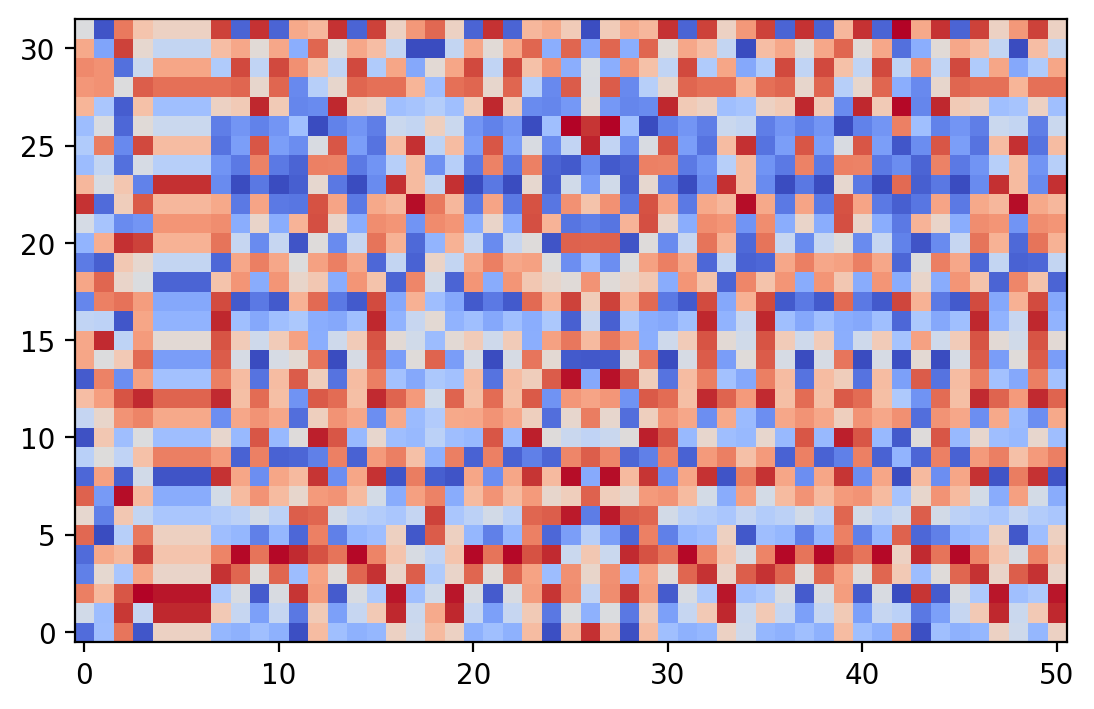

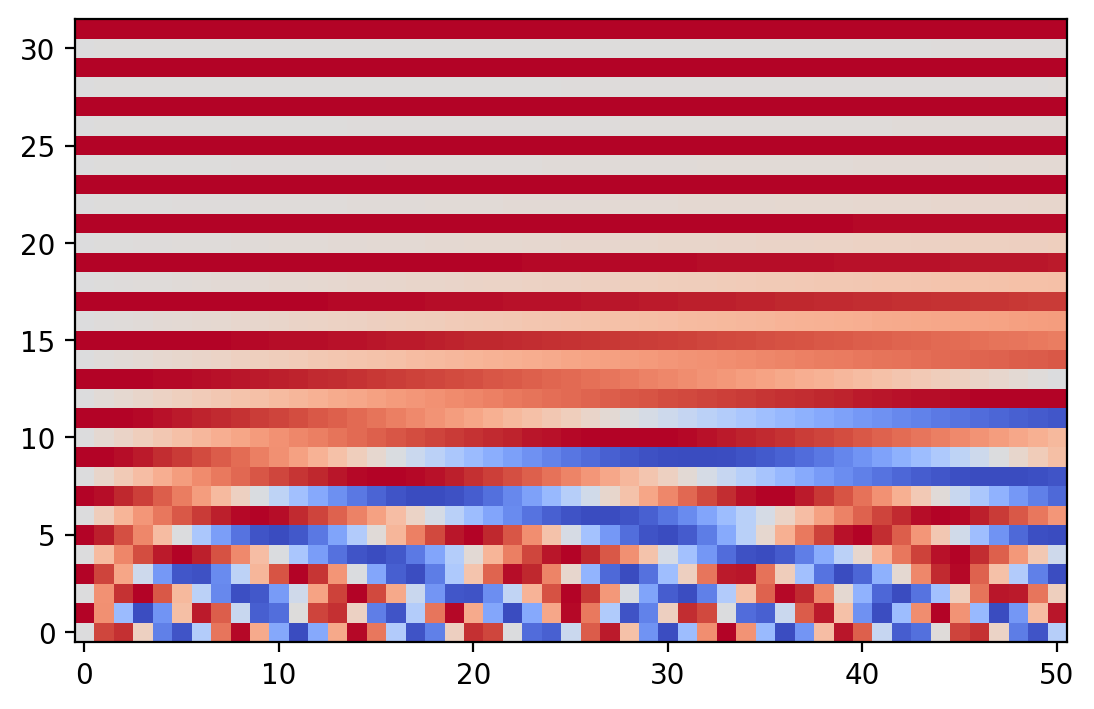

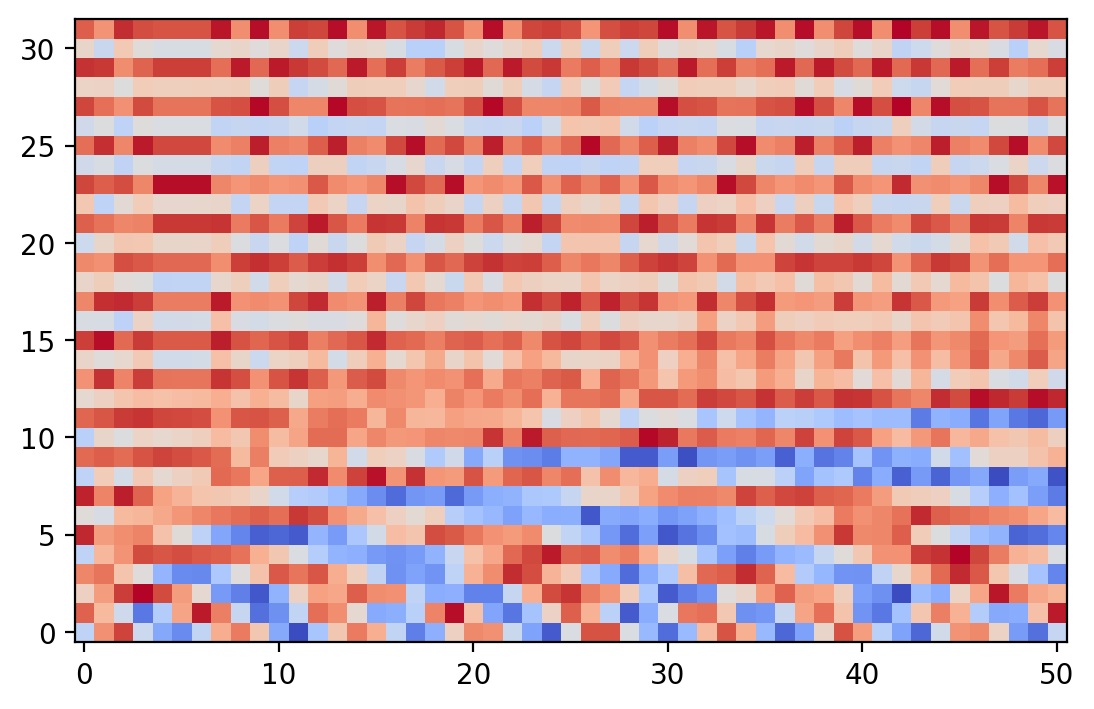

In [19]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [20]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   7552        ['input_1[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 token_and_position_embedding_2  (None, None, 128)   3072        ['input_2[0][0]']            

In [22]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [23]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show("midi")
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "D:/program/python/Lib/mylib/transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [24]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [25]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

Epoch 1/5000
108/108 [==============================] - ETA: 0s - loss: 4.8381 - note_outputs_loss: 3.5151 - duration_outputs_loss: 1.3230[['START', 'E3', 'B3', 'C4', 'F3', 'F#3', 'F#3', 'B3', 'A3', 'E3', 'B3', 'D4', 'G3', 'B3', 'C4', 'F#3', 'B3', 'G3', 'F3', 'E3', 'B3', 'E3', 'E3', 'G3', 'F#3', 'B3', 'E3', 'B3', 'E3', 'E3', 'B3', 'C4', 'E3', 'B3', 'E3', 'C4', 'G4', 'B3', 'D4', 'B3', 'G3', 'G3', 'E3', 'B3', 'B3', 'C4', 'B3', 'D3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 101s 914ms/step - loss: 4.8381 - note_outputs_loss: 3.5151 - duration_outputs_loss: 1.3230
Epoch 2/5000
108/108 [==============================] - ETA: 0s - loss: 4.2112 - note_outputs_loss: 3.3926 - duration_outputs_loss: 0.8186[['START', 'E3', 'D3', 'G3', 'D3', 'D3', 'D3', 'A3', 'A3', 'G3', 'D3', 'G3', 'C4', 'D4', 'A3', 'G3', 'A3', 'D3', 'G3', 'B2', 'C4', 'A3', 'A3', 'A3', 'B3', 'A3', 'C4', 'B2', 'D4', 'A3', 'D4', 'A3', 'B3', 'A3', 'A3', 'B3', 'B3', 'B3', 'A3', 'A3', 'A3', 'A2', 'E3', 'E3', 'C4', 'E3', 'D3', 'D3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 100s 927ms/step - loss: 4.2112 - note_outputs_loss: 3.3926 - duration_outputs_loss: 0.8186
Epoch 3/5000
108/108 [==============================] - ETA: 0s - loss: 3.8782 - note_outputs_loss: 3.1631 - duration_outputs_loss: 0.7151[['START', 'F#3', 'G3', 'F#3', 'D3', 'G3', 'E3', 'D3', 'D3', 'F#3', 'A3', 'B-3', 'A3', 'A3', 'B-3', 'B3', 'A3', 'A3', 'B-3', 'A3', 'A3', 'A3', 'B-3', 'F3', 'D3', 'D3', 'E3', 'D3', 'A2', 'D3', 'D3', 'D3', 'B2', 'D3', 'D3', 'D3', 'A2', 'D3', 'B2', 'A2', 'G2', 'G2', 'B2', 'D3', 'D3', 'A2', 'D3', 'B2', 'D3'], ['0.0', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


108/108 [==============================] - 99s 915ms/step - loss: 3.8782 - note_outputs_loss: 3.1631 - duration_outputs_loss: 0.7151
Epoch 4/5000
108/108 [==============================] - ETA: 0s - loss: 3.4819 - note_outputs_loss: 2.8438 - duration_outputs_loss: 0.6381[['START', 'F#3', 'G3', 'G3', 'E3', 'D3', 'C#3', 'D3', 'F3', 'E3', 'F3', 'A3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'G3', 'F3', 'G3', 'G3', 'F3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'F3', 'G3', 'D3', 'E3', 'F3', 'D3', 'C3', 'D3', 'B2', 'C3', 'G2', 'A2', 'G2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 102s 945ms/step - loss: 3.4819 - note_outputs_loss: 2.8438 - duration_outputs_loss: 0.6381
Epoch 5/5000
108/108 [==============================] - ETA: 0s - loss: 3.2966 - note_outputs_loss: 2.6819 - duration_outputs_loss: 0.6147[['START', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'D4', 'E4', 'D4', 'E4', 'E4', 'E4', 'E4', 'D4', 'C#4', 'D4', 'D4', 'D4', 'E4', 'D4', 'E4', 'D4', 'E4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'G2', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'C4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 99s 916ms/step - loss: 3.2966 - note_outputs_loss: 2.6819 - duration_outputs_loss: 0.6147
Epoch 6/5000
108/108 [==============================] - ETA: 0s - loss: 3.2097 - note_outputs_loss: 2.6123 - duration_outputs_loss: 0.5974[['START', '3/4TS', 'D4', 'E4', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'D4', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'B3', 'A3', 'D3', 'F#3', 'E3', 'D3', 'D3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'B3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 107s 987ms/step - loss: 3.2097 - note_outputs_loss: 2.6123 - duration_outputs_loss: 0.5974
Epoch 7/5000
108/108 [==============================] - ETA: 0s - loss: 3.1424 - note_outputs_loss: 2.5404 - duration_outputs_loss: 0.6020[['START', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', 'C:major', '4/4TS', '4/4TS', 'C:major'], ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']]


108/108 [==============================] - 101s 939ms/step - loss: 3.1424 - note_outputs_loss: 2.5404 - duration_outputs_loss: 0.6020
Epoch 8/5000
108/108 [==============================] - ETA: 0s - loss: 3.0794 - note_outputs_loss: 2.5011 - duration_outputs_loss: 0.5782[['START', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', '4/4TS', 'E4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'D4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'D4', 'C#4', 'C#4', 'D4', 'C#4', 'D4'], ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 3.0794 - note_outputs_loss: 2.5011 - duration_outputs_loss: 0.5782
Epoch 9/5000
108/108 [==============================] - ETA: 0s - loss: 3.0666 - note_outputs_loss: 2.4791 - duration_outputs_loss: 0.5875[['START', '3/4TS', 'E4', 'B4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'G4', 'G4', 'F#4', 'G4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'G4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'F#4', 'G4', 'G4', 'E4', 'F#4', 'G4', 'F#4', 'G4'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 112s 1s/step - loss: 3.0666 - note_outputs_loss: 2.4791 - duration_outputs_loss: 0.5875
Epoch 10/5000
108/108 [==============================] - ETA: 0s - loss: 3.0349 - note_outputs_loss: 2.4468 - duration_outputs_loss: 0.5881[['START', '4/4TS', '4/4TS', '4/4TS', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'A4', 'E4', 'E4', 'A4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'A4', 'G4', 'G4', 'F#4', 'F#4', 'A4', 'F#4', 'G4', 'F#4', 'F#4'], ['0.0', '0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 3.0349 - note_outputs_loss: 2.4468 - duration_outputs_loss: 0.5881
Epoch 11/5000
108/108 [==============================] - ETA: 0s - loss: 2.9682 - note_outputs_loss: 2.4103 - duration_outputs_loss: 0.5579[['START', 'E-:major', '3/4TS', '4/4TS', '4/4TS', 'rest', 'G2'], ['0.0', '0.0', '0.0', '0.0', '0.0', '2.0', '1.0']]


108/108 [==============================] - 109s 1s/step - loss: 2.9682 - note_outputs_loss: 2.4103 - duration_outputs_loss: 0.5579
Epoch 12/5000
108/108 [==============================] - ETA: 0s - loss: 2.9617 - note_outputs_loss: 2.3890 - duration_outputs_loss: 0.5727[['START', 'C:major', '3/4TS', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 112s 1s/step - loss: 2.9617 - note_outputs_loss: 2.3890 - duration_outputs_loss: 0.5727
Epoch 13/5000
108/108 [==============================] - ETA: 0s - loss: 2.9390 - note_outputs_loss: 2.3714 - duration_outputs_loss: 0.5676[['START', 'C:major', '3/4TS', 'D3', 'B2', 'D3', 'F3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'C3', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3'], ['0.0', '0.5', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 112s 1s/step - loss: 2.9390 - note_outputs_loss: 2.3714 - duration_outputs_loss: 0.5676
Epoch 14/5000
108/108 [==============================] - ETA: 0s - loss: 2.9191 - note_outputs_loss: 2.3622 - duration_outputs_loss: 0.5569[['START', '4/4TS', '4/4TS', 'rest'], ['0.0', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 975ms/step - loss: 2.9191 - note_outputs_loss: 2.3622 - duration_outputs_loss: 0.5569
Epoch 15/5000
108/108 [==============================] - ETA: 0s - loss: 2.8887 - note_outputs_loss: 2.3298 - duration_outputs_loss: 0.5590[['START', '4/4TS', '4/4TS', 'rest', 'D4'], ['0.0', '0.0', '0.0', '3.75', '1.0']]


108/108 [==============================] - 105s 975ms/step - loss: 2.8887 - note_outputs_loss: 2.3298 - duration_outputs_loss: 0.5590
Epoch 16/5000
108/108 [==============================] - ETA: 0s - loss: 2.8735 - note_outputs_loss: 2.3104 - duration_outputs_loss: 0.5630[['START', 'E-:major', '3/4TS', 'D3', 'F#3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'F#3', 'G3', 'A3', 'F#3', 'A3', 'E3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'A3', 'A3', 'B3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'B3', 'C#4', 'A3', 'D4', 'E4', 'A3', 'D4', 'E4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'A3', 'E4', 'D4', 'C#4', 'D4'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 110s 1s/step - loss: 2.8735 - note_outputs_loss: 2.3104 - duration_outputs_loss: 0.5630
Epoch 17/5000
108/108 [==============================] - ETA: 0s - loss: 2.8648 - note_outputs_loss: 2.3066 - duration_outputs_loss: 0.5581[['START', '4/4TS', 'rest', 'rest', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'E-3', 'G3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 2.8648 - note_outputs_loss: 2.3066 - duration_outputs_loss: 0.5581
Epoch 18/5000
108/108 [==============================] - ETA: 0s - loss: 2.8373 - note_outputs_loss: 2.2850 - duration_outputs_loss: 0.5523[['START', '3/4TS', 'rest', 'G3', 'G3', 'G3', 'B-2', 'A2', 'C3', 'B-2', 'A2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'B-2', 'C3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 2.8373 - note_outputs_loss: 2.2850 - duration_outputs_loss: 0.5523
Epoch 19/5000
108/108 [==============================] - ETA: 0s - loss: 2.8099 - note_outputs_loss: 2.2646 - duration_outputs_loss: 0.5453[['START', '4/4TS', 'rest', 'rest', 'E-3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 2.8099 - note_outputs_loss: 2.2646 - duration_outputs_loss: 0.5453
Epoch 20/5000
108/108 [==============================] - ETA: 0s - loss: 2.8071 - note_outputs_loss: 2.2548 - duration_outputs_loss: 0.5523[['START', '4/4TS', '3/4TS', 'C4', 'B3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 2.8071 - note_outputs_loss: 2.2548 - duration_outputs_loss: 0.5523
Epoch 21/5000
108/108 [==============================] - ETA: 0s - loss: 2.7948 - note_outputs_loss: 2.2427 - duration_outputs_loss: 0.5521[['START', '4/4TS', 'rest', 'C4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'G2', 'G2', 'C2', 'G2', 'G#2', 'G2', 'B2', 'G2', 'G#2', 'G2', 'F3', 'E3', 'F3', 'G3', 'F3', 'E3', 'F3', 'G2', 'B2', 'C3', 'G2', 'G2', 'G2', 'G2'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 108s 999ms/step - loss: 2.7948 - note_outputs_loss: 2.2427 - duration_outputs_loss: 0.5521
Epoch 22/5000
108/108 [==============================] - ETA: 0s - loss: 2.7845 - note_outputs_loss: 2.2339 - duration_outputs_loss: 0.5505[['START', 'E-:major', '4/4TS', 'rest', 'rest', 'D4', 'rest'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 100s 921ms/step - loss: 2.7845 - note_outputs_loss: 2.2339 - duration_outputs_loss: 0.5505
Epoch 23/5000
108/108 [==============================] - ETA: 0s - loss: 2.7787 - note_outputs_loss: 2.2167 - duration_outputs_loss: 0.5619[['START', 'E-:major', '4/4TS', '4/4TS', 'A4', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'D3', 'F#3', 'D3', 'F#3', 'D3', 'D3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'E3', 'D3', 'F#3', 'D3', 'F#3', 'G3', 'A3', 'B3', 'F#3', 'E3'], ['0.0', '0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 967ms/step - loss: 2.7787 - note_outputs_loss: 2.2167 - duration_outputs_loss: 0.5619
Epoch 24/5000
108/108 [==============================] - ETA: 0s - loss: 2.7668 - note_outputs_loss: 2.2052 - duration_outputs_loss: 0.5615[['START', '3/4TS', 'rest', 'G3', 'E-3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'E4', 'D4', 'C4', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 966ms/step - loss: 2.7668 - note_outputs_loss: 2.2052 - duration_outputs_loss: 0.5615
Epoch 25/5000
108/108 [==============================] - ETA: 0s - loss: 2.7413 - note_outputs_loss: 2.1977 - duration_outputs_loss: 0.5436[['START', '4/4TS', 'rest', 'rest', 'D4', 'G2', 'G2', 'F#2', 'G2', 'A2', 'G2', 'C3', 'G2', 'G2', 'rest', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G3', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2', 'G2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 101s 934ms/step - loss: 2.7413 - note_outputs_loss: 2.1977 - duration_outputs_loss: 0.5436
Epoch 26/5000
108/108 [==============================] - ETA: 0s - loss: 2.7192 - note_outputs_loss: 2.1753 - duration_outputs_loss: 0.5438[['START', '3/8TS', 'rest', 'C4', 'G3', 'D4', 'E4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'E3', 'C3', 'G2', 'E3', 'G2', 'D3', 'E3', 'F3', 'G3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 961ms/step - loss: 2.7192 - note_outputs_loss: 2.1753 - duration_outputs_loss: 0.5438
Epoch 27/5000
108/108 [==============================] - ETA: 0s - loss: 2.7125 - note_outputs_loss: 2.1685 - duration_outputs_loss: 0.5441[['START', '3/4TS', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'C3', 'B2', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'B3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3'], ['0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 105s 972ms/step - loss: 2.7125 - note_outputs_loss: 2.1685 - duration_outputs_loss: 0.5441
Epoch 28/5000
108/108 [==============================] - ETA: 0s - loss: 2.6932 - note_outputs_loss: 2.1536 - duration_outputs_loss: 0.5396[['START', '4/4TS', 'rest', 'rest', 'C4', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B-3', 'G3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 963ms/step - loss: 2.6932 - note_outputs_loss: 2.1536 - duration_outputs_loss: 0.5396
Epoch 29/5000
108/108 [==============================] - ETA: 0s - loss: 2.6855 - note_outputs_loss: 2.1458 - duration_outputs_loss: 0.5397[['START', 'E-:major', 'E-:major', '4/4TS', 'rest', 'E-3', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 969ms/step - loss: 2.6855 - note_outputs_loss: 2.1458 - duration_outputs_loss: 0.5397
Epoch 30/5000
108/108 [==============================] - ETA: 0s - loss: 2.6750 - note_outputs_loss: 2.1330 - duration_outputs_loss: 0.5420[['START', '3/4TS', 'rest', 'C4', 'D4', 'B3', 'G3', 'D3', 'A3', 'B3', 'A3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'E3', 'D3', 'C#3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'F#3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'B3', 'A3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '1.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '1.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75']]


108/108 [==============================] - 106s 977ms/step - loss: 2.6750 - note_outputs_loss: 2.1330 - duration_outputs_loss: 0.5420
Epoch 31/5000
108/108 [==============================] - ETA: 0s - loss: 2.6651 - note_outputs_loss: 2.1174 - duration_outputs_loss: 0.5477[['START', '4/4TS', 'rest', 'G3', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'D3', 'B2', 'C3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3'], ['0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 973ms/step - loss: 2.6651 - note_outputs_loss: 2.1174 - duration_outputs_loss: 0.5477
Epoch 32/5000
108/108 [==============================] - ETA: 0s - loss: 2.6454 - note_outputs_loss: 2.1016 - duration_outputs_loss: 0.5439[['START', 'E-:major', '3/4TS', 'rest', 'C4', 'F#3', 'G3', 'A3', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'D3', 'F#3', 'A3', 'D3', 'A3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 107s 987ms/step - loss: 2.6454 - note_outputs_loss: 2.1016 - duration_outputs_loss: 0.5439
Epoch 33/5000
108/108 [==============================] - ETA: 0s - loss: 2.6350 - note_outputs_loss: 2.0944 - duration_outputs_loss: 0.5406[['START', 'D:major', 'D:major', 'rest', 'E4', 'E4', 'E4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A3', 'C#4', 'D4', 'C#4', 'E4', 'A3', 'A4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'F#4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 963ms/step - loss: 2.6350 - note_outputs_loss: 2.0944 - duration_outputs_loss: 0.5406
Epoch 34/5000
108/108 [==============================] - ETA: 0s - loss: 2.6203 - note_outputs_loss: 2.0810 - duration_outputs_loss: 0.5393[['START', 'D:major', '3/4TS', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '

108/108 [==============================] - 104s 960ms/step - loss: 2.6203 - note_outputs_loss: 2.0810 - duration_outputs_loss: 0.5393
Epoch 35/5000
108/108 [==============================] - ETA: 0s - loss: 2.6043 - note_outputs_loss: 2.0666 - duration_outputs_loss: 0.5377[['START', '3/4TS', 'rest', 'E-4', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'G2', 'F2', 'E-2', 'D2', 'E-2', 'F2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 972ms/step - loss: 2.6043 - note_outputs_loss: 2.0666 - duration_outputs_loss: 0.5377
Epoch 36/5000
108/108 [==============================] - ETA: 0s - loss: 2.5896 - note_outputs_loss: 2.0499 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'G2', 'F2', 'E-2', 'D2', 'E-2', 'F2', 'G2', 'A2', 'G2', 'F2', 'G2', 'A2', 'G2', 'A2', 'D3', 'G2', 'F2', 'G2', 'A2', 'G2', 'A2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 976ms/step - loss: 2.5896 - note_outputs_loss: 2.0499 - duration_outputs_loss: 0.5397
Epoch 37/5000
108/108 [==============================] - ETA: 0s - loss: 2.5820 - note_outputs_loss: 2.0433 - duration_outputs_loss: 0.5387[['START', '3/4TS', 'rest', 'A3', 'D3', 'E3', 'F3', 'D3', 'B-2', 'A2', 'G2', 'G#2', 'F2', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B2', 'D3', 'G3', 'E-3', 'F3'], ['0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 107s 988ms/step - loss: 2.5820 - note_outputs_loss: 2.0433 - duration_outputs_loss: 0.5387
Epoch 38/5000
108/108 [==============================] - ETA: 0s - loss: 2.5716 - note_outputs_loss: 2.0323 - duration_outputs_loss: 0.5393[['START', '3/4TS', 'rest', 'G3', 'rest', 'B-3', 'G3', 'B-3', 'G3', 'D3', 'D3', 'F#3', 'G3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'B-2', 'A2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'D3', 'C3', 'B2', 'C3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 110s 1s/step - loss: 2.5716 - note_outputs_loss: 2.0323 - duration_outputs_loss: 0.5393
Epoch 39/5000
108/108 [==============================] - ETA: 0s - loss: 2.5511 - note_outputs_loss: 2.0070 - duration_outputs_loss: 0.5441[['START', 'F:major', '3/4TS', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'G2', 'F2', 'G2', 'A2', 'F2', 'E2', 'D2', 'A2', 'C3', 'F2', 'A2', 'F2', 'E2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'E2', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 2.5511 - note_outputs_loss: 2.0070 - duration_outputs_loss: 0.5441
Epoch 40/5000
108/108 [==============================] - ETA: 0s - loss: 2.5482 - note_outputs_loss: 2.0041 - duration_outputs_loss: 0.5441[['START', '3/4TS', 'rest', 'C4', 'D4', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'B3', 'G3', 'E3', 'F3', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'C#4'], ['0.0', '0.0', '3.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 2.5482 - note_outputs_loss: 2.0041 - duration_outputs_loss: 0.5441
Epoch 41/5000
108/108 [==============================] - ETA: 0s - loss: 2.5326 - note_outputs_loss: 1.9861 - duration_outputs_loss: 0.5465[['START', 'D:major', 'D:major', '12/8TS', 'A3', 'A3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'A3', 'G4', 'A3', 'F#4', 'A3', 'E4', 'A3', 'G4', 'A3', 'F#4', 'A3', 'A4', 'A3', 'F#4', 'A3', 'A4', 'A3', 'F#4', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'D3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 2.5326 - note_outputs_loss: 1.9861 - duration_outputs_loss: 0.5465
Epoch 42/5000
108/108 [==============================] - ETA: 0s - loss: 2.5105 - note_outputs_loss: 1.9694 - duration_outputs_loss: 0.5411[['START', 'D:major', '6/8TS', 'rest', 'rest', 'rest', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'F#4', 'rest', 'A4', 'A4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'G4', 'G4', 'rest', 'F#4', 'A4', 'A4', 'G4', 'G4', 'E4', 'C#4', 'rest', 'C#4', 'C#4', 'C#4', 'A3', 'G4', 'F#4', 'G4', 'rest', 'F#4'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '

108/108 [==============================] - 109s 1s/step - loss: 2.5105 - note_outputs_loss: 1.9694 - duration_outputs_loss: 0.5411
Epoch 43/5000
108/108 [==============================] - ETA: 0s - loss: 2.5022 - note_outputs_loss: 1.9622 - duration_outputs_loss: 0.5399[['START', '3/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'F#3', 'G3', 'D3', 'G2', 'D3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B2', 'G2', 'D3', 'B3', 'D3', 'C4', 'B3', 'C4', 'B3', 'C4', 'G#3', 'B3', 'E3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 2.5022 - note_outputs_loss: 1.9622 - duration_outputs_loss: 0.5399
Epoch 44/5000
108/108 [==============================] - ETA: 0s - loss: 2.5002 - note_outputs_loss: 1.9496 - duration_outputs_loss: 0.5506[['START', '4/4TS', '3/4TS', 'C4', 'C4', 'C4', 'D4', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'C4', 'E-3', 'G3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 111s 1s/step - loss: 2.5002 - note_outputs_loss: 1.9496 - duration_outputs_loss: 0.5506
Epoch 45/5000
108/108 [==============================] - ETA: 0s - loss: 2.5106 - note_outputs_loss: 1.9537 - duration_outputs_loss: 0.5569[['START', 'D:major', '3/4TS', 'rest', 'A3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'F#3', 'A3', 'C4', 'D4', 'A3', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D3', 'B3', 'G3', 'F#3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 112s 1s/step - loss: 2.5106 - note_outputs_loss: 1.9537 - duration_outputs_loss: 0.5569
Epoch 46/5000
108/108 [==============================] - ETA: 0s - loss: 2.4621 - note_outputs_loss: 1.9267 - duration_outputs_loss: 0.5354[['START', 'F:major', 'F:major', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 112s 1s/step - loss: 2.4621 - note_outputs_loss: 1.9267 - duration_outputs_loss: 0.5354
Epoch 47/5000
108/108 [==============================] - ETA: 0s - loss: 2.4551 - note_outputs_loss: 1.9132 - duration_outputs_loss: 0.5419[['START', 'D:major', 'D:major', '6/8TS', 'rest', 'A4', 'A4', 'A4', 'F#4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'F#4', 'E4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 113s 1s/step - loss: 2.4551 - note_outputs_loss: 1.9132 - duration_outputs_loss: 0.5419
Epoch 48/5000
108/108 [==============================] - ETA: 0s - loss: 2.4422 - note_outputs_loss: 1.9058 - duration_outputs_loss: 0.5363[['START', 'F:major', '3/4TS', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'F3', 'F3', 'A3', 'F3', 'F3', 'A3', 'F3', 'F3', 'F3', 'F3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'G3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 105s 969ms/step - loss: 2.4422 - note_outputs_loss: 1.9058 - duration_outputs_loss: 0.5363
Epoch 49/5000
108/108 [==============================] - ETA: 0s - loss: 2.4306 - note_outputs_loss: 1.8867 - duration_outputs_loss: 0.5439[['START', 'G:major', '3/4TS', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'C4', 'G#3', 'E-4', 'C4', 'D4', 'E-4', 'D4', 'E-4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 960ms/step - loss: 2.4306 - note_outputs_loss: 1.8867 - duration_outputs_loss: 0.5439
Epoch 50/5000
108/108 [==============================] - ETA: 0s - loss: 2.4232 - note_outputs_loss: 1.8825 - duration_outputs_loss: 0.5407[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'B-2', 'D3', 'G2', 'B-2', 'D3', 'G3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'C4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'D4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 959ms/step - loss: 2.4232 - note_outputs_loss: 1.8825 - duration_outputs_loss: 0.5407
Epoch 51/5000
108/108 [==============================] - ETA: 0s - loss: 2.4099 - note_outputs_loss: 1.8692 - duration_outputs_loss: 0.5407[['START', 'F:major', 'F:major', '3/4TS', 'D3', 'G2', 'C3', 'B-2', 'A2', 'G2', 'F2', 'A2', 'F2', 'E2', 'D2', 'F2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'D4', 'C4', 'D4', 'B-3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 107s 989ms/step - loss: 2.4099 - note_outputs_loss: 1.8692 - duration_outputs_loss: 0.5407
Epoch 52/5000
108/108 [==============================] - ETA: 0s - loss: 2.3962 - note_outputs_loss: 1.8583 - duration_outputs_loss: 0.5379[['START', 'F:major', '3/4TS', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2', 'E-2', 'D2', 'E-2', 'F2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 108s 1s/step - loss: 2.3962 - note_outputs_loss: 1.8583 - duration_outputs_loss: 0.5379
Epoch 53/5000
108/108 [==============================] - ETA: 0s - loss: 2.3787 - note_outputs_loss: 1.8432 - duration_outputs_loss: 0.5355[['START', 'E-:major', '4/4TS', '3/4TS', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 106s 982ms/step - loss: 2.3787 - note_outputs_loss: 1.8432 - duration_outputs_loss: 0.5355
Epoch 54/5000
108/108 [==============================] - ETA: 0s - loss: 2.3892 - note_outputs_loss: 1.8375 - duration_outputs_loss: 0.5517[['START', 'F:major', '3/4TS', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'A3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 103s 956ms/step - loss: 2.3892 - note_outputs_loss: 1.8375 - duration_outputs_loss: 0.5517
Epoch 55/5000
108/108 [==============================] - ETA: 0s - loss: 2.3716 - note_outputs_loss: 1.8253 - duration_outputs_loss: 0.5463[['START', '3/4TS', '3/4TS', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 960ms/step - loss: 2.3716 - note_outputs_loss: 1.8253 - duration_outputs_loss: 0.5463
Epoch 56/5000
108/108 [==============================] - ETA: 0s - loss: 2.3474 - note_outputs_loss: 1.8120 - duration_outputs_loss: 0.5354[['START', 'F:major', '3/4TS', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 977ms/step - loss: 2.3474 - note_outputs_loss: 1.8120 - duration_outputs_loss: 0.5354
Epoch 57/5000
108/108 [==============================] - ETA: 0s - loss: 2.3336 - note_outputs_loss: 1.7980 - duration_outputs_loss: 0.5357[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'G#2', 'G2', 'B-2', 'D3', 'F3', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 975ms/step - loss: 2.3336 - note_outputs_loss: 1.7980 - duration_outputs_loss: 0.5357
Epoch 58/5000
108/108 [==============================] - ETA: 0s - loss: 2.3341 - note_outputs_loss: 1.7951 - duration_outputs_loss: 0.5390[['START', 'F:major', '3/4TS', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'B-2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 103s 955ms/step - loss: 2.3341 - note_outputs_loss: 1.7951 - duration_outputs_loss: 0.5390
Epoch 59/5000
108/108 [==============================] - ETA: 0s - loss: 2.3160 - note_outputs_loss: 1.7778 - duration_outputs_loss: 0.5382[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 967ms/step - loss: 2.3160 - note_outputs_loss: 1.7778 - duration_outputs_loss: 0.5382
Epoch 60/5000
108/108 [==============================] - ETA: 0s - loss: 2.3080 - note_outputs_loss: 1.7675 - duration_outputs_loss: 0.5406[['START', 'E-:major', '4/4TS', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 103s 956ms/step - loss: 2.3080 - note_outputs_loss: 1.7675 - duration_outputs_loss: 0.5406
Epoch 61/5000
108/108 [==============================] - ETA: 0s - loss: 2.2984 - note_outputs_loss: 1.7596 - duration_outputs_loss: 0.5388[['START', 'F:major', '3/4TS', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'A3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'C#3', 'G3', 'F3', 'G3', 'A3', 'D4', 'A3', 'C#4', 'E4', 'A3', 'B-3', 'A3', 'C#4', 'D4', 'A3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'C3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 960ms/step - loss: 2.2984 - note_outputs_loss: 1.7596 - duration_outputs_loss: 0.5388
Epoch 62/5000
108/108 [==============================] - ETA: 0s - loss: 2.2802 - note_outputs_loss: 1.7459 - duration_outputs_loss: 0.5343[['START', 'F:major', '3/4TS', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 971ms/step - loss: 2.2802 - note_outputs_loss: 1.7459 - duration_outputs_loss: 0.5343
Epoch 63/5000
108/108 [==============================] - ETA: 0s - loss: 2.2785 - note_outputs_loss: 1.7443 - duration_outputs_loss: 0.5341[['START', '3/4TS', 'D3', 'G3', 'E3', 'F3', 'D3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'B-2', 'A2', 'G2', 'F2', 'A2', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'E3', 'C3', 'C2', 'B2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 979ms/step - loss: 2.2785 - note_outputs_loss: 1.7443 - duration_outputs_loss: 0.5341
Epoch 64/5000
108/108 [==============================] - ETA: 0s - loss: 2.2685 - note_outputs_loss: 1.7314 - duration_outputs_loss: 0.5371[['START', '3/4TS', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 106s 984ms/step - loss: 2.2685 - note_outputs_loss: 1.7314 - duration_outputs_loss: 0.5371
Epoch 65/5000
108/108 [==============================] - ETA: 0s - loss: 2.2560 - note_outputs_loss: 1.7155 - duration_outputs_loss: 0.5405[['START', 'E-:major', '4/4TS', 'rest', 'rest', 'rest', 'D4', 'rest', 'B-3', 'E-4', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 974ms/step - loss: 2.2560 - note_outputs_loss: 1.7155 - duration_outputs_loss: 0.5405
Epoch 66/5000
108/108 [==============================] - ETA: 0s - loss: 2.2434 - note_outputs_loss: 1.7058 - duration_outputs_loss: 0.5376[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 975ms/step - loss: 2.2434 - note_outputs_loss: 1.7058 - duration_outputs_loss: 0.5376
Epoch 67/5000
108/108 [==============================] - ETA: 0s - loss: 2.2483 - note_outputs_loss: 1.7039 - duration_outputs_loss: 0.5444[['START', 'G:major', '3/4TS', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'D3', 'B2', 'G2', 'D3', 'F#3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'G3', 'E3', 'F#3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'F#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 105s 974ms/step - loss: 2.2483 - note_outputs_loss: 1.7039 - duration_outputs_loss: 0.5444
Epoch 68/5000
108/108 [==============================] - ETA: 0s - loss: 2.2449 - note_outputs_loss: 1.7037 - duration_outputs_loss: 0.5412[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'G#2', 'B-2', 'G2', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'G#2', 'C3', 'G2', 'F2', 'G#2', 'D3', 'F3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'A3', 'B-3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 982ms/step - loss: 2.2449 - note_outputs_loss: 1.7037 - duration_outputs_loss: 0.5412
Epoch 69/5000
108/108 [==============================] - ETA: 0s - loss: 2.2253 - note_outputs_loss: 1.6874 - duration_outputs_loss: 0.5379[['START', 'E-:major', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '3.0']]


108/108 [==============================] - 102s 943ms/step - loss: 2.2253 - note_outputs_loss: 1.6874 - duration_outputs_loss: 0.5379
Epoch 70/5000
108/108 [==============================] - ETA: 0s - loss: 2.2087 - note_outputs_loss: 1.6746 - duration_outputs_loss: 0.5341[['START', 'E-:major', '4/4TS', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'E-3', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 106s 983ms/step - loss: 2.2087 - note_outputs_loss: 1.6746 - duration_outputs_loss: 0.5341
Epoch 71/5000
108/108 [==============================] - ETA: 0s - loss: 2.2210 - note_outputs_loss: 1.6796 - duration_outputs_loss: 0.5414[['START', 'C:major', '3/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'A3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 107s 990ms/step - loss: 2.2210 - note_outputs_loss: 1.6796 - duration_outputs_loss: 0.5414
Epoch 72/5000
108/108 [==============================] - ETA: 0s - loss: 2.2006 - note_outputs_loss: 1.6602 - duration_outputs_loss: 0.5404[['START', 'F:major', '3/4TS', 'D3', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'D3', 'E-3', 'A3', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'E3', 'F#3', 'D3', 'C3', 'B2', 'A2', 'G2', 'B2', 'D3'], ['0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 997ms/step - loss: 2.2006 - note_outputs_loss: 1.6602 - duration_outputs_loss: 0.5404
Epoch 73/5000
108/108 [==============================] - ETA: 0s - loss: 2.1833 - note_outputs_loss: 1.6506 - duration_outputs_loss: 0.5327[['START', '3/4TS', '3/4TS', 'rest', 'E-3', 'A3', 'rest', 'G3', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'E4', 'C#4', 'A3', 'F#4', 'E4', 'F#4', 'A3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 101s 930ms/step - loss: 2.1833 - note_outputs_loss: 1.6506 - duration_outputs_loss: 0.5327
Epoch 74/5000
108/108 [==============================] - ETA: 0s - loss: 2.1885 - note_outputs_loss: 1.6484 - duration_outputs_loss: 0.5401[['START', '3/4TS', '3/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'D3', 'F3', 'C3', 'B-2', 'D3', 'G#2', 'G2', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'F2', 'B2', 'D3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 101s 936ms/step - loss: 2.1885 - note_outputs_loss: 1.6484 - duration_outputs_loss: 0.5401
Epoch 75/5000
108/108 [==============================] - ETA: 0s - loss: 2.1810 - note_outputs_loss: 1.6411 - duration_outputs_loss: 0.5400[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'G#3', 'E3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'E-2', 'G2', 'F2', 'G2', 'C3', 'F2', 'G2', 'D3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 103s 955ms/step - loss: 2.1810 - note_outputs_loss: 1.6411 - duration_outputs_loss: 0.5400
Epoch 76/5000
108/108 [==============================] - ETA: 0s - loss: 2.1590 - note_outputs_loss: 1.6269 - duration_outputs_loss: 0.5321[['START', '4/4TS', '3/4TS', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'C3', 'E3', 'A3', 'B3', 'C4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 101s 937ms/step - loss: 2.1590 - note_outputs_loss: 1.6269 - duration_outputs_loss: 0.5321
Epoch 77/5000
108/108 [==============================] - ETA: 0s - loss: 2.1636 - note_outputs_loss: 1.6229 - duration_outputs_loss: 0.5407[['START', 'C:major', '3/4TS', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'B2', 'C3', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F3', 'C:major', 'G3', 'C3', 'B2', 'C3', 'C4', 'B3', 'A3', 'G3', 'F3', 'C3', 'B2', 'C3', 'C4', 'B2'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 977ms/step - loss: 2.1636 - note_outputs_loss: 1.6229 - duration_outputs_loss: 0.5407
Epoch 78/5000
108/108 [==============================] - ETA: 0s - loss: 2.1541 - note_outputs_loss: 1.6171 - duration_outputs_loss: 0.5370[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'E-3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'B-3', 'D3', 'E-3', 'F3', 'B-2', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 107s 990ms/step - loss: 2.1541 - note_outputs_loss: 1.6171 - duration_outputs_loss: 0.5370
Epoch 79/5000
108/108 [==============================] - ETA: 0s - loss: 2.1498 - note_outputs_loss: 1.6127 - duration_outputs_loss: 0.5372[['START', 'C:major', '4/4TS', 'D3', 'E3', 'F3', 'D3', 'E3', 'C3', 'G2', 'B2', 'D3', 'G3', 'E3', 'C3', 'C2', 'B2', 'C#3', 'E3', 'A3', 'E3', 'F#3', 'G3', 'G3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'A2', 'F#2', 'G2', 'B2', 'D3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 107s 986ms/step - loss: 2.1498 - note_outputs_loss: 1.6127 - duration_outputs_loss: 0.5372
Epoch 80/5000
108/108 [==============================] - ETA: 0s - loss: 2.1426 - note_outputs_loss: 1.6044 - duration_outputs_loss: 0.5382[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 971ms/step - loss: 2.1426 - note_outputs_loss: 1.6044 - duration_outputs_loss: 0.5382
Epoch 81/5000
108/108 [==============================] - ETA: 0s - loss: 2.1432 - note_outputs_loss: 1.5982 - duration_outputs_loss: 0.5450[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'B3', 'G2', 'A2', 'B2', 'C3', 'D3', 'E-3', 'C3', 'B2', 'G2', 'A2', 'B2', 'F2', 'B2', 'D3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'F3', 'A3', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'F3', 'E3', 'F3', 'A3', 'G3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 110s 1s/step - loss: 2.1432 - note_outputs_loss: 1.5982 - duration_outputs_loss: 0.5450
Epoch 82/5000
108/108 [==============================] - ETA: 0s - loss: 2.1383 - note_outputs_loss: 1.6013 - duration_outputs_loss: 0.5369[['START', 'C:major', '3/4TS', 'rest', 'A4', 'A4', 'B4', 'F#4', 'G4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'G4', 'C#3', 'E3', 'F#3', 'B3', 'F#3', 'B3', 'A3', 'G3', 'E4', 'D3', 'C#3', 'E3', 'A3', 'A2', 'E3', 'F#3', 'G3', 'A3', 'G3', 'A3', 'G3', 'A3', 'F#3', 'A3', 'C4', 'B3', 'D4', 'E4', 'F#4', 'G4', 'A4', 'B4', 'C#5', 'D5'], ['0.0', '0.0', '0.0', '2.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 109s 1s/step - loss: 2.1383 - note_outputs_loss: 1.6013 - duration_outputs_loss: 0.5369
Epoch 83/5000
108/108 [==============================] - ETA: 0s - loss: 2.1236 - note_outputs_loss: 1.5880 - duration_outputs_loss: 0.5356[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'E4', 'C#4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'E3', 'C3', 'F2', 'A3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'F2', 'A2', 'D3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 2.1236 - note_outputs_loss: 1.5880 - duration_outputs_loss: 0.5356
Epoch 84/5000
108/108 [==============================] - ETA: 0s - loss: 2.1209 - note_outputs_loss: 1.5810 - duration_outputs_loss: 0.5399[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'G2', 'F2', 'G2', 'rest'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 969ms/step - loss: 2.1209 - note_outputs_loss: 1.5810 - duration_outputs_loss: 0.5399
Epoch 85/5000
108/108 [==============================] - ETA: 0s - loss: 2.1137 - note_outputs_loss: 1.5715 - duration_outputs_loss: 0.5422[['START', '4/4TS', '4/4TS', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2'], ['0.0', '0.0', '0.0', '3.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 1s/step - loss: 2.1137 - note_outputs_loss: 1.5715 - duration_outputs_loss: 0.5422
Epoch 86/5000
108/108 [==============================] - ETA: 0s - loss: 2.1025 - note_outputs_loss: 1.5682 - duration_outputs_loss: 0.5343[['START', '3/4TS', '3/4TS', '3/4TS', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 969ms/step - loss: 2.1025 - note_outputs_loss: 1.5682 - duration_outputs_loss: 0.5343
Epoch 87/5000
108/108 [==============================] - ETA: 0s - loss: 2.1043 - note_outputs_loss: 1.5631 - duration_outputs_loss: 0.5411[['START', 'C:major', '4/4TS', 'rest', 'F#4', 'G4', 'B3', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'G3', 'G#3', 'B3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C2', 'F#3', 'G3', 'E-3', 'C3', 'A3', 'D3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'D3', 'F#3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.75', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 102s 940ms/step - loss: 2.1043 - note_outputs_loss: 1.5631 - duration_outputs_loss: 0.5411
Epoch 88/5000
108/108 [==============================] - ETA: 0s - loss: 2.0990 - note_outputs_loss: 1.5577 - duration_outputs_loss: 0.5413[['START', 'F:major', '4/4TS', 'rest', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'F3', 'A3', 'D4', 'A3', 'D4', 'A3', 'F3', 'D3', 'E3', 'F3', 'A3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'C#2', 'E4', 'D4', 'C#4'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 107s 990ms/step - loss: 2.0990 - note_outputs_loss: 1.5577 - duration_outputs_loss: 0.5413
Epoch 89/5000
108/108 [==============================] - ETA: 0s - loss: 2.0853 - note_outputs_loss: 1.5445 - duration_outputs_loss: 0.5409[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 109s 1s/step - loss: 2.0853 - note_outputs_loss: 1.5445 - duration_outputs_loss: 0.5409
Epoch 90/5000
108/108 [==============================] - ETA: 0s - loss: 2.0994 - note_outputs_loss: 1.5572 - duration_outputs_loss: 0.5422[['START', 'C:major', '3/4TS', 'rest', 'D4', 'D4', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'D4', 'B3', 'G3', 'C3', 'A3', 'G3', 'F#3', 'A3', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'C3', 'D3', 'C3', 'D3', 'F#3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 997ms/step - loss: 2.0994 - note_outputs_loss: 1.5572 - duration_outputs_loss: 0.5422
Epoch 91/5000
108/108 [==============================] - ETA: 0s - loss: 2.0937 - note_outputs_loss: 1.5473 - duration_outputs_loss: 0.5464[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'D3', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 108s 998ms/step - loss: 2.0937 - note_outputs_loss: 1.5473 - duration_outputs_loss: 0.5464
Epoch 92/5000
108/108 [==============================] - ETA: 0s - loss: 2.0794 - note_outputs_loss: 1.5372 - duration_outputs_loss: 0.5422[['START', 'F:major', '3/8TS', 'rest', 'C3', 'D3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'G#3', 'B-3', 'G3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E-3', 'F3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 1s/step - loss: 2.0794 - note_outputs_loss: 1.5372 - duration_outputs_loss: 0.5422
Epoch 93/5000
108/108 [==============================] - ETA: 0s - loss: 2.0686 - note_outputs_loss: 1.5287 - duration_outputs_loss: 0.5399[['START', '4/4TS', '3/4TS', 'rest', 'rest'], ['0.0', '0.0', '0.0', '2.0', '3.0']]


108/108 [==============================] - 103s 956ms/step - loss: 2.0686 - note_outputs_loss: 1.5287 - duration_outputs_loss: 0.5399
Epoch 94/5000
108/108 [==============================] - ETA: 0s - loss: 2.0651 - note_outputs_loss: 1.5265 - duration_outputs_loss: 0.5386[['START', 'D:major', '6/8TS', 'rest', 'rest', 'rest', 'F#4', 'rest', 'rest', 'F#4', 'rest', 'A4', 'A4', 'A4', 'C5', 'rest', 'A4', 'rest', 'rest', 'A4', 'rest', 'rest', 'A4', 'rest', 'rest', 'A4', 'rest', 'A4', 'rest', 'A4', 'rest', 'F#4', 'rest', 'A4', 'rest', 'rest', 'G3', 'rest', 'rest', 'B3', 'rest', 'G3', 'rest', 'G3', 'rest', 'G3', 'rest', 'G3', 'rest'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.75', '0.75', '0.25', '1.0', '0.75', '0.25', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0

108/108 [==============================] - 109s 1s/step - loss: 2.0651 - note_outputs_loss: 1.5265 - duration_outputs_loss: 0.5386
Epoch 95/5000
108/108 [==============================] - ETA: 0s - loss: 2.0525 - note_outputs_loss: 1.5170 - duration_outputs_loss: 0.5355[['START', '3/4TS', '3/4TS', '3/4TS', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'A3', 'C4', 'B3', 'A3', 'A3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'A3', 'C4', 'F#3', 'C4', 'D3', 'C4', 'B3', 'A3', 'B3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '1.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 960ms/step - loss: 2.0525 - note_outputs_loss: 1.5170 - duration_outputs_loss: 0.5355
Epoch 96/5000
108/108 [==============================] - ETA: 0s - loss: 2.0577 - note_outputs_loss: 1.5153 - duration_outputs_loss: 0.5424[['START', '4/4TS', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'C4', 'G#3', 'E-4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'C4', 'D3', 'E-3', 'G3', 'B-2', 'C3', 'G#2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 984ms/step - loss: 2.0577 - note_outputs_loss: 1.5153 - duration_outputs_loss: 0.5424
Epoch 97/5000
108/108 [==============================] - ETA: 0s - loss: 2.0590 - note_outputs_loss: 1.5162 - duration_outputs_loss: 0.5428[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'A3', 'rest', 'G3', 'B-3', 'E-4', 'D3', 'F3', 'B-2', 'G3', 'B-3', 'A3', 'B-3', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 105s 974ms/step - loss: 2.0590 - note_outputs_loss: 1.5162 - duration_outputs_loss: 0.5428
Epoch 98/5000
108/108 [==============================] - ETA: 0s - loss: 2.0466 - note_outputs_loss: 1.5091 - duration_outputs_loss: 0.5375[['START', '3/4TS', '3/4TS', '3/4TS', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'A3', 'B3', 'A3', 'B3', 'C4', 'A3', 'F3', 'G3', 'B3', 'C4', 'B3', 'A3', 'G3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'E3', 'F3', 'E3', 'F3', 'A3', 'C4', 'B3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'E3'], ['0.0', '0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 971ms/step - loss: 2.0466 - note_outputs_loss: 1.5091 - duration_outputs_loss: 0.5375
Epoch 99/5000
108/108 [==============================] - ETA: 0s - loss: 2.0382 - note_outputs_loss: 1.4990 - duration_outputs_loss: 0.5392[['START', 'F:major', '3/4TS', 'B-3', 'C4', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 967ms/step - loss: 2.0382 - note_outputs_loss: 1.4990 - duration_outputs_loss: 0.5392
Epoch 100/5000
108/108 [==============================] - ETA: 0s - loss: 2.0484 - note_outputs_loss: 1.5024 - duration_outputs_loss: 0.5460[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'A3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 965ms/step - loss: 2.0484 - note_outputs_loss: 1.5024 - duration_outputs_loss: 0.5460
Epoch 101/5000
108/108 [==============================] - ETA: 0s - loss: 2.0252 - note_outputs_loss: 1.4853 - duration_outputs_loss: 0.5399[['START', 'F:major', '3/4TS', '3/4TS', 'C#4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'B-2', 'E-2', 'G2', 'B-2', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 970ms/step - loss: 2.0252 - note_outputs_loss: 1.4853 - duration_outputs_loss: 0.5399
Epoch 102/5000
108/108 [==============================] - ETA: 0s - loss: 2.0212 - note_outputs_loss: 1.4809 - duration_outputs_loss: 0.5403[['START', 'F:major', '4/4TS', 'rest', 'A3', 'rest', 'G3', 'F3', 'G3', 'A3', 'D3', 'G3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 965ms/step - loss: 2.0212 - note_outputs_loss: 1.4809 - duration_outputs_loss: 0.5403
Epoch 103/5000
108/108 [==============================] - ETA: 0s - loss: 2.0309 - note_outputs_loss: 1.4925 - duration_outputs_loss: 0.5384[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'F#3', 'A3', 'F#3', 'D3', 'E-3', 'B-3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'E-3', 'G3', 'C4', 'E3', 'D3', 'E-3', 'G2', 'F#3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'B2', 'E-3', 'E2', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 104s 958ms/step - loss: 2.0309 - note_outputs_loss: 1.4925 - duration_outputs_loss: 0.5384
Epoch 104/5000
108/108 [==============================] - ETA: 0s - loss: 2.0275 - note_outputs_loss: 1.4911 - duration_outputs_loss: 0.5364[['START', '3/8TS', 'rest', 'G3', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E-3', 'C#3', 'C3', 'C#3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3'], ['0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 103s 955ms/step - loss: 2.0275 - note_outputs_loss: 1.4911 - duration_outputs_loss: 0.5364
Epoch 105/5000
108/108 [==============================] - ETA: 0s - loss: 2.0132 - note_outputs_loss: 1.4749 - duration_outputs_loss: 0.5383[['START', '3/8TS', '3/4TS', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 959ms/step - loss: 2.0132 - note_outputs_loss: 1.4749 - duration_outputs_loss: 0.5383
Epoch 106/5000
108/108 [==============================] - ETA: 0s - loss: 2.0072 - note_outputs_loss: 1.4679 - duration_outputs_loss: 0.5393[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'G3', 'C3', 'B3', 'A3', 'B3', 'G3', 'D3', 'B2', 'C3', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 959ms/step - loss: 2.0072 - note_outputs_loss: 1.4679 - duration_outputs_loss: 0.5393
Epoch 107/5000
108/108 [==============================] - ETA: 0s - loss: 2.0091 - note_outputs_loss: 1.4714 - duration_outputs_loss: 0.5378[['START', '4/4TS', '3/8TS', 'rest', 'G3', 'C4', 'F3', 'A3', 'D3', 'B-3', 'B-3', 'A3', 'B-3', 'C4', 'C4', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'E-4', 'D4', 'C4', 'D4', 'B-3', 'G3', 'B-3', 'F#3', 'G3', 'B-3', 'E-3', 'A3', 'G3', 'C4', 'A3', 'B-3', 'G3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'C#3', 'B2', 'A2', 'C#3', 'D2', 'F#3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 106s 981ms/step - loss: 2.0091 - note_outputs_loss: 1.4714 - duration_outputs_loss: 0.5378
Epoch 108/5000
108/108 [==============================] - ETA: 0s - loss: 2.0144 - note_outputs_loss: 1.4709 - duration_outputs_loss: 0.5435[['START', '4/4TS', 'D3', 'E-3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'B-2', 'C3', 'D3', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 981ms/step - loss: 2.0144 - note_outputs_loss: 1.4709 - duration_outputs_loss: 0.5435
Epoch 109/5000
108/108 [==============================] - ETA: 0s - loss: 1.9986 - note_outputs_loss: 1.4570 - duration_outputs_loss: 0.5416[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'E-3', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 983ms/step - loss: 1.9986 - note_outputs_loss: 1.4570 - duration_outputs_loss: 0.5416
Epoch 110/5000
108/108 [==============================] - ETA: 0s - loss: 1.9984 - note_outputs_loss: 1.4549 - duration_outputs_loss: 0.5435[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'B-2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 104s 965ms/step - loss: 1.9984 - note_outputs_loss: 1.4549 - duration_outputs_loss: 0.5435
Epoch 111/5000
108/108 [==============================] - ETA: 0s - loss: 1.9937 - note_outputs_loss: 1.4539 - duration_outputs_loss: 0.5398[['START', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 105s 968ms/step - loss: 1.9937 - note_outputs_loss: 1.4539 - duration_outputs_loss: 0.5398
Epoch 112/5000
108/108 [==============================] - ETA: 0s - loss: 1.9893 - note_outputs_loss: 1.4509 - duration_outputs_loss: 0.5384[['START', 'F:major', '3/4TS', 'B-3', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'F3', 'C4', 'B-2', 'D3', 'G2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'D4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 106s 981ms/step - loss: 1.9893 - note_outputs_loss: 1.4509 - duration_outputs_loss: 0.5384
Epoch 113/5000
108/108 [==============================] - ETA: 0s - loss: 1.9815 - note_outputs_loss: 1.4411 - duration_outputs_loss: 0.5403[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 107s 992ms/step - loss: 1.9815 - note_outputs_loss: 1.4411 - duration_outputs_loss: 0.5403
Epoch 114/5000
108/108 [==============================] - ETA: 0s - loss: 1.9796 - note_outputs_loss: 1.4390 - duration_outputs_loss: 0.5406[['START', 'C:major', '3/4TS', 'C4', 'B-3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G#3', 'C3', 'E3', 'C3', 'G2', 'A2', 'C3', 'E3', 'G3', 'C4', 'A3', 'B3', 'C4', 'E3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '3.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 107s 989ms/step - loss: 1.9796 - note_outputs_loss: 1.4390 - duration_outputs_loss: 0.5406
Epoch 115/5000
108/108 [==============================] - ETA: 0s - loss: 1.9743 - note_outputs_loss: 1.4345 - duration_outputs_loss: 0.5398[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'C#4', 'A3', 'B3', 'G3', 'F#3', 'E3', 'D3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'G2', 'A2', 'C#3', 'D3', 'D2', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'C#3'], ['0.0', '0.0', '2.0', '0.5', '1.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 981ms/step - loss: 1.9743 - note_outputs_loss: 1.4345 - duration_outputs_loss: 0.5398
Epoch 116/5000
108/108 [==============================] - ETA: 0s - loss: 1.9782 - note_outputs_loss: 1.4324 - duration_outputs_loss: 0.5458[['START', '4/4TS', 'rest', 'A3', 'A3', 'rest', 'G3', 'F#4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'E4', 'rest', 'C#4', 'C#4', 'C#4', 'D4', 'rest', 'C#4', 'C#4', 'C#4', 'rest', 'C#4', 'C#4', 'A3', 'C#4', 'rest', 'B-3', 'B3', 'G3', 'G3', 'E3', 'F#3', 'G3', 'E3', 'A2'], ['0.0', '0.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 980ms/step - loss: 1.9782 - note_outputs_loss: 1.4324 - duration_outputs_loss: 0.5458
Epoch 117/5000
108/108 [==============================] - ETA: 0s - loss: 1.9642 - note_outputs_loss: 1.4241 - duration_outputs_loss: 0.5401[['START', 'F:major', '3/4TS', 'rest', 'A4', 'A4', 'D4', 'A3', 'F3', 'A3', 'D3', 'F3', 'A3', 'D3', 'F3', 'A3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'B-2', 'A2', 'G2', 'F2', 'E2', 'C#3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 106s 982ms/step - loss: 1.9642 - note_outputs_loss: 1.4241 - duration_outputs_loss: 0.5401
Epoch 118/5000
108/108 [==============================] - ETA: 0s - loss: 1.9619 - note_outputs_loss: 1.4196 - duration_outputs_loss: 0.5423[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'C#4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0']]


108/108 [==============================] - 107s 989ms/step - loss: 1.9619 - note_outputs_loss: 1.4196 - duration_outputs_loss: 0.5423
Epoch 119/5000
108/108 [==============================] - ETA: 0s - loss: 1.9552 - note_outputs_loss: 1.4175 - duration_outputs_loss: 0.5377[['START', 'F:major', '3/4TS', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 109s 1s/step - loss: 1.9552 - note_outputs_loss: 1.4175 - duration_outputs_loss: 0.5377
Epoch 120/5000
108/108 [==============================] - ETA: 0s - loss: 1.9583 - note_outputs_loss: 1.4148 - duration_outputs_loss: 0.5435[['START', '12/8TS', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'D3', 'B-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 1.9583 - note_outputs_loss: 1.4148 - duration_outputs_loss: 0.5435
Epoch 121/5000
108/108 [==============================] - ETA: 0s - loss: 1.9581 - note_outputs_loss: 1.4167 - duration_outputs_loss: 0.5414[['START', '3/4TS', '3/4TS', '3/4TS', 'C4', 'B3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 109s 1s/step - loss: 1.9581 - note_outputs_loss: 1.4167 - duration_outputs_loss: 0.5414
Epoch 122/5000
108/108 [==============================] - ETA: 0s - loss: 1.9578 - note_outputs_loss: 1.4169 - duration_outputs_loss: 0.5409[['START', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'D3', 'B-3', 'D3', 'C3', 'D3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'F3', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '0.75', '0.25', '0.25', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 1s/step - loss: 1.9578 - note_outputs_loss: 1.4169 - duration_outputs_loss: 0.5409
Epoch 123/5000
108/108 [==============================] - ETA: 0s - loss: 1.9449 - note_outputs_loss: 1.4034 - duration_outputs_loss: 0.5415[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 108s 1s/step - loss: 1.9449 - note_outputs_loss: 1.4034 - duration_outputs_loss: 0.5415
Epoch 124/5000
108/108 [==============================] - ETA: 0s - loss: 1.9521 - note_outputs_loss: 1.4090 - duration_outputs_loss: 0.5431[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'D4', 'E-4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 108s 1s/step - loss: 1.9521 - note_outputs_loss: 1.4090 - duration_outputs_loss: 0.5431
Epoch 125/5000
108/108 [==============================] - ETA: 0s - loss: 1.9351 - note_outputs_loss: 1.3946 - duration_outputs_loss: 0.5404[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'C4', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'G#3'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 1.9351 - note_outputs_loss: 1.3946 - duration_outputs_loss: 0.5404
Epoch 126/5000
108/108 [==============================] - ETA: 0s - loss: 1.9387 - note_outputs_loss: 1.3970 - duration_outputs_loss: 0.5417[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B-2', 'C3', 'A2', 'C3', 'E-3', 'F#3', 'A3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'G3', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'G3', 'A3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 1.9387 - note_outputs_loss: 1.3970 - duration_outputs_loss: 0.5417
Epoch 127/5000
108/108 [==============================] - ETA: 0s - loss: 1.9315 - note_outputs_loss: 1.3885 - duration_outputs_loss: 0.5430[['START', '12/8TS', '3/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 109s 1s/step - loss: 1.9315 - note_outputs_loss: 1.3885 - duration_outputs_loss: 0.5430
Epoch 128/5000
108/108 [==============================] - ETA: 0s - loss: 1.9274 - note_outputs_loss: 1.3870 - duration_outputs_loss: 0.5404[['START', 'C:major', '4/4TS', 'rest', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'E2', 'D2', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'B-3', 'C4', 'G3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 109s 1s/step - loss: 1.9274 - note_outputs_loss: 1.3870 - duration_outputs_loss: 0.5404
Epoch 129/5000
108/108 [==============================] - ETA: 0s - loss: 1.9251 - note_outputs_loss: 1.3838 - duration_outputs_loss: 0.5413[['START', '4/4TS', 'G3', 'C4', 'G3', 'G#3', 'F3', 'C4', 'B3', 'E-4', 'G2', 'F2', 'G2', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'C4', 'G#3', 'C#4', 'G3', 'C4', 'G#3', 'E-4', 'A3', 'D4', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3'], ['0.0', '0.0', '3.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 109s 1s/step - loss: 1.9251 - note_outputs_loss: 1.3838 - duration_outputs_loss: 0.5413
Epoch 130/5000
108/108 [==============================] - ETA: 0s - loss: 1.9293 - note_outputs_loss: 1.3869 - duration_outputs_loss: 0.5424[['START', '4/4TS', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'G3', 'E-4', 'G3', 'F3'], ['0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 109s 1s/step - loss: 1.9293 - note_outputs_loss: 1.3869 - duration_outputs_loss: 0.5424
Epoch 131/5000
108/108 [==============================] - ETA: 0s - loss: 1.9190 - note_outputs_loss: 1.3796 - duration_outputs_loss: 0.5394[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'C#3', 'D3', 'E3', 'A2', 'G2', 'F#2', 'A2', 'F#2', 'D2', 'F#2', 'A2', 'C3', 'D3', 'F#3', 'A3', 'C4', 'A3', 'F#3', 'D3', 'A2', 'D2', 'F#3', 'A3', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'D3', 'E3', 'F3', 'D3', 'B2', 'A2', 'B2', 'G2'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 112s 1s/step - loss: 1.9190 - note_outputs_loss: 1.3796 - duration_outputs_loss: 0.5394
Epoch 132/5000
108/108 [==============================] - ETA: 0s - loss: 1.9107 - note_outputs_loss: 1.3712 - duration_outputs_loss: 0.5395[['START', '3/4TS', '3/4TS', '3/4TS', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'D4', 'C4', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'G#3', 'A3', 'E3', 'A2', 'A3', 'B3', 'C4', 'F#3', 'E3', 'F#3', 'E-3', 'F#3', 'E-3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'D3', 'F#3', 'D3', 'F#3', 'D3'], ['0.0', '0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.9107 - note_outputs_loss: 1.3712 - duration_outputs_loss: 0.5395
Epoch 133/5000
108/108 [==============================] - ETA: 0s - loss: 1.9205 - note_outputs_loss: 1.3773 - duration_outputs_loss: 0.5432[['START', '3/4TS', '3/4TS', '3/4TS', 'C4', 'G3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.9205 - note_outputs_loss: 1.3773 - duration_outputs_loss: 0.5432
Epoch 134/5000
108/108 [==============================] - ETA: 0s - loss: 1.9219 - note_outputs_loss: 1.3745 - duration_outputs_loss: 0.5473[['START', '4/4TS', 'C4', 'G3', 'B3', 'B3', 'G2', 'B3', 'G2', 'B3', 'G2', 'B3', 'G2', 'B3', 'G2', 'G3', 'G2', 'B3', 'G2', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2', 'G3', 'B3', 'G3', 'G2'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.9219 - note_outputs_loss: 1.3745 - duration_outputs_loss: 0.5473
Epoch 135/5000
108/108 [==============================] - ETA: 0s - loss: 1.9128 - note_outputs_loss: 1.3699 - duration_outputs_loss: 0.5429[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'E2', 'D2', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.9128 - note_outputs_loss: 1.3699 - duration_outputs_loss: 0.5429
Epoch 136/5000
108/108 [==============================] - ETA: 0s - loss: 1.9118 - note_outputs_loss: 1.3692 - duration_outputs_loss: 0.5426[['START', '3/4TS', '3/4TS', 'rest', 'D4', 'D4', 'E-4', 'rest', 'D4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'D4', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'G3', 'F3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 111s 1s/step - loss: 1.9118 - note_outputs_loss: 1.3692 - duration_outputs_loss: 0.5426
Epoch 137/5000
108/108 [==============================] - ETA: 0s - loss: 1.9030 - note_outputs_loss: 1.3603 - duration_outputs_loss: 0.5427[['START', 'G:major', '4/4TS', 'rest', 'B3', 'C4', 'B3', 'A3', 'B3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'A2', 'B-2', 'E3', 'G2', 'F2', 'E-2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 113s 1s/step - loss: 1.9030 - note_outputs_loss: 1.3603 - duration_outputs_loss: 0.5427
Epoch 138/5000
108/108 [==============================] - ETA: 0s - loss: 1.9038 - note_outputs_loss: 1.3623 - duration_outputs_loss: 0.5415[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'B3', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'rest'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 1.9038 - note_outputs_loss: 1.3623 - duration_outputs_loss: 0.5415
Epoch 139/5000
108/108 [==============================] - ETA: 0s - loss: 1.8965 - note_outputs_loss: 1.3504 - duration_outputs_loss: 0.5461[['START', '3/4TS', '3/4TS', 'C4', 'B3', 'C4', 'A3', 'D4', 'B3', 'C4', 'D4', 'E-4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 113s 1s/step - loss: 1.8965 - note_outputs_loss: 1.3504 - duration_outputs_loss: 0.5461
Epoch 140/5000
108/108 [==============================] - ETA: 0s - loss: 1.9044 - note_outputs_loss: 1.3618 - duration_outputs_loss: 0.5426[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'E-3', 'D3', 'E-3', 'C3', 'G2', 'F#2', 'C3', 'D3', 'E-3', 'C3', 'G2', 'B2', 'C2', 'E-4', 'G3', 'F3', 'G3', 'B3', 'C4', 'B3', 'A3', 'G3', 'C4', 'E-3', 'F3', 'A2', 'B2', 'C3', 'D3', 'G2', 'F3', 'B3', 'D4', 'G3', 'F3', 'B3', 'C4', 'G3', 'E-4', 'D4'], ['0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 112s 1s/step - loss: 1.9044 - note_outputs_loss: 1.3618 - duration_outputs_loss: 0.5426
Epoch 141/5000
108/108 [==============================] - ETA: 0s - loss: 1.8982 - note_outputs_loss: 1.3552 - duration_outputs_loss: 0.5431[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'G3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'G3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 111s 1s/step - loss: 1.8982 - note_outputs_loss: 1.3552 - duration_outputs_loss: 0.5431
Epoch 142/5000
108/108 [==============================] - ETA: 0s - loss: 1.8994 - note_outputs_loss: 1.3556 - duration_outputs_loss: 0.5438[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'F#3', 'A3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'B3', 'G3'], ['0.0', '0.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 110s 1s/step - loss: 1.8994 - note_outputs_loss: 1.3556 - duration_outputs_loss: 0.5438
Epoch 143/5000
108/108 [==============================] - ETA: 0s - loss: 1.8927 - note_outputs_loss: 1.3527 - duration_outputs_loss: 0.5400[['START', 'D:major', '6/8TS', 'rest', 'F#4', 'A4', 'G4', 'F#4', 'D4', 'A4', 'A4', 'G4', 'F#4', 'D4', 'A4', 'A4', 'G4', 'F#4', 'D4', 'D4', 'A3', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'D4', 'A3', 'D4', 'D3', 'F#3', 'rest', 'A3', 'C#4', 'C#4', 'rest', 'C#4', 'rest', 'B-3', 'G#3', 'G3', 'F#3', 'G3', 'G3', 'E3', 'F#3', 'G3', 'E3', 'F#3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.8927 - note_outputs_loss: 1.3527 - duration_outputs_loss: 0.5400
Epoch 144/5000
108/108 [==============================] - ETA: 0s - loss: 1.8866 - note_outputs_loss: 1.3424 - duration_outputs_loss: 0.5442[['START', 'F:major', '3/4TS', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'G3', 'B-3', 'C#4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'A2', 'D2', 'G2', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'C3', 'B-2', 'A2', 'B-2', 'G2', 'F#2', 'A2'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 115s 1s/step - loss: 1.8866 - note_outputs_loss: 1.3424 - duration_outputs_loss: 0.5442
Epoch 145/5000
108/108 [==============================] - ETA: 0s - loss: 1.8814 - note_outputs_loss: 1.3410 - duration_outputs_loss: 0.5404[['START', '3/4TS', '3/4TS', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'F#3', 'G3', 'E3', 'D3', 'C3', 'E3', 'G3', 'F#3', 'G3', 'A3', 'E3', 'F#3', 'G3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'E3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 115s 1s/step - loss: 1.8814 - note_outputs_loss: 1.3410 - duration_outputs_loss: 0.5404
Epoch 146/5000
108/108 [==============================] - ETA: 0s - loss: 1.8792 - note_outputs_loss: 1.3374 - duration_outputs_loss: 0.5419[['START', '3/4TS', '3/4TS', 'D3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'A3', 'G3', 'F3', 'E3', 'G3', 'B-3', 'C#4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'E3', 'F3', 'G3', 'F#3', 'E3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'A3', 'B2', 'G3', 'A2', 'G2', 'D3', 'F#3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 113s 1s/step - loss: 1.8792 - note_outputs_loss: 1.3374 - duration_outputs_loss: 0.5419
Epoch 147/5000
108/108 [==============================] - ETA: 0s - loss: 1.8713 - note_outputs_loss: 1.3288 - duration_outputs_loss: 0.5425[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'F3', 'F3', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 113s 1s/step - loss: 1.8713 - note_outputs_loss: 1.3288 - duration_outputs_loss: 0.5425
Epoch 148/5000
108/108 [==============================] - ETA: 0s - loss: 1.8681 - note_outputs_loss: 1.3262 - duration_outputs_loss: 0.5419[['START', '4/4TS', 'rest', 'C4'], ['0.0', '0.0', '3.75', '0.25']]


108/108 [==============================] - 108s 995ms/step - loss: 1.8681 - note_outputs_loss: 1.3262 - duration_outputs_loss: 0.5419
Epoch 149/5000
108/108 [==============================] - ETA: 0s - loss: 1.8622 - note_outputs_loss: 1.3212 - duration_outputs_loss: 0.5410[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#2', 'E2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'D3', 'E3', 'C#3', 'E3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 111s 1s/step - loss: 1.8622 - note_outputs_loss: 1.3212 - duration_outputs_loss: 0.5410
Epoch 150/5000
108/108 [==============================] - ETA: 0s - loss: 1.8679 - note_outputs_loss: 1.3298 - duration_outputs_loss: 0.5382[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'E-3', 'D3', 'E-3', 'C3', 'G2', 'F2', 'C#4', 'D4', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'C3', 'B2', 'G#2', 'G2', 'G#2'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 111s 1s/step - loss: 1.8679 - note_outputs_loss: 1.3298 - duration_outputs_loss: 0.5382
Epoch 151/5000
108/108 [==============================] - ETA: 0s - loss: 1.8648 - note_outputs_loss: 1.3208 - duration_outputs_loss: 0.5441[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'G2', 'A2', 'B2', 'D3', 'A2', 'B2', 'G2', 'A2', 'B2', 'G3', 'A2', 'B2', 'G2', 'A2', 'B2', 'G2', 'A2', 'B2', 'G2', 'A2', 'B2', 'G2', 'A2', 'B2', 'G2', 'A2'], ['0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 114s 1s/step - loss: 1.8648 - note_outputs_loss: 1.3208 - duration_outputs_loss: 0.5441
Epoch 152/5000
108/108 [==============================] - ETA: 0s - loss: 1.8685 - note_outputs_loss: 1.3263 - duration_outputs_loss: 0.5423[['START', '3/4TS', '3/4TS', 'rest', 'D4', 'rest', 'D4', 'D4', 'D4', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'D3', 'F#3', 'B2', 'F#3', 'D4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'C4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 114s 1s/step - loss: 1.8685 - note_outputs_loss: 1.3263 - duration_outputs_loss: 0.5423
Epoch 153/5000
108/108 [==============================] - ETA: 0s - loss: 1.8586 - note_outputs_loss: 1.3157 - duration_outputs_loss: 0.5429[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D2', 'G#2', 'G3', 'F3', 'E-3', 'F3', 'G#2', 'G2', 'B-2', 'E-3', 'G2', 'G#2', 'B-2', 'G#2', 'G2', 'B-2', 'E3', 'C#3', 'C3', 'B-2', 'C3', 'G#2', 'C3', 'G2', 'F2', 'G#2', 'D3', 'F3', 'B-3', 'C3', 'B-2', 'G#2', 'B-2', 'G2', 'B-2', 'F2'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 113s 1s/step - loss: 1.8586 - note_outputs_loss: 1.3157 - duration_outputs_loss: 0.5429
Epoch 154/5000
108/108 [==============================] - ETA: 0s - loss: 1.8600 - note_outputs_loss: 1.3158 - duration_outputs_loss: 0.5442[['START', '3/4TS', '3/4TS', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'A3', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'B2', 'E-3', 'E2', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 115s 1s/step - loss: 1.8600 - note_outputs_loss: 1.3158 - duration_outputs_loss: 0.5442
Epoch 155/5000
108/108 [==============================] - ETA: 0s - loss: 1.8604 - note_outputs_loss: 1.3190 - duration_outputs_loss: 0.5413[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'F3', 'G3', 'E-3', 'E-2', 'E-3', 'E-3', 'F3', 'B-2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 115s 1s/step - loss: 1.8604 - note_outputs_loss: 1.3190 - duration_outputs_loss: 0.5413
Epoch 156/5000
108/108 [==============================] - ETA: 0s - loss: 1.8524 - note_outputs_loss: 1.3114 - duration_outputs_loss: 0.5410[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'G2', 'A2', 'B2', 'C3', 'D3', 'G2', 'B3', 'B3', 'B3', 'B3', 'D3', 'E3', 'C3', 'C4', 'B3', 'A3', 'B3', 'B3', 'D3', 'C3', 'B2', 'A2', 'B3', 'B3', 'B3', 'B3', 'B3', 'D3', 'C3', 'B2', 'D4', 'F3', 'E-3', 'D3', 'C3', 'G2', 'B2', 'D3', 'G3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 114s 1s/step - loss: 1.8524 - note_outputs_loss: 1.3114 - duration_outputs_loss: 0.5410
Epoch 157/5000
108/108 [==============================] - ETA: 0s - loss: 1.8546 - note_outputs_loss: 1.3140 - duration_outputs_loss: 0.5406[['START', '3/4TS', '3/4TS', 'rest', 'G3', 'rest', 'C4', 'C4', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'E-3', 'G#3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G4', 'F4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 117s 1s/step - loss: 1.8546 - note_outputs_loss: 1.3140 - duration_outputs_loss: 0.5406
Epoch 158/5000
108/108 [==============================] - ETA: 0s - loss: 1.8487 - note_outputs_loss: 1.3081 - duration_outputs_loss: 0.5407[['START', '4/4TS', 'rest', 'F#4', 'rest', 'A4', 'A4', 'B4', 'rest', 'B4', 'B4', 'rest', 'B4', 'B4', 'G#4', 'A4', 'G#4', 'rest', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 117s 1s/step - loss: 1.8487 - note_outputs_loss: 1.3081 - duration_outputs_loss: 0.5407
Epoch 159/5000
108/108 [==============================] - ETA: 0s - loss: 1.8506 - note_outputs_loss: 1.3105 - duration_outputs_loss: 0.5401[['START', '3/4TS', '3/4TS', 'rest', 'A3', 'rest', 'B-3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 116s 1s/step - loss: 1.8506 - note_outputs_loss: 1.3105 - duration_outputs_loss: 0.5401
Epoch 160/5000
108/108 [==============================] - ETA: 0s - loss: 1.8452 - note_outputs_loss: 1.3047 - duration_outputs_loss: 0.5405[['START', '4/4TS', 'rest', 'A3', 'rest', 'G3', 'G3', 'E3', 'E3', 'D3', 'C#3', 'D3', 'A2', 'G2', 'F#2', 'A3', 'B3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'C4', 'B3', 'A3', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'E3', 'A3', 'F#3', 'G3', 'A3', 'A3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 116s 1s/step - loss: 1.8452 - note_outputs_loss: 1.3047 - duration_outputs_loss: 0.5405
Epoch 161/5000
108/108 [==============================] - ETA: 0s - loss: 1.8442 - note_outputs_loss: 1.3012 - duration_outputs_loss: 0.5430[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'G3', 'A2', 'C3', 'F3', 'C3', 'A2', 'G2', 'B3', 'C2', 'G2', 'F3', 'D3', 'E-3', 'E3', 'G3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '1.0', '0.75', '1.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 116s 1s/step - loss: 1.8442 - note_outputs_loss: 1.3012 - duration_outputs_loss: 0.5430
Epoch 162/5000
108/108 [==============================] - ETA: 0s - loss: 1.8432 - note_outputs_loss: 1.2977 - duration_outputs_loss: 0.5455[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'F3', 'A3', 'F3', 'D3', 'C#3', 'B2', 'A2', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'B-3', 'G3', 'A3', 'D3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 116s 1s/step - loss: 1.8432 - note_outputs_loss: 1.2977 - duration_outputs_loss: 0.5455
Epoch 163/5000
108/108 [==============================] - ETA: 0s - loss: 1.8319 - note_outputs_loss: 1.2910 - duration_outputs_loss: 0.5409[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'C4', 'F3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 118s 1s/step - loss: 1.8319 - note_outputs_loss: 1.2910 - duration_outputs_loss: 0.5409
Epoch 164/5000
108/108 [==============================] - ETA: 0s - loss: 1.8495 - note_outputs_loss: 1.3027 - duration_outputs_loss: 0.5468[['START', 'F:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 118s 1s/step - loss: 1.8495 - note_outputs_loss: 1.3027 - duration_outputs_loss: 0.5468
Epoch 165/5000
108/108 [==============================] - ETA: 0s - loss: 1.8390 - note_outputs_loss: 1.2944 - duration_outputs_loss: 0.5446[['START', '3/4TS', '3/4TS', 'C4', 'C4', 'G3', 'C4', 'D3', 'D2', 'G2', 'A2', 'G3', 'C4', 'D4', 'G2', 'D3', 'C4', 'B3', 'C4', 'D4', 'A3', 'F3', 'D3', 'E3', 'G3', 'B3', 'C4', 'A3', 'F3', 'G3', 'G#3', 'F3', 'A3', 'D3', 'F3', 'A3', 'F3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '3.0', '3.75', '0.25', '0.5', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 118s 1s/step - loss: 1.8390 - note_outputs_loss: 1.2944 - duration_outputs_loss: 0.5446
Epoch 166/5000
108/108 [==============================] - ETA: 0s - loss: 1.8451 - note_outputs_loss: 1.2933 - duration_outputs_loss: 0.5518[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'D3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#3', 'C4', 'D4', 'B3', 'G3', 'A2', 'B-2', 'E3', 'G2', 'F#2', 'G2', 'A2', 'C#3', 'E3', 'F#3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'A3', 'B-3', 'G3', 'C4', 'A3', 'B-3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 118s 1s/step - loss: 1.8451 - note_outputs_loss: 1.2933 - duration_outputs_loss: 0.5518
Epoch 167/5000
108/108 [==============================] - ETA: 0s - loss: 1.8375 - note_outputs_loss: 1.2905 - duration_outputs_loss: 0.5470[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2'], ['0.0', '0.0', '0.0', '3.0', '1.0', '0.5', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 117s 1s/step - loss: 1.8375 - note_outputs_loss: 1.2905 - duration_outputs_loss: 0.5470
Epoch 168/5000
108/108 [==============================] - ETA: 0s - loss: 1.8384 - note_outputs_loss: 1.2924 - duration_outputs_loss: 0.5460[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'C3', 'D3', 'B2', 'C3', 'E3', 'F#3', 'G3', 'A3', 'B-3', 'D4', 'F#3', 'C3', 'B-2', 'C3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'G3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'B-3', 'E-4', 'A3', 'E-4', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 117s 1s/step - loss: 1.8384 - note_outputs_loss: 1.2924 - duration_outputs_loss: 0.5460
Epoch 169/5000
108/108 [==============================] - ETA: 0s - loss: 1.8289 - note_outputs_loss: 1.2844 - duration_outputs_loss: 0.5446[['START', 'F:major', '3/4TS', 'B-3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G#3', 'A3', 'G#3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'E4', 'A3', 'A3', 'A4', 'A3', 'A3', 'A4', 'A3', 'F#4', 'A3', 'A4', 'A3', 'G4', 'F#4', 'E4', 'A3', 'G4', 'F#4', 'A3', 'A4', 'E4', 'A3', 'G4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 121s 1s/step - loss: 1.8289 - note_outputs_loss: 1.2844 - duration_outputs_loss: 0.5446
Epoch 170/5000
108/108 [==============================] - ETA: 0s - loss: 1.8257 - note_outputs_loss: 1.2869 - duration_outputs_loss: 0.5388[['START', '4/4TS', 'G3', 'F3', 'E-4', 'G3', 'F3', 'E-4', 'D4', 'C4', 'B3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'G#2', 'G2', 'F2', 'G#3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 120s 1s/step - loss: 1.8257 - note_outputs_loss: 1.2869 - duration_outputs_loss: 0.5388
Epoch 171/5000
108/108 [==============================] - ETA: 0s - loss: 1.8220 - note_outputs_loss: 1.2830 - duration_outputs_loss: 0.5391[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 120s 1s/step - loss: 1.8220 - note_outputs_loss: 1.2830 - duration_outputs_loss: 0.5391
Epoch 172/5000
108/108 [==============================] - ETA: 0s - loss: 1.8223 - note_outputs_loss: 1.2802 - duration_outputs_loss: 0.5421[['START', 'E-:major', '4/4TS', 'rest', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25']]


108/108 [==============================] - 115s 1s/step - loss: 1.8223 - note_outputs_loss: 1.2802 - duration_outputs_loss: 0.5421
Epoch 173/5000
108/108 [==============================] - ETA: 0s - loss: 1.8217 - note_outputs_loss: 1.2808 - duration_outputs_loss: 0.5409[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'C3', 'B-2', 'A2', 'B-2', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'A2', 'C3', 'B-2', 'C3', 'D2', 'E2', 'F#2', 'G2', 'A2', 'B-2', 'C3', 'A2', 'G2', 'F#2', 'A2', 'C3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'G#2', 'B-2', 'C3', 'A2', 'C3', 'E3', 'F#3', 'G3', 'A3', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 119s 1s/step - loss: 1.8217 - note_outputs_loss: 1.2808 - duration_outputs_loss: 0.5409
Epoch 174/5000
108/108 [==============================] - ETA: 0s - loss: 1.8136 - note_outputs_loss: 1.2743 - duration_outputs_loss: 0.5393[['START', 'F:major', '3/8TS', 'rest', 'A3', 'G3', 'G#3', 'C3', 'D3', 'E-3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'C4', 'G#3', 'F#3', 'C4', 'D4', 'F4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 120s 1s/step - loss: 1.8136 - note_outputs_loss: 1.2743 - duration_outputs_loss: 0.5393
Epoch 175/5000
108/108 [==============================] - ETA: 0s - loss: 1.8212 - note_outputs_loss: 1.2749 - duration_outputs_loss: 0.5463[['START', '4/4TS', 'rest', 'C4', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'E-4', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'D3', 'C3', 'B-2', 'D3', 'C3', 'B-2', 'A2', 'G2', 'F#2', 'A2', 'C3'], ['0.0', '0.0', '1.0', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 121s 1s/step - loss: 1.8212 - note_outputs_loss: 1.2749 - duration_outputs_loss: 0.5463
Epoch 176/5000
108/108 [==============================] - ETA: 0s - loss: 1.8143 - note_outputs_loss: 1.2765 - duration_outputs_loss: 0.5378[['START', 'F:major', '3/4TS', 'G3', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'D4', 'E3', 'F3', 'C2', 'F3', 'E3', 'F3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'E3', 'F3', 'E3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 124s 1s/step - loss: 1.8143 - note_outputs_loss: 1.2765 - duration_outputs_loss: 0.5378
Epoch 177/5000
108/108 [==============================] - ETA: 0s - loss: 1.8156 - note_outputs_loss: 1.2731 - duration_outputs_loss: 0.5425[['START', '3/4TS', '3/4TS', 'C4', 'B3', 'A3', 'G3', 'B3', 'G3', 'D3', 'E3', 'F3', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'E3', 'G3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'G3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'G3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 123s 1s/step - loss: 1.8156 - note_outputs_loss: 1.2731 - duration_outputs_loss: 0.5425
Epoch 178/5000
108/108 [==============================] - ETA: 0s - loss: 1.8131 - note_outputs_loss: 1.2662 - duration_outputs_loss: 0.5469[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'G2', 'A2', 'B2', 'D3', 'A2', 'B2', 'G2', 'A2', 'B2', 'G3', 'F3', 'B3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'E3', 'A3', 'B3', 'C4', 'A3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 124s 1s/step - loss: 1.8131 - note_outputs_loss: 1.2662 - duration_outputs_loss: 0.5469
Epoch 179/5000
108/108 [==============================] - ETA: 0s - loss: 1.8051 - note_outputs_loss: 1.2624 - duration_outputs_loss: 0.5426[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2'], ['0.0', '0.0', '0.0', '3.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 123s 1s/step - loss: 1.8051 - note_outputs_loss: 1.2624 - duration_outputs_loss: 0.5426
Epoch 180/5000
108/108 [==============================] - ETA: 0s - loss: 1.8106 - note_outputs_loss: 1.2673 - duration_outputs_loss: 0.5434[['START', 'D:major', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'G4', 'rest', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'E4', 'C#4', 'A3', 'F#4', 'E4', 'D4', 'C#4', 'E4', 'A3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'F#3', 'D3', 'C3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3', 'A2', 'D3', 'B2', 'D3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 123s 1s/step - loss: 1.8106 - note_outputs_loss: 1.2673 - duration_outputs_loss: 0.5434
Epoch 181/5000
108/108 [==============================] - ETA: 0s - loss: 1.8027 - note_outputs_loss: 1.2617 - duration_outputs_loss: 0.5410[['START', '3/4TS', '3/4TS', 'rest', 'D4', 'D4', 'D4', 'C#4', 'C#4', 'C#4', 'C#4', 'A4', 'G3', 'F#3', 'E3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A2', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'G3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 126s 1s/step - loss: 1.8027 - note_outputs_loss: 1.2617 - duration_outputs_loss: 0.5410
Epoch 182/5000
108/108 [==============================] - ETA: 0s - loss: 1.8051 - note_outputs_loss: 1.2646 - duration_outputs_loss: 0.5405[['START', '4/4TS', 'C4', 'B3', 'A3', 'D3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'B3', 'G3', 'D3', 'D3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'A2', 'B-2', 'G2', 'F2', 'A3', 'F3', 'D3', 'B-2', 'D3', 'G#2', 'G2', 'E-3', 'C4', 'B-3', 'D3', 'G3', 'E-3', 'D3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 128s 1s/step - loss: 1.8051 - note_outputs_loss: 1.2646 - duration_outputs_loss: 0.5405
Epoch 183/5000
108/108 [==============================] - ETA: 0s - loss: 1.8019 - note_outputs_loss: 1.2599 - duration_outputs_loss: 0.5420[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E3', 'D3', 'C3', 'G2', 'E2', 'D2', 'C2', 'C3', 'D3', 'E3', 'F3', 'E3', 'E3', 'G3', 'D3', 'C3', 'C3', 'C3', 'E3', 'G3', 'F3', 'D3', 'E3', 'C3', 'B-2', 'A2', 'B-2', 'G2', 'F2', 'A2', 'C3', 'E3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 129s 1s/step - loss: 1.8019 - note_outputs_loss: 1.2599 - duration_outputs_loss: 0.5420
Epoch 184/5000
108/108 [==============================] - ETA: 0s - loss: 1.7996 - note_outputs_loss: 1.2583 - duration_outputs_loss: 0.5414[['START', '4/4TS', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 128s 1s/step - loss: 1.7996 - note_outputs_loss: 1.2583 - duration_outputs_loss: 0.5414
Epoch 185/5000
108/108 [==============================] - ETA: 0s - loss: 1.7944 - note_outputs_loss: 1.2526 - duration_outputs_loss: 0.5418[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'C4', 'A3', 'G3', 'A3', 'F3', 'E3', 'F3', 'G3', 'A3', 'F3', 'E3', 'D3', 'D3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'B2', 'C3', 'E3', 'G3', 'F3', 'E3', 'D3', 'C3', 'C3', 'C3', 'E3', 'F3', 'G3', 'A3', 'B2', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 152s 1s/step - loss: 1.7944 - note_outputs_loss: 1.2526 - duration_outputs_loss: 0.5418
Epoch 186/5000
108/108 [==============================] - ETA: 0s - loss: 1.7929 - note_outputs_loss: 1.2541 - duration_outputs_loss: 0.5389[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E-3', 'C#3', 'C3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 154s 1s/step - loss: 1.7929 - note_outputs_loss: 1.2541 - duration_outputs_loss: 0.5389
Epoch 187/5000
108/108 [==============================] - ETA: 0s - loss: 1.7927 - note_outputs_loss: 1.2518 - duration_outputs_loss: 0.5409[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'C4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 144s 1s/step - loss: 1.7927 - note_outputs_loss: 1.2518 - duration_outputs_loss: 0.5409
Epoch 188/5000
108/108 [==============================] - ETA: 0s - loss: 1.7881 - note_outputs_loss: 1.2474 - duration_outputs_loss: 0.5406[['START', '4/4TS', 'G3', 'C4', 'G3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'A2', 'G3', 'F#3', 'E3', 'D3', 'D3', 'C#3', 'D3', 'B2', 'G2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'C#4', 'D4', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 161s 1s/step - loss: 1.7881 - note_outputs_loss: 1.2474 - duration_outputs_loss: 0.5406
Epoch 189/5000
108/108 [==============================] - ETA: 0s - loss: 1.7897 - note_outputs_loss: 1.2507 - duration_outputs_loss: 0.5390[['START', 'E-:major', '4/4TS', 'rest', 'E-2', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'C3', 'F3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 161s 1s/step - loss: 1.7897 - note_outputs_loss: 1.2507 - duration_outputs_loss: 0.5390
Epoch 190/5000
108/108 [==============================] - ETA: 0s - loss: 1.7924 - note_outputs_loss: 1.2485 - duration_outputs_loss: 0.5439[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F4', 'E-4', 'C4', 'D4', 'B-3', 'G3', 'E-3', 'C4', 'F3', 'A3', 'B-3', 'B-2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 161s 1s/step - loss: 1.7924 - note_outputs_loss: 1.2485 - duration_outputs_loss: 0.5439
Epoch 191/5000
108/108 [==============================] - ETA: 0s - loss: 1.7826 - note_outputs_loss: 1.2410 - duration_outputs_loss: 0.5416[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'C3', 'A2', 'G#2', 'E3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'B2', 'D3', 'G3'], ['0.0', '0.0', '1.0', '1.0', '1.0', '0.25', '0.25', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 159s 1s/step - loss: 1.7826 - note_outputs_loss: 1.2410 - duration_outputs_loss: 0.5416
Epoch 192/5000
108/108 [==============================] - ETA: 0s - loss: 1.7931 - note_outputs_loss: 1.2525 - duration_outputs_loss: 0.5405[['START', '3/4TS', 'rest', 'G3', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'D4', 'rest', 'A3', 'G3', 'G3', 'D3', 'G2', 'rest', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'B3', 'D4', 'G4', 'D4', 'F#3', 'G4', 'G4', 'B4', 'B4', 'G4', 'B4', 'B-4', 'B4', 'G4', 'E4', 'D5', 'C#5', 'B4', 'B-4', 'E4'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 157s 1s/step - loss: 1.7931 - note_outputs_loss: 1.2525 - duration_outputs_loss: 0.5405
Epoch 193/5000
108/108 [==============================] - ETA: 0s - loss: 1.7894 - note_outputs_loss: 1.2494 - duration_outputs_loss: 0.5401[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'C3', 'C2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'C#3', 'G3', 'A3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'A3', 'G3', 'C#3', 'G3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 157s 1s/step - loss: 1.7894 - note_outputs_loss: 1.2494 - duration_outputs_loss: 0.5401
Epoch 194/5000
108/108 [==============================] - ETA: 0s - loss: 1.7813 - note_outputs_loss: 1.2429 - duration_outputs_loss: 0.5383[['START', '4/4TS', 'rest', 'F#4', 'rest', 'A4', 'A4', 'G4', 'rest', 'F#3', 'A3', 'D4', 'E4', 'C#4', 'G4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'A4', 'G4', 'F#4', 'E4', 'rest', 'D4', 'rest', 'F#4', 'rest', 'A4', 'rest', 'A4', 'rest', 'B3', 'rest', 'G3', 'G3', 'E3', 'C#3', 'rest', 'A3', 'rest', 'E4', 'A4', 'A4', 'rest', 'B3', 'rest', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 163s 2s/step - loss: 1.7813 - note_outputs_loss: 1.2429 - duration_outputs_loss: 0.5383
Epoch 195/5000
108/108 [==============================] - ETA: 0s - loss: 1.7777 - note_outputs_loss: 1.2370 - duration_outputs_loss: 0.5407[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'G3', 'F3', 'E-3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 163s 2s/step - loss: 1.7777 - note_outputs_loss: 1.2370 - duration_outputs_loss: 0.5407
Epoch 196/5000
108/108 [==============================] - ETA: 0s - loss: 1.7745 - note_outputs_loss: 1.2361 - duration_outputs_loss: 0.5383[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'G3', 'F#3', 'G3', 'E3', 'E-3', 'C3', 'A2', 'C3', 'E3', 'G3', 'C4', 'F#3', 'A3', 'C4', 'E4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'F#3', 'G3', 'E3', 'G3', 'B3', 'D4', 'C4', 'E4', 'D4'], ['0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 161s 1s/step - loss: 1.7745 - note_outputs_loss: 1.2361 - duration_outputs_loss: 0.5383
Epoch 197/5000
108/108 [==============================] - ETA: 0s - loss: 1.7887 - note_outputs_loss: 1.2452 - duration_outputs_loss: 0.5435[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'D3', 'E3', 'F3', 'D3', 'G#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B2', 'D3', 'F3', 'G3', 'C3', 'A2', 'G2', 'A2', 'B2', 'G2', 'D3', 'F#2', 'E2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 161s 1s/step - loss: 1.7887 - note_outputs_loss: 1.2452 - duration_outputs_loss: 0.5435
Epoch 198/5000
108/108 [==============================] - ETA: 0s - loss: 1.7784 - note_outputs_loss: 1.2381 - duration_outputs_loss: 0.5403[['START', 'E-:major', '3/4TS', 'B-3', 'A3', 'F#3', 'C3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F3', 'E3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'A2', 'E-3', 'G2', 'E-3', 'A2', 'B-2', 'G2', 'A2', 'B-2', 'G2', 'F#2', 'A2', 'C3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'D3', 'G3', 'B-2', 'A2', 'G2', 'F#2', 'A2', 'C3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 160s 1s/step - loss: 1.7784 - note_outputs_loss: 1.2381 - duration_outputs_loss: 0.5403
Epoch 199/5000
108/108 [==============================] - ETA: 0s - loss: 1.7763 - note_outputs_loss: 1.2356 - duration_outputs_loss: 0.5407[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'C4', 'G3', 'E3', 'C3', 'G2', 'C2', 'C3', 'D3', 'E3', 'F3', 'B2', 'A2', 'B2', 'G3', 'F3', 'E3', 'C2', 'F#3', 'C2', 'G3', 'C2', 'A3', 'G2', 'B3', 'G2', 'C4', 'G2', 'D4', 'G2', 'E4', 'G2', 'F#4', 'C4', 'D4', 'G2', 'rest'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 159s 1s/step - loss: 1.7763 - note_outputs_loss: 1.2356 - duration_outputs_loss: 0.5407
Epoch 200/5000
108/108 [==============================] - ETA: 0s - loss: 1.7748 - note_outputs_loss: 1.2327 - duration_outputs_loss: 0.5422[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'D3', 'B-2', 'A2', 'C3', 'B-2', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 160s 1s/step - loss: 1.7748 - note_outputs_loss: 1.2327 - duration_outputs_loss: 0.5422
Epoch 201/5000
108/108 [==============================] - ETA: 0s - loss: 1.7876 - note_outputs_loss: 1.2335 - duration_outputs_loss: 0.5541[['START', '4/4TS', 'rest', 'E-3', 'E-3', 'D3', 'E3', 'B-2', 'C3', 'G3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'B2', 'D3', 'E-3', 'D3', 'F3'], ['0.0', '0.0', '3.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0']]


108/108 [==============================] - 166s 2s/step - loss: 1.7876 - note_outputs_loss: 1.2335 - duration_outputs_loss: 0.5541
Epoch 202/5000
108/108 [==============================] - ETA: 0s - loss: 1.7675 - note_outputs_loss: 1.2236 - duration_outputs_loss: 0.5439[['START', '3/8TS', 'rest', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'G#3', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 165s 2s/step - loss: 1.7675 - note_outputs_loss: 1.2236 - duration_outputs_loss: 0.5439
Epoch 203/5000
108/108 [==============================] - ETA: 0s - loss: 1.7627 - note_outputs_loss: 1.2214 - duration_outputs_loss: 0.5413[['START', 'F:major', '4/4TS', 'rest', 'A3', 'C4', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 165s 2s/step - loss: 1.7627 - note_outputs_loss: 1.2214 - duration_outputs_loss: 0.5413
Epoch 204/5000
108/108 [==============================] - ETA: 0s - loss: 1.7688 - note_outputs_loss: 1.2251 - duration_outputs_loss: 0.5437[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'A3', 'E3', 'F3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'G2', 'A2', 'B-2', 'G2', 'A2', 'F2', 'E2', 'G3', 'A2', 'B2', 'C#3', 'D3'], ['0.0', '3.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 163s 2s/step - loss: 1.7688 - note_outputs_loss: 1.2251 - duration_outputs_loss: 0.5437
Epoch 205/5000
108/108 [==============================] - ETA: 0s - loss: 1.7599 - note_outputs_loss: 1.2184 - duration_outputs_loss: 0.5414[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'C3', 'B-2', 'C3', 'A2', 'C3', 'E3', 'G3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E3', 'B-2', 'A2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G#2', 'G2', 'F2', 'A2', 'C3', 'E3', 'C#3', 'B2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5']]


108/108 [==============================] - 163s 2s/step - loss: 1.7599 - note_outputs_loss: 1.2184 - duration_outputs_loss: 0.5414
Epoch 206/5000
108/108 [==============================] - ETA: 0s - loss: 1.7726 - note_outputs_loss: 1.2277 - duration_outputs_loss: 0.5450[['START', 'D:major', 'D:major', '4/4TS', 'rest', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3'], ['0.0', '1.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 163s 2s/step - loss: 1.7726 - note_outputs_loss: 1.2277 - duration_outputs_loss: 0.5450
Epoch 207/5000
108/108 [==============================] - ETA: 0s - loss: 1.7694 - note_outputs_loss: 1.2264 - duration_outputs_loss: 0.5430[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 171s 2s/step - loss: 1.7694 - note_outputs_loss: 1.2264 - duration_outputs_loss: 0.5430
Epoch 208/5000
108/108 [==============================] - ETA: 0s - loss: 1.7680 - note_outputs_loss: 1.2240 - duration_outputs_loss: 0.5440[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'D3', 'G#3', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G3', 'F3', 'E3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 169s 2s/step - loss: 1.7680 - note_outputs_loss: 1.2240 - duration_outputs_loss: 0.5440
Epoch 209/5000
108/108 [==============================] - ETA: 0s - loss: 1.7595 - note_outputs_loss: 1.2182 - duration_outputs_loss: 0.5413[['START', 'F:major', '3/4TS', 'B-3', 'A3', 'B-3', 'D4', 'D4', 'A3', 'D3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 168s 2s/step - loss: 1.7595 - note_outputs_loss: 1.2182 - duration_outputs_loss: 0.5413
Epoch 210/5000
108/108 [==============================] - ETA: 0s - loss: 1.7609 - note_outputs_loss: 1.2208 - duration_outputs_loss: 0.5400[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'F3', 'A3', 'D3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 167s 2s/step - loss: 1.7609 - note_outputs_loss: 1.2208 - duration_outputs_loss: 0.5400
Epoch 211/5000
108/108 [==============================] - ETA: 0s - loss: 1.7619 - note_outputs_loss: 1.2212 - duration_outputs_loss: 0.5407[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B2', 'G2', 'G2', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 164s 2s/step - loss: 1.7619 - note_outputs_loss: 1.2212 - duration_outputs_loss: 0.5407
Epoch 212/5000
108/108 [==============================] - ETA: 0s - loss: 1.7502 - note_outputs_loss: 1.2097 - duration_outputs_loss: 0.5405[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'G3', 'A3', 'G3', 'D3', 'G2', 'B-3', 'B-3', 'G3', 'D3', 'G3', 'B-2', 'D3', 'G#2', 'G2', 'B2', 'D3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 166s 2s/step - loss: 1.7502 - note_outputs_loss: 1.2097 - duration_outputs_loss: 0.5405
Epoch 213/5000
108/108 [==============================] - ETA: 0s - loss: 1.7577 - note_outputs_loss: 1.2145 - duration_outputs_loss: 0.5432[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'C3', 'B-2', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'F3', 'E3', 'D3', 'C3', 'E3', 'A3', 'C4', 'A3', 'F3', 'D3', 'C4', 'B3', 'A3', 'G3', 'C4', 'E3', 'D3', 'B3', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 171s 2s/step - loss: 1.7577 - note_outputs_loss: 1.2145 - duration_outputs_loss: 0.5432
Epoch 214/5000
108/108 [==============================] - ETA: 0s - loss: 1.7489 - note_outputs_loss: 1.2080 - duration_outputs_loss: 0.5409[['START', 'F:major', '3/8TS', 'rest', 'A3', 'B-3', 'C4', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'F#4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'D4', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 171s 2s/step - loss: 1.7489 - note_outputs_loss: 1.2080 - duration_outputs_loss: 0.5409
Epoch 215/5000
108/108 [==============================] - ETA: 0s - loss: 1.7465 - note_outputs_loss: 1.2036 - duration_outputs_loss: 0.5429[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'C#3', 'E3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'D3', 'F3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 170s 2s/step - loss: 1.7465 - note_outputs_loss: 1.2036 - duration_outputs_loss: 0.5429
Epoch 216/5000
108/108 [==============================] - ETA: 0s - loss: 1.7526 - note_outputs_loss: 1.2153 - duration_outputs_loss: 0.5373[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'E3', 'C3', 'B-2', 'A2', 'F3', 'G2', 'F2', 'E2', 'G3', 'A3', 'B-3', 'B-3', 'A3', 'G3', 'F3', 'A3', 'D3', 'F3', 'A3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'F3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 168s 2s/step - loss: 1.7526 - note_outputs_loss: 1.2153 - duration_outputs_loss: 0.5373
Epoch 217/5000
108/108 [==============================] - ETA: 0s - loss: 1.7495 - note_outputs_loss: 1.2091 - duration_outputs_loss: 0.5404[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'F3', 'E3', 'D3', 'A2', 'D3', 'C#3', 'D3', 'A2', 'F#2', 'D2', 'D3', 'F#3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'A3', 'F#3', 'G3', 'D3', 'G2', 'B3', 'A3', 'B3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 168s 2s/step - loss: 1.7495 - note_outputs_loss: 1.2091 - duration_outputs_loss: 0.5404
Epoch 218/5000
108/108 [==============================] - ETA: 0s - loss: 1.7483 - note_outputs_loss: 1.2078 - duration_outputs_loss: 0.5404[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'D3', 'G2', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'B3', 'A3', 'A3', 'G3', 'F#3', 'E3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'B2', 'C#3', 'D3', 'E3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 175s 2s/step - loss: 1.7483 - note_outputs_loss: 1.2078 - duration_outputs_loss: 0.5404
Epoch 219/5000
108/108 [==============================] - ETA: 0s - loss: 1.7424 - note_outputs_loss: 1.2021 - duration_outputs_loss: 0.5403[['START', 'F:major', '4/4TS', 'rest', 'A3', 'D3', 'G3', 'G3', 'B-2', 'C3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'C4', 'D4', 'E-4', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 180s 2s/step - loss: 1.7424 - note_outputs_loss: 1.2021 - duration_outputs_loss: 0.5403
Epoch 220/5000
108/108 [==============================] - ETA: 0s - loss: 1.7447 - note_outputs_loss: 1.1988 - duration_outputs_loss: 0.5460[['START', 'F:major', '4/4TS', 'rest', 'A3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'A3', 'F3', 'E3', 'D3', 'G#3', 'D3', 'E3', 'A2', 'C3', 'A2', 'B-2', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'B-2', 'A2', 'G2', 'F2', 'E2', 'G2', 'C3', 'E2', 'D2', 'B2', 'C3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D4', 'C4'], ['0.0', '0.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 180s 2s/step - loss: 1.7447 - note_outputs_loss: 1.1988 - duration_outputs_loss: 0.5460
Epoch 221/5000
108/108 [==============================] - ETA: 0s - loss: 1.7516 - note_outputs_loss: 1.2093 - duration_outputs_loss: 0.5423[['START', '3/2TS', 'rest', 'F#4', 'rest', 'E4', 'E4', 'F#4', 'G4', 'E4', 'C#4', 'E4', 'A3', 'G3', 'A3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0']]


108/108 [==============================] - 179s 2s/step - loss: 1.7516 - note_outputs_loss: 1.2093 - duration_outputs_loss: 0.5423
Epoch 222/5000
108/108 [==============================] - ETA: 0s - loss: 1.7414 - note_outputs_loss: 1.1995 - duration_outputs_loss: 0.5419[['START', 'F:major', '4/4TS', 'rest', 'A3', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G#2', 'E-2', 'D2', 'F2', 'B-2', 'D3', 'F3', 'G#2', 'G2', 'F2', 'G2', 'G3', 'D3', 'E-3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 178s 2s/step - loss: 1.7414 - note_outputs_loss: 1.1995 - duration_outputs_loss: 0.5419
Epoch 223/5000
108/108 [==============================] - ETA: 0s - loss: 1.7365 - note_outputs_loss: 1.1946 - duration_outputs_loss: 0.5419[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'A3', 'D3', 'C3', 'B-2', 'B-2', 'rest', 'F3', 'F3', 'D3', 'G3', 'E-3', 'A2', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'A3', 'G3', 'C4', 'F#3', 'G3', 'E-4', 'D4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 180s 2s/step - loss: 1.7365 - note_outputs_loss: 1.1946 - duration_outputs_loss: 0.5419
Epoch 224/5000
108/108 [==============================] - ETA: 0s - loss: 1.7326 - note_outputs_loss: 1.1940 - duration_outputs_loss: 0.5386[['START', 'F:major', '4/4TS', 'rest', 'A3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G4', 'F4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'F4', 'D4', 'G#3', 'G#3', 'F3', 'D4', 'D4', 'C#4', 'D4', 'F3', 'E-3', 'A3', 'A3', 'F4', 'D4', 'A3', 'C4', 'A3', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 181s 2s/step - loss: 1.7326 - note_outputs_loss: 1.1940 - duration_outputs_loss: 0.5386
Epoch 225/5000
108/108 [==============================] - ETA: 0s - loss: 1.7386 - note_outputs_loss: 1.1998 - duration_outputs_loss: 0.5388[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'F2', 'A2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 190s 2s/step - loss: 1.7386 - note_outputs_loss: 1.1998 - duration_outputs_loss: 0.5388
Epoch 226/5000
108/108 [==============================] - ETA: 0s - loss: 1.7334 - note_outputs_loss: 1.1912 - duration_outputs_loss: 0.5422[['START', 'F:major', '4/4TS', 'rest', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'A2', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 189s 2s/step - loss: 1.7334 - note_outputs_loss: 1.1912 - duration_outputs_loss: 0.5422
Epoch 227/5000
108/108 [==============================] - ETA: 0s - loss: 1.7370 - note_outputs_loss: 1.1959 - duration_outputs_loss: 0.5411[['START', 'F:major', '4/4TS', 'rest', 'A3', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D4', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'D3', 'G3', 'F#3', 'G3', 'B-2', 'C3', 'A2', 'G2', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 189s 2s/step - loss: 1.7370 - note_outputs_loss: 1.1959 - duration_outputs_loss: 0.5411
Epoch 228/5000
108/108 [==============================] - ETA: 0s - loss: 1.7315 - note_outputs_loss: 1.1874 - duration_outputs_loss: 0.5442[['START', 'F:major', '3/8TS', 'rest', 'A3', 'G3', 'B-3', 'A3', 'G3', 'G#3', 'D3', 'D3', 'E-3', 'F3', 'G3', 'D3', 'G3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 187s 2s/step - loss: 1.7315 - note_outputs_loss: 1.1874 - duration_outputs_loss: 0.5442
Epoch 229/5000
108/108 [==============================] - ETA: 0s - loss: 1.7382 - note_outputs_loss: 1.1908 - duration_outputs_loss: 0.5474[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.5', '0.75', '0.25', '0.5', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 188s 2s/step - loss: 1.7382 - note_outputs_loss: 1.1908 - duration_outputs_loss: 0.5474
Epoch 230/5000
108/108 [==============================] - ETA: 0s - loss: 1.7203 - note_outputs_loss: 1.1808 - duration_outputs_loss: 0.5395[['START', '3/2TS', 'rest', 'F3', 'E-3', 'D3', 'E3', 'G3', 'C4', 'D3', 'G3', 'D3', 'G3', 'D3', 'B2', 'G2', 'D3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3', 'G4', 'B3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 189s 2s/step - loss: 1.7203 - note_outputs_loss: 1.1808 - duration_outputs_loss: 0.5395
Epoch 231/5000
108/108 [==============================] - ETA: 0s - loss: 1.7230 - note_outputs_loss: 1.1832 - duration_outputs_loss: 0.5398[['START', '3/8TS', 'rest', 'C4', 'G3', 'B3', 'A3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'D3', 'F#3', 'B2', 'D3', 'F3', 'E3', 'D3', 'E3', 'A2', 'C4', 'D3', 'G3', 'D3', 'G3', 'B2', 'F3', 'G2', 'B-3', 'G3', 'B-3', 'A3', 'B-3', 'D4', 'C4', 'C4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 194s 2s/step - loss: 1.7230 - note_outputs_loss: 1.1832 - duration_outputs_loss: 0.5398
Epoch 232/5000
108/108 [==============================] - ETA: 0s - loss: 1.7369 - note_outputs_loss: 1.1925 - duration_outputs_loss: 0.5443[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'B2', 'G2', 'A2', 'B2', 'G3', 'F3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'D2', 'C2', 'C3', 'D3', 'E3', 'F3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 193s 2s/step - loss: 1.7369 - note_outputs_loss: 1.1925 - duration_outputs_loss: 0.5443
Epoch 233/5000
108/108 [==============================] - ETA: 0s - loss: 1.7265 - note_outputs_loss: 1.1856 - duration_outputs_loss: 0.5409[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'C4', 'C3', 'D3', 'E-3', 'F3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 193s 2s/step - loss: 1.7265 - note_outputs_loss: 1.1856 - duration_outputs_loss: 0.5409
Epoch 234/5000
108/108 [==============================] - ETA: 0s - loss: 1.7239 - note_outputs_loss: 1.1830 - duration_outputs_loss: 0.5408[['START', 'D:major', 'D:major', 'D:major', 'D3', 'F#3', 'rest', 'F#3', 'D3', 'F#3', 'rest', 'E3', 'F#3', 'F#3', 'D3', 'F#3', 'A3', 'C#4', 'D4', 'B3', 'C#4', 'E4', 'D4', 'E4', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'rest', 'E4', 'E4', 'E4', 'A4', 'A4', 'rest', 'B3', 'rest', 'A3', 'G3', 'F#3', 'G3', 'rest', 'F#4', 'rest', 'A4', 'rest'], ['0.0', '0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 190s 2s/step - loss: 1.7239 - note_outputs_loss: 1.1830 - duration_outputs_loss: 0.5408
Epoch 235/5000
108/108 [==============================] - ETA: 0s - loss: 1.7260 - note_outputs_loss: 1.1849 - duration_outputs_loss: 0.5411[['START', '3/4TS', '3/4TS', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'G3', 'A3', 'B3', 'C4', 'A3', 'F3', 'D3', 'G3', 'E3', 'C3', 'C2', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'G2', 'A3', 'E3', 'G3', 'C4', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 191s 2s/step - loss: 1.7260 - note_outputs_loss: 1.1849 - duration_outputs_loss: 0.5411
Epoch 236/5000
108/108 [==============================] - ETA: 0s - loss: 1.7177 - note_outputs_loss: 1.1810 - duration_outputs_loss: 0.5367[['START', 'E-:major', '3/8TS', 'rest', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-3', 'E-4', 'C2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 191s 2s/step - loss: 1.7177 - note_outputs_loss: 1.1810 - duration_outputs_loss: 0.5367
Epoch 237/5000
108/108 [==============================] - ETA: 0s - loss: 1.7236 - note_outputs_loss: 1.1766 - duration_outputs_loss: 0.5470[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '1.0', '0.75', '0.25', '1.0', '0.75', '0.25', '0.5', '0.5', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 201s 2s/step - loss: 1.7236 - note_outputs_loss: 1.1766 - duration_outputs_loss: 0.5470
Epoch 238/5000
108/108 [==============================] - ETA: 0s - loss: 1.7245 - note_outputs_loss: 1.1798 - duration_outputs_loss: 0.5448[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E3', 'C#4', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'E3', 'C3', 'B-2', 'A2', 'G2', 'E3', 'B-2', 'A2', 'F2', 'A2', 'C3', 'A2', 'F2', 'A2', 'C3', 'A2', 'F2', 'A2', 'C3', 'A2', 'F2', 'A2', 'C3', 'A2', 'F2', 'A2', 'C3', 'A2', 'F2', 'A2', 'C3', 'B2', 'A2', 'G2', 'F2', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 199s 2s/step - loss: 1.7245 - note_outputs_loss: 1.1798 - duration_outputs_loss: 0.5448
Epoch 239/5000
108/108 [==============================] - ETA: 0s - loss: 1.7129 - note_outputs_loss: 1.1696 - duration_outputs_loss: 0.5433[['START', 'F:major', '3/8TS', 'rest', 'A3', 'G3', 'G#3', 'D3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'G3', 'F3', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F4', 'E-4', 'D4', 'B-3', 'D4', 'A3', 'C#4', 'D4', 'E4', 'C#4', 'D4', 'A3', 'D4', 'A3', 'D4', 'E4', 'F4', 'D4', 'C4', 'B3', 'A3', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.7129 - note_outputs_loss: 1.1696 - duration_outputs_loss: 0.5433
Epoch 240/5000
108/108 [==============================] - ETA: 0s - loss: 1.7157 - note_outputs_loss: 1.1757 - duration_outputs_loss: 0.5400[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 198s 2s/step - loss: 1.7157 - note_outputs_loss: 1.1757 - duration_outputs_loss: 0.5400
Epoch 241/5000
108/108 [==============================] - ETA: 0s - loss: 1.7087 - note_outputs_loss: 1.1693 - duration_outputs_loss: 0.5394[['START', 'F:major', '3/8TS', 'rest', 'A3', 'B-3', 'C4', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'F2', 'E-2', 'F2', 'G2', 'C4', 'rest', 'D4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.7087 - note_outputs_loss: 1.1693 - duration_outputs_loss: 0.5394
Epoch 242/5000
108/108 [==============================] - ETA: 0s - loss: 1.7145 - note_outputs_loss: 1.1733 - duration_outputs_loss: 0.5412[['START', '3/8TS', 'rest', 'D3', 'E-3', 'F3', 'D3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.7145 - note_outputs_loss: 1.1733 - duration_outputs_loss: 0.5412
Epoch 243/5000
108/108 [==============================] - ETA: 0s - loss: 1.7146 - note_outputs_loss: 1.1723 - duration_outputs_loss: 0.5423[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'E3', 'D3', 'A3', 'G#3', 'A3', 'E3', 'D3', 'C#3', 'E3', 'A2', 'C#3', 'E3', 'G#3', 'A3', 'E4', 'E4', 'C#4', 'A3', 'E3', 'C#3', 'A2', 'C#3', 'E3', 'G#3', 'A3', 'D4', 'E4', 'F#4', 'G#4', 'A4', 'A4', 'D4', 'E4', 'A3', 'G4', 'C#4', 'F#4', 'G#4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 203s 2s/step - loss: 1.7146 - note_outputs_loss: 1.1723 - duration_outputs_loss: 0.5423
Epoch 244/5000
108/108 [==============================] - ETA: 0s - loss: 1.7125 - note_outputs_loss: 1.1711 - duration_outputs_loss: 0.5414[['START', 'C:major', '4/4TS', 'rest', 'C#4', 'rest', 'D4', 'rest', 'D4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3', 'G3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 203s 2s/step - loss: 1.7125 - note_outputs_loss: 1.1711 - duration_outputs_loss: 0.5414
Epoch 245/5000
108/108 [==============================] - ETA: 0s - loss: 1.7066 - note_outputs_loss: 1.1660 - duration_outputs_loss: 0.5406[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 200s 2s/step - loss: 1.7066 - note_outputs_loss: 1.1660 - duration_outputs_loss: 0.5406
Epoch 246/5000
108/108 [==============================] - ETA: 0s - loss: 1.7145 - note_outputs_loss: 1.1723 - duration_outputs_loss: 0.5423[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'G2', 'E2', 'C2', 'C4', 'D4', 'C4', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'C4', 'G3', 'E3', 'C3', 'G2', 'E2', 'C2', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 197s 2s/step - loss: 1.7145 - note_outputs_loss: 1.1723 - duration_outputs_loss: 0.5423
Epoch 247/5000
108/108 [==============================] - ETA: 0s - loss: 1.7067 - note_outputs_loss: 1.1680 - duration_outputs_loss: 0.5387[['START', 'F:major', '4/4TS', 'rest', 'A3', 'E3', 'C#3', 'G3', 'A3', 'B-3', 'G3', 'E3', 'C#3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'B3', 'F#3', 'D3', 'E3', 'C#3', 'D3', 'B2', 'C#3', 'A2', 'C#3', 'E3', 'F#3', 'G3', 'F#3', 'A3', 'F#3', 'D3', 'F#3', 'A3', 'C4', 'F#3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 195s 2s/step - loss: 1.7067 - note_outputs_loss: 1.1680 - duration_outputs_loss: 0.5387
Epoch 248/5000
108/108 [==============================] - ETA: 0s - loss: 1.7101 - note_outputs_loss: 1.1701 - duration_outputs_loss: 0.5400[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'A3', 'F#3', 'D4', 'B3', 'D3', 'C4', 'D3', 'B3', 'D3', 'A3', 'D3', 'B3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 196s 2s/step - loss: 1.7101 - note_outputs_loss: 1.1701 - duration_outputs_loss: 0.5400
Epoch 249/5000
108/108 [==============================] - ETA: 0s - loss: 1.7056 - note_outputs_loss: 1.1621 - duration_outputs_loss: 0.5435[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'D3', 'G3', 'B-2', 'A2', 'F3', 'B-2', 'D3', 'C3', 'B-2', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 202s 2s/step - loss: 1.7056 - note_outputs_loss: 1.1621 - duration_outputs_loss: 0.5435
Epoch 250/5000
108/108 [==============================] - ETA: 0s - loss: 1.7047 - note_outputs_loss: 1.1659 - duration_outputs_loss: 0.5389[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'E3', 'G3', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B-2', 'D3', 'G3', 'A3', 'B-3', 'G3', 'C3', 'B-3'], ['0.0', '0.0', '0.0', '3.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 202s 2s/step - loss: 1.7047 - note_outputs_loss: 1.1659 - duration_outputs_loss: 0.5389
Epoch 251/5000
108/108 [==============================] - ETA: 0s - loss: 1.7049 - note_outputs_loss: 1.1645 - duration_outputs_loss: 0.5404[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'A3', 'B-3', 'A3', 'E3', 'C#3', 'A2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 201s 2s/step - loss: 1.7049 - note_outputs_loss: 1.1645 - duration_outputs_loss: 0.5404
Epoch 252/5000
108/108 [==============================] - ETA: 0s - loss: 1.7073 - note_outputs_loss: 1.1642 - duration_outputs_loss: 0.5431[['START', 'C:major', '3/4TS', 'rest', 'C4', 'C4', 'G3', 'A3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E3', 'G3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'G#3', 'D3', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G3', 'G2', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 200s 2s/step - loss: 1.7073 - note_outputs_loss: 1.1642 - duration_outputs_loss: 0.5431
Epoch 253/5000
108/108 [==============================] - ETA: 0s - loss: 1.7010 - note_outputs_loss: 1.1584 - duration_outputs_loss: 0.5427[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'G3', 'B3', 'F3', 'C4', 'F3', 'A3', 'G3', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 201s 2s/step - loss: 1.7010 - note_outputs_loss: 1.1584 - duration_outputs_loss: 0.5427
Epoch 254/5000
108/108 [==============================] - ETA: 0s - loss: 1.6938 - note_outputs_loss: 1.1525 - duration_outputs_loss: 0.5413[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.5']]


108/108 [==============================] - 200s 2s/step - loss: 1.6938 - note_outputs_loss: 1.1525 - duration_outputs_loss: 0.5413
Epoch 255/5000
108/108 [==============================] - ETA: 0s - loss: 1.6902 - note_outputs_loss: 1.1508 - duration_outputs_loss: 0.5394[['START', 'F:major', '3/8TS', 'rest', 'A3', 'E3', 'F3', 'G3', 'A3', 'D3', 'D4', 'A3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'F3', 'C4', 'F3', 'D3', 'G2', 'A3', 'B-3', 'G3', 'A3', 'F3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 204s 2s/step - loss: 1.6902 - note_outputs_loss: 1.1508 - duration_outputs_loss: 0.5394
Epoch 256/5000
108/108 [==============================] - ETA: 0s - loss: 1.6995 - note_outputs_loss: 1.1574 - duration_outputs_loss: 0.5422[['START', 'C:major', '3/4TS', 'rest', 'B-3', 'G3', 'D3', 'E3', 'B-2', 'G#2', 'F2', 'F#3', 'B-3', 'D3', 'E-3', 'F#3', 'E-3', 'D3', 'E-3', 'F#3', 'E-3', 'D3', 'E-3', 'B-3', 'F#3', 'G3', 'F#3', 'A3', 'F#3', 'A3', 'E-3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'E-3', 'F#3', 'E-3', 'F#3', 'E-3', 'F#3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'F#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 203s 2s/step - loss: 1.6995 - note_outputs_loss: 1.1574 - duration_outputs_loss: 0.5422
Epoch 257/5000
108/108 [==============================] - ETA: 0s - loss: 1.6942 - note_outputs_loss: 1.1529 - duration_outputs_loss: 0.5413[['START', 'F:major', '3/4TS', 'rest', 'D4', 'D4', 'A3', 'F3', 'A3', 'D3', 'F3', 'A3', 'F3', 'E3', 'D3', 'G#3', 'D3', 'E3', 'A2', 'C3', 'A2', 'D3', 'F2', 'E-2', 'E3', 'F3', 'F3', 'D3', 'F3', 'A2', 'B2', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B2', 'C3', 'D3', 'B2', 'G2', 'A2', 'B2', 'G2', 'D3', 'F#2', 'E2'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 203s 2s/step - loss: 1.6942 - note_outputs_loss: 1.1529 - duration_outputs_loss: 0.5413
Epoch 258/5000
108/108 [==============================] - ETA: 0s - loss: 1.6928 - note_outputs_loss: 1.1513 - duration_outputs_loss: 0.5415[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'E3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'D3', 'F3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'C#4', 'D4', 'A3', 'C4', 'A3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'A3', 'A3', 'A3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 203s 2s/step - loss: 1.6928 - note_outputs_loss: 1.1513 - duration_outputs_loss: 0.5415
Epoch 259/5000
108/108 [==============================] - ETA: 0s - loss: 1.6961 - note_outputs_loss: 1.1556 - duration_outputs_loss: 0.5405[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'F3', 'F3', 'A3', 'D3', 'C4', 'B3', 'A3', 'G#3', 'A3', 'G#3', 'A3', 'E3', 'C#3', 'A2', 'C#3', 'E3', 'G#3', 'A3', 'E4', 'E4', 'C#4', 'A3', 'C#4', 'E4', 'E4', 'E4', 'A3', 'C#4', 'E4', 'A3', 'E3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'A3', 'F#4', 'E4', 'F#4', 'A3', 'A3', 'B3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 203s 2s/step - loss: 1.6961 - note_outputs_loss: 1.1556 - duration_outputs_loss: 0.5405
Epoch 260/5000
108/108 [==============================] - ETA: 0s - loss: 1.6927 - note_outputs_loss: 1.1546 - duration_outputs_loss: 0.5381[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'G3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'C4', 'B3', 'C4', 'B-3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 203s 2s/step - loss: 1.6927 - note_outputs_loss: 1.1546 - duration_outputs_loss: 0.5381
Epoch 261/5000
108/108 [==============================] - ETA: 0s - loss: 1.7011 - note_outputs_loss: 1.1561 - duration_outputs_loss: 0.5449[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'C3', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'E-3', 'D3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 206s 2s/step - loss: 1.7011 - note_outputs_loss: 1.1561 - duration_outputs_loss: 0.5449
Epoch 262/5000
108/108 [==============================] - ETA: 0s - loss: 1.6938 - note_outputs_loss: 1.1542 - duration_outputs_loss: 0.5396[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'C#4', 'B-3', 'A3', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G2', 'A3', 'D3', 'G3', 'F#3', 'A3', 'F3', 'F#3', 'E3', 'D3', 'D3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F3', 'A3', 'D3', 'F3', 'A3', 'F3', 'D3', 'B2', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 197s 2s/step - loss: 1.6938 - note_outputs_loss: 1.1542 - duration_outputs_loss: 0.5396
Epoch 263/5000
108/108 [==============================] - ETA: 0s - loss: 1.6845 - note_outputs_loss: 1.1464 - duration_outputs_loss: 0.5381[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'G3', 'B-2', 'D3', 'C3', 'B-2', 'F3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'A3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 192s 2s/step - loss: 1.6845 - note_outputs_loss: 1.1464 - duration_outputs_loss: 0.5381
Epoch 264/5000
108/108 [==============================] - ETA: 0s - loss: 1.6872 - note_outputs_loss: 1.1477 - duration_outputs_loss: 0.5394[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'F3', 'E3', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'B-3', 'A3', 'C4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'A3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 192s 2s/step - loss: 1.6872 - note_outputs_loss: 1.1477 - duration_outputs_loss: 0.5394
Epoch 265/5000
108/108 [==============================] - ETA: 0s - loss: 1.6875 - note_outputs_loss: 1.1460 - duration_outputs_loss: 0.5415[['START', 'C:major', '4/4TS', 'rest', 'rest', 'G3', 'A3', 'B3', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'G2', 'B3', 'C4', 'G3', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'A3', 'B3', 'G3', 'A3', 'B3', 'G3', 'E3', 'D4', 'C4', 'B3', 'C4', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 193s 2s/step - loss: 1.6875 - note_outputs_loss: 1.1460 - duration_outputs_loss: 0.5415
Epoch 266/5000
108/108 [==============================] - ETA: 0s - loss: 1.6849 - note_outputs_loss: 1.1456 - duration_outputs_loss: 0.5392[['START', 'D:major', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'E4', 'F#4', 'F#4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'F#4', 'E4', 'A4', 'E4', 'F#4', 'G4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4'], ['0.0', '0.0', '0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 194s 2s/step - loss: 1.6849 - note_outputs_loss: 1.1456 - duration_outputs_loss: 0.5392
Epoch 267/5000
108/108 [==============================] - ETA: 0s - loss: 1.6805 - note_outputs_loss: 1.1396 - duration_outputs_loss: 0.5409[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 199s 2s/step - loss: 1.6805 - note_outputs_loss: 1.1396 - duration_outputs_loss: 0.5409
Epoch 268/5000
108/108 [==============================] - ETA: 0s - loss: 1.6863 - note_outputs_loss: 1.1431 - duration_outputs_loss: 0.5432[['START', 'F:major', '3/8TS', 'rest', 'A3', 'G3', 'G#3', 'D3', 'D3', 'E-3', 'A2', 'D3', 'E-3', 'G3', 'C4', 'D3', 'F3', 'G2', 'F2', 'E-2', 'F2', 'A2', 'D3', 'E3', 'B-2', 'E3', 'C#3', 'D3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'C4', 'B3', 'C4', 'A3', 'D4', 'B3', 'C4', 'A3', 'C4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.6863 - note_outputs_loss: 1.1431 - duration_outputs_loss: 0.5432
Epoch 269/5000
108/108 [==============================] - ETA: 0s - loss: 1.6872 - note_outputs_loss: 1.1441 - duration_outputs_loss: 0.5431[['START', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'B-2', 'A2', 'C3', 'F3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'B-2'], ['0.0', '0.0', '0.5', '0.5', '0.5', '1.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.5', '0.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.6872 - note_outputs_loss: 1.1441 - duration_outputs_loss: 0.5431
Epoch 270/5000
108/108 [==============================] - ETA: 0s - loss: 1.6852 - note_outputs_loss: 1.1431 - duration_outputs_loss: 0.5421[['START', 'D:major', '3/4TS', 'D3', 'E3', 'D3', 'C#3', 'E3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'D3', 'G2', 'A2', 'C#3', 'D3', 'D2', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'C#3', 'D3', 'D2', 'F#3', 'E3', 'D3', 'C#3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 196s 2s/step - loss: 1.6852 - note_outputs_loss: 1.1431 - duration_outputs_loss: 0.5421
Epoch 271/5000
108/108 [==============================] - ETA: 0s - loss: 1.6803 - note_outputs_loss: 1.1384 - duration_outputs_loss: 0.5419[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'D3', 'G3', 'F#3', 'E3', 'D3', 'D4', 'C#4', 'E4', 'D4', 'B2', 'G3', 'G#2', 'F3', 'A3', 'G3', 'D4', 'F3', 'E3', 'D3', 'E3', 'D3', 'C3', 'E4', 'B3', 'C4', 'A3', 'D4', 'B3', 'C4', 'B3', 'A3', 'G#3', 'F#3', 'G#3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'C#3', 'D3', 'E3', 'F#3'], ['0.0', '0.0', '0.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 195s 2s/step - loss: 1.6803 - note_outputs_loss: 1.1384 - duration_outputs_loss: 0.5419
Epoch 272/5000
108/108 [==============================] - ETA: 0s - loss: 1.6786 - note_outputs_loss: 1.1415 - duration_outputs_loss: 0.5370[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'A3', 'G4', 'A3', 'B3', 'E4', 'F#4', 'G4', 'A4', 'B4', 'C#5', 'D5', 'E5', 'A3', 'F#4', 'D5', 'F#4', 'D4', 'E4', 'F#4', 'D5', 'D4', 'A3', 'G4', 'E5', 'G4', 'E4', 'F#4', 'G4', 'E5', 'F#4', 'G4', 'E5', 'F#4', 'G4', 'E5', 'B4', 'G4', 'G4', 'F#4'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 195s 2s/step - loss: 1.6786 - note_outputs_loss: 1.1415 - duration_outputs_loss: 0.5370
Epoch 273/5000
108/108 [==============================] - ETA: 0s - loss: 1.6743 - note_outputs_loss: 1.1360 - duration_outputs_loss: 0.5384[['START', 'E-:major', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B3', 'E-4', 'C4', 'G3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3'], ['0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 199s 2s/step - loss: 1.6743 - note_outputs_loss: 1.1360 - duration_outputs_loss: 0.5384
Epoch 274/5000
108/108 [==============================] - ETA: 0s - loss: 1.6711 - note_outputs_loss: 1.1292 - duration_outputs_loss: 0.5418[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'G#3', 'A3', 'E3', 'E3', 'B2', 'C3', 'E3', 'A3', 'B3', 'C4', 'D4', 'C4', 'B3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.6711 - note_outputs_loss: 1.1292 - duration_outputs_loss: 0.5418
Epoch 275/5000
108/108 [==============================] - ETA: 0s - loss: 1.6746 - note_outputs_loss: 1.1329 - duration_outputs_loss: 0.5417[['START', 'C:major', '4/4TS', 'rest', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'F#3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'D3', 'E3', 'F3', 'D3', 'F3', 'D3', 'F3', 'C3', 'D3', 'E3', 'D3', 'E3', 'F3'], ['0.0', '0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 198s 2s/step - loss: 1.6746 - note_outputs_loss: 1.1329 - duration_outputs_loss: 0.5417
Epoch 276/5000
108/108 [==============================] - ETA: 0s - loss: 1.6817 - note_outputs_loss: 1.1417 - duration_outputs_loss: 0.5400[['START', 'C:major', '4/4TS', 'rest', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'B3', 'C4', 'D4', 'E4', 'F#4', 'G4', 'G4', 'F#4', 'G4', 'E4', 'C#4', 'A3', 'F#4', 'F#4', 'E4', 'G3', 'E-4', 'E4', 'G4', 'A3', 'F#4', 'B3', 'E-4', 'E3', 'B3', 'E4', 'F#4', 'G4', 'G4', 'C#3', 'E3', 'A3', 'B3', 'C#4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 197s 2s/step - loss: 1.6817 - note_outputs_loss: 1.1417 - duration_outputs_loss: 0.5400
Epoch 277/5000
108/108 [==============================] - ETA: 0s - loss: 1.6756 - note_outputs_loss: 1.1354 - duration_outputs_loss: 0.5402[['START', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'C4', 'B3', 'A3', 'B3', 'G3', 'D3', 'E3', 'F3', 'D3', 'B2', 'C3', 'E3', 'D3', 'E3', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'G3', 'E3', 'F3', 'D3', 'C#3', 'G3', 'B2', 'G3', 'A2', 'G3', 'B2', 'G3', 'C#3', 'G3', 'A2', 'G3', 'F3', 'D3', 'F3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 198s 2s/step - loss: 1.6756 - note_outputs_loss: 1.1354 - duration_outputs_loss: 0.5402
Epoch 278/5000
108/108 [==============================] - ETA: 0s - loss: 1.6809 - note_outputs_loss: 1.1376 - duration_outputs_loss: 0.5433[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G3', 'D3', 'E-3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 196s 2s/step - loss: 1.6809 - note_outputs_loss: 1.1376 - duration_outputs_loss: 0.5433
Epoch 279/5000
108/108 [==============================] - ETA: 0s - loss: 1.6698 - note_outputs_loss: 1.1290 - duration_outputs_loss: 0.5408[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'E-3', 'F3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'E-3', 'A3', 'C3', 'B2', 'C3', 'D3', 'G2', 'rest'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 205s 2s/step - loss: 1.6698 - note_outputs_loss: 1.1290 - duration_outputs_loss: 0.5408
Epoch 280/5000
108/108 [==============================] - ETA: 0s - loss: 1.6788 - note_outputs_loss: 1.1403 - duration_outputs_loss: 0.5385[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'G#2', 'B3', 'C4', 'D4', 'C4', 'B-3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 204s 2s/step - loss: 1.6788 - note_outputs_loss: 1.1403 - duration_outputs_loss: 0.5385
Epoch 281/5000
108/108 [==============================] - ETA: 0s - loss: 1.6709 - note_outputs_loss: 1.1299 - duration_outputs_loss: 0.5410[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'G3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F3', 'B2', 'A2', 'B2', 'G3', 'F3', 'E3', 'D3', 'E3', 'C3', 'C4', 'B3', 'A3', 'B3', 'C4', 'G3', 'F#3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'B3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 205s 2s/step - loss: 1.6709 - note_outputs_loss: 1.1299 - duration_outputs_loss: 0.5410
Epoch 282/5000
108/108 [==============================] - ETA: 0s - loss: 1.6775 - note_outputs_loss: 1.1345 - duration_outputs_loss: 0.5430[['START', 'E-:major', '3/4TS', 'B-3', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B-3', 'C4', 'C#4', 'D4', 'E4', 'F#3', 'B-3', 'B3', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 205s 2s/step - loss: 1.6775 - note_outputs_loss: 1.1345 - duration_outputs_loss: 0.5430
Epoch 283/5000
108/108 [==============================] - ETA: 0s - loss: 1.6689 - note_outputs_loss: 1.1271 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'E-3', 'G3', 'B-3', 'C#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 204s 2s/step - loss: 1.6689 - note_outputs_loss: 1.1271 - duration_outputs_loss: 0.5418
Epoch 284/5000
108/108 [==============================] - ETA: 0s - loss: 1.6651 - note_outputs_loss: 1.1258 - duration_outputs_loss: 0.5393[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 204s 2s/step - loss: 1.6651 - note_outputs_loss: 1.1258 - duration_outputs_loss: 0.5393
Epoch 285/5000
108/108 [==============================] - ETA: 0s - loss: 1.6642 - note_outputs_loss: 1.1228 - duration_outputs_loss: 0.5414[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 210s 2s/step - loss: 1.6642 - note_outputs_loss: 1.1228 - duration_outputs_loss: 0.5414
Epoch 286/5000
108/108 [==============================] - ETA: 0s - loss: 1.6678 - note_outputs_loss: 1.1246 - duration_outputs_loss: 0.5432[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 209s 2s/step - loss: 1.6678 - note_outputs_loss: 1.1246 - duration_outputs_loss: 0.5432
Epoch 287/5000
108/108 [==============================] - ETA: 0s - loss: 1.6633 - note_outputs_loss: 1.1235 - duration_outputs_loss: 0.5398[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'C3', 'B2', 'D3', 'G3', 'D3', 'C3', 'D3', 'B2', 'G2', 'D2', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3', 'B3', 'G3', 'D3', 'B2', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 203s 2s/step - loss: 1.6633 - note_outputs_loss: 1.1235 - duration_outputs_loss: 0.5398
Epoch 288/5000
108/108 [==============================] - ETA: 0s - loss: 1.6632 - note_outputs_loss: 1.1247 - duration_outputs_loss: 0.5385[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 202s 2s/step - loss: 1.6632 - note_outputs_loss: 1.1247 - duration_outputs_loss: 0.5385
Epoch 289/5000
108/108 [==============================] - ETA: 0s - loss: 1.6604 - note_outputs_loss: 1.1190 - duration_outputs_loss: 0.5414[['START', 'C:major', '4/4TS', 'rest', 'B3', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'C3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'E-3', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 198s 2s/step - loss: 1.6604 - note_outputs_loss: 1.1190 - duration_outputs_loss: 0.5414
Epoch 290/5000
108/108 [==============================] - ETA: 0s - loss: 1.6632 - note_outputs_loss: 1.1182 - duration_outputs_loss: 0.5450[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'B-3', 'C4', 'D3', 'G3', 'B-2', 'A2', 'G2', 'A2', 'B-2', 'D3', 'G2', 'F3', 'D3', 'F3', 'G2', 'F2', 'C2', 'G2', 'E3', 'C3', 'C4', 'rest'], ['0.0', '0.0', '0.0', '3.75', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 199s 2s/step - loss: 1.6632 - note_outputs_loss: 1.1182 - duration_outputs_loss: 0.5450
Epoch 291/5000
108/108 [==============================] - ETA: 0s - loss: 1.6676 - note_outputs_loss: 1.1239 - duration_outputs_loss: 0.5437[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 202s 2s/step - loss: 1.6676 - note_outputs_loss: 1.1239 - duration_outputs_loss: 0.5437
Epoch 292/5000
108/108 [==============================] - ETA: 0s - loss: 1.6595 - note_outputs_loss: 1.1229 - duration_outputs_loss: 0.5366[['START', 'C:major', '4/4TS', 'rest', 'C#4', 'C#4', 'A3', 'F#4', 'rest', 'D4', 'rest', 'A3', 'D4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'A3', 'C#4', 'E4', 'D4', 'C#4', 'E4', 'A3', 'G3', 'F#3', 'D3', 'A2', 'C#3', 'D2', 'A2', 'D3', 'F#3', 'A3', 'C#4', 'D4', 'A3', 'F#3', 'D3', 'D2', 'E3', 'F#3', 'G3', 'A3', 'B3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 210s 2s/step - loss: 1.6595 - note_outputs_loss: 1.1229 - duration_outputs_loss: 0.5366
Epoch 293/5000
108/108 [==============================] - ETA: 0s - loss: 1.6583 - note_outputs_loss: 1.1171 - duration_outputs_loss: 0.5411[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 208s 2s/step - loss: 1.6583 - note_outputs_loss: 1.1171 - duration_outputs_loss: 0.5411
Epoch 294/5000
108/108 [==============================] - ETA: 0s - loss: 1.6590 - note_outputs_loss: 1.1186 - duration_outputs_loss: 0.5405[['START', 'C:major', '3/4TS', 'G3', 'F3', 'E3', 'D3', 'E3', 'C3', 'G2', 'E2', 'G2', 'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'A2', 'B2', 'F3', 'E3', 'C2', 'F#3', 'C2', 'G3', 'C2', 'A3', 'G2', 'B3', 'G2', 'C4', 'G2', 'D4', 'G2', 'E4', 'G2', 'F#4'], ['0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 209s 2s/step - loss: 1.6590 - note_outputs_loss: 1.1186 - duration_outputs_loss: 0.5405
Epoch 295/5000
108/108 [==============================] - ETA: 0s - loss: 1.6538 - note_outputs_loss: 1.1154 - duration_outputs_loss: 0.5383[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'E-3', 'E2', 'D2', 'E-2', 'F2', 'G2', 'G#2', 'F2', 'B2', 'C3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'G#2', 'F2', 'G#2', 'E-2', 'D2', 'F2', 'B-2', 'D3', 'F3', 'G#2', 'G2', 'G#2', 'G2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 208s 2s/step - loss: 1.6538 - note_outputs_loss: 1.1154 - duration_outputs_loss: 0.5383
Epoch 296/5000
108/108 [==============================] - ETA: 0s - loss: 1.6712 - note_outputs_loss: 1.1218 - duration_outputs_loss: 0.5493[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'C#4', 'C#4', 'C#4', 'C#4', 'C#4', 'B-3', 'D4', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 208s 2s/step - loss: 1.6712 - note_outputs_loss: 1.1218 - duration_outputs_loss: 0.5493
Epoch 297/5000
108/108 [==============================] - ETA: 0s - loss: 1.6509 - note_outputs_loss: 1.1115 - duration_outputs_loss: 0.5394[['START', 'E-:major', '3/4TS', 'G3', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'B2', 'D4', 'G#3', 'E3', 'F3', 'G2', 'G3', 'F3', 'E-3', 'B2', 'C3', 'C2', 'C3', 'E-3', 'G#3', 'G3', 'C#4', 'C4', 'D3', 'F3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'B-2', 'D4', 'E-4', 'F3', 'G3', 'A3', 'B-3', 'D4', 'C4', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 213s 2s/step - loss: 1.6509 - note_outputs_loss: 1.1115 - duration_outputs_loss: 0.5394
Epoch 298/5000
108/108 [==============================] - ETA: 0s - loss: 1.6524 - note_outputs_loss: 1.1149 - duration_outputs_loss: 0.5375[['START', 'C:major', '4/4TS', 'rest', 'rest', 'rest'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5']]


108/108 [==============================] - 208s 2s/step - loss: 1.6524 - note_outputs_loss: 1.1149 - duration_outputs_loss: 0.5375
Epoch 299/5000
108/108 [==============================] - ETA: 0s - loss: 1.6487 - note_outputs_loss: 1.1092 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'C4', 'C#4', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'F#3', 'F3', 'F#3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'A2', 'C3', 'E-3', 'F#3', 'F3', 'F#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 213s 2s/step - loss: 1.6487 - note_outputs_loss: 1.1092 - duration_outputs_loss: 0.5395
Epoch 300/5000
108/108 [==============================] - ETA: 0s - loss: 1.6517 - note_outputs_loss: 1.1135 - duration_outputs_loss: 0.5382[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2', 'D4', 'E-4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C3', 'B-2', 'B-2', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 212s 2s/step - loss: 1.6517 - note_outputs_loss: 1.1135 - duration_outputs_loss: 0.5382
Epoch 301/5000
108/108 [==============================] - ETA: 0s - loss: 1.6465 - note_outputs_loss: 1.1049 - duration_outputs_loss: 0.5416[['START', 'C:major', '4/4TS', 'rest', 'B3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3', 'G3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'A3', 'C4', 'B3', 'A3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 211s 2s/step - loss: 1.6465 - note_outputs_loss: 1.1049 - duration_outputs_loss: 0.5416
Epoch 302/5000
108/108 [==============================] - ETA: 0s - loss: 1.6416 - note_outputs_loss: 1.1018 - duration_outputs_loss: 0.5397[['START', 'F:major', '4/4TS', 'rest', 'A3', 'D3', 'E-3', 'rest', 'A3', 'E-3', 'A3', 'D3', 'G3', 'C#3', 'E3', 'G3', 'F3', 'E3', 'F3', 'E3', 'F3', 'A3', 'D3', 'A3', 'F4', 'A3', 'F3', 'A3', 'D4', 'C4', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'F3', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'C4', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5']]


108/108 [==============================] - 211s 2s/step - loss: 1.6416 - note_outputs_loss: 1.1018 - duration_outputs_loss: 0.5397
Epoch 303/5000
108/108 [==============================] - ETA: 0s - loss: 1.6483 - note_outputs_loss: 1.1065 - duration_outputs_loss: 0.5417[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'E-3', 'E2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'G3', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E3', 'F3', 'A3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'E3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 213s 2s/step - loss: 1.6483 - note_outputs_loss: 1.1065 - duration_outputs_loss: 0.5417
Epoch 304/5000
108/108 [==============================] - ETA: 0s - loss: 1.6447 - note_outputs_loss: 1.1069 - duration_outputs_loss: 0.5378[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3'], ['0.0', '0.0', '3.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 219s 2s/step - loss: 1.6447 - note_outputs_loss: 1.1069 - duration_outputs_loss: 0.5378
Epoch 305/5000
108/108 [==============================] - ETA: 0s - loss: 1.6425 - note_outputs_loss: 1.1023 - duration_outputs_loss: 0.5402[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'D4', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'E3', 'F3', 'G3', 'B-3', 'B-3', 'B-3', 'B-3', 'B-3', 'C4', 'A3', 'D4', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D4', 'A3', 'B-3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 219s 2s/step - loss: 1.6425 - note_outputs_loss: 1.1023 - duration_outputs_loss: 0.5402
Epoch 306/5000
108/108 [==============================] - ETA: 0s - loss: 1.6567 - note_outputs_loss: 1.1139 - duration_outputs_loss: 0.5428[['START', 'C:major', '3/4TS', 'rest', 'C4', 'C4', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E3', 'B-2', 'A2', 'G2', 'B-2', 'D3', 'G2', 'A2', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 218s 2s/step - loss: 1.6567 - note_outputs_loss: 1.1139 - duration_outputs_loss: 0.5428
Epoch 307/5000
108/108 [==============================] - ETA: 0s - loss: 1.6463 - note_outputs_loss: 1.1076 - duration_outputs_loss: 0.5388[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 216s 2s/step - loss: 1.6463 - note_outputs_loss: 1.1076 - duration_outputs_loss: 0.5388
Epoch 308/5000
108/108 [==============================] - ETA: 0s - loss: 1.6435 - note_outputs_loss: 1.1025 - duration_outputs_loss: 0.5409[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'E3', 'D3', 'A3', 'A3', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'G#3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'C#3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 217s 2s/step - loss: 1.6435 - note_outputs_loss: 1.1025 - duration_outputs_loss: 0.5409
Epoch 309/5000
108/108 [==============================] - ETA: 0s - loss: 1.6444 - note_outputs_loss: 1.1057 - duration_outputs_loss: 0.5387[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'C#3', 'E3', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'A3', 'C#4', 'D4', 'A3', 'F3', 'D3', 'D2', 'rest'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 216s 2s/step - loss: 1.6444 - note_outputs_loss: 1.1057 - duration_outputs_loss: 0.5387
Epoch 310/5000
108/108 [==============================] - ETA: 0s - loss: 1.6420 - note_outputs_loss: 1.1043 - duration_outputs_loss: 0.5377[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0']]


108/108 [==============================] - 224s 2s/step - loss: 1.6420 - note_outputs_loss: 1.1043 - duration_outputs_loss: 0.5377
Epoch 311/5000
108/108 [==============================] - ETA: 0s - loss: 1.6458 - note_outputs_loss: 1.1035 - duration_outputs_loss: 0.5423[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 225s 2s/step - loss: 1.6458 - note_outputs_loss: 1.1035 - duration_outputs_loss: 0.5423
Epoch 312/5000
108/108 [==============================] - ETA: 0s - loss: 1.6450 - note_outputs_loss: 1.1032 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G#2', 'F3', 'G3', 'E-4', 'D4', 'C4', 'C4', 'A3', 'C4', 'E-3', 'F3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'C2', 'F3', 'E3', 'D3', 'E3', 'C3', 'B2'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 222s 2s/step - loss: 1.6450 - note_outputs_loss: 1.1032 - duration_outputs_loss: 0.5418
Epoch 313/5000
108/108 [==============================] - ETA: 0s - loss: 1.6399 - note_outputs_loss: 1.1026 - duration_outputs_loss: 0.5373[['START', 'E-:major', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'F2', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'B2', 'D3', 'G2', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3'], ['0.0', '3.75', '0.25', '1.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 220s 2s/step - loss: 1.6399 - note_outputs_loss: 1.1026 - duration_outputs_loss: 0.5373
Epoch 314/5000
108/108 [==============================] - ETA: 0s - loss: 1.6433 - note_outputs_loss: 1.1052 - duration_outputs_loss: 0.5381[['START', 'E-:major', '4/4TS', 'rest', 'F#4', 'G4', 'D5', 'F4', 'G4', 'G4', 'F4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'E-3', 'D3', 'C3', 'B-2', 'D3', 'C3', 'B-2', 'A2', 'C3', 'B-2', 'D3', 'C3', 'B-2', 'C3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'C4', 'B3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 222s 2s/step - loss: 1.6433 - note_outputs_loss: 1.1052 - duration_outputs_loss: 0.5381
Epoch 315/5000
108/108 [==============================] - ETA: 0s - loss: 1.6405 - note_outputs_loss: 1.0999 - duration_outputs_loss: 0.5405[['START', 'C:major', '4/4TS', 'rest', 'B3', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'rest', 'B3', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'D3', 'G#3', 'G#3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 223s 2s/step - loss: 1.6405 - note_outputs_loss: 1.0999 - duration_outputs_loss: 0.5405
Epoch 316/5000
108/108 [==============================] - ETA: 0s - loss: 1.6277 - note_outputs_loss: 1.0881 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'G3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 229s 2s/step - loss: 1.6277 - note_outputs_loss: 1.0881 - duration_outputs_loss: 0.5397
Epoch 317/5000
108/108 [==============================] - ETA: 0s - loss: 1.6378 - note_outputs_loss: 1.0956 - duration_outputs_loss: 0.5422[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'G3', 'E3', 'D3', 'C#3', 'D3', 'E3', 'B-2', 'A2', 'G2', 'F2', 'E2', 'F2', 'G2', 'E2', 'D2', 'B2', 'C3', 'E3', 'G3', 'C4', 'D4', 'C4', 'B3', 'C4', 'A3', 'F3', 'E-3', 'D3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'C4', 'G3', 'B-3', 'C4', 'A3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 225s 2s/step - loss: 1.6378 - note_outputs_loss: 1.0956 - duration_outputs_loss: 0.5422
Epoch 318/5000
108/108 [==============================] - ETA: 0s - loss: 1.6348 - note_outputs_loss: 1.0951 - duration_outputs_loss: 0.5398[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'G4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'D4', 'D4', 'D4', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'rest', 'E4', 'E4', 'A4', 'A4', 'rest', 'A3', 'G3', 'E3', 'B3', 'A3', 'G3', 'F#3', 'F#3', 'G4', 'G4', 'D4', 'D4', 'C#4', 'A3', 'C#4', 'C#4', 'rest', 'E4', 'G4', 'G4', 'G4', 'G4', 'G4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 223s 2s/step - loss: 1.6348 - note_outputs_loss: 1.0951 - duration_outputs_loss: 0.5398
Epoch 319/5000
108/108 [==============================] - ETA: 0s - loss: 1.6397 - note_outputs_loss: 1.0983 - duration_outputs_loss: 0.5414[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G3', 'F3', 'E3', 'F3', 'F3', 'G3', 'F3', 'E3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'E-2', 'C4', 'G2', 'B3', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 206s 2s/step - loss: 1.6397 - note_outputs_loss: 1.0983 - duration_outputs_loss: 0.5414
Epoch 320/5000
108/108 [==============================] - ETA: 0s - loss: 1.6328 - note_outputs_loss: 1.0938 - duration_outputs_loss: 0.5391[['START', 'E-:major', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#3', 'F3', 'G3', 'B-3', 'D3', 'E-3', 'G2', 'B-2', 'E-2', 'E-3', 'G3', 'B-3', 'D4'], ['0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 202s 2s/step - loss: 1.6328 - note_outputs_loss: 1.0938 - duration_outputs_loss: 0.5391
Epoch 321/5000
108/108 [==============================] - ETA: 0s - loss: 1.6316 - note_outputs_loss: 1.0899 - duration_outputs_loss: 0.5417[['START', 'C:major', '4/4TS', 'rest', 'A3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'A2', 'E3', 'F#3', 'G3', 'E3', 'F#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 199s 2s/step - loss: 1.6316 - note_outputs_loss: 1.0899 - duration_outputs_loss: 0.5417
Epoch 322/5000
108/108 [==============================] - ETA: 0s - loss: 1.6304 - note_outputs_loss: 1.0908 - duration_outputs_loss: 0.5396[['START', 'D:major', '3/2TS', 'E5', 'E4', 'F#4', 'G4', 'E5', 'E4', 'F#4', 'F#4', 'G4', 'E5', 'F#4', 'G4', 'E5', 'F#4', 'G4', 'E5', 'F#4', 'G4', 'E5', 'B4', 'G4', 'F#5', 'F#4', 'G4', 'E5', 'D5', 'E5', 'F#4', 'E4', 'F#4', 'D5', 'C#5', 'D5', 'C#5', 'B-3', 'E4', 'E4', 'rest', 'G4', 'F#4', 'E4', 'D4', 'D4', 'rest', 'F#4', 'A4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 202s 2s/step - loss: 1.6304 - note_outputs_loss: 1.0908 - duration_outputs_loss: 0.5396
Epoch 323/5000
108/108 [==============================] - ETA: 0s - loss: 1.6351 - note_outputs_loss: 1.0912 - duration_outputs_loss: 0.5439[['START', 'C:major', '4/4TS', 'rest', 'B3', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'G2', 'E2', 'D2', 'C2', 'C3', 'D3', 'E3', 'F3', 'E3', 'E3', 'G3', 'D3', 'C3', 'C3', 'C3', 'E3', 'G3', 'F3', 'C3', 'G2', 'F3', 'E3', 'C3', 'G2', 'G3', 'E3', 'C3', 'G2', 'C4', 'G3', 'E3', 'F3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 201s 2s/step - loss: 1.6351 - note_outputs_loss: 1.0912 - duration_outputs_loss: 0.5439
Epoch 324/5000
108/108 [==============================] - ETA: 0s - loss: 1.6325 - note_outputs_loss: 1.0910 - duration_outputs_loss: 0.5415[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'E-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 212s 2s/step - loss: 1.6325 - note_outputs_loss: 1.0910 - duration_outputs_loss: 0.5415
Epoch 325/5000
108/108 [==============================] - ETA: 0s - loss: 1.6210 - note_outputs_loss: 1.0831 - duration_outputs_loss: 0.5378[['START', 'E-:major', '3/8TS', 'rest', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 204s 2s/step - loss: 1.6210 - note_outputs_loss: 1.0831 - duration_outputs_loss: 0.5378
Epoch 326/5000
108/108 [==============================] - ETA: 0s - loss: 1.6263 - note_outputs_loss: 1.0848 - duration_outputs_loss: 0.5416[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'C2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'C#3', 'G3', 'A3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 205s 2s/step - loss: 1.6263 - note_outputs_loss: 1.0848 - duration_outputs_loss: 0.5416
Epoch 327/5000
108/108 [==============================] - ETA: 0s - loss: 1.6221 - note_outputs_loss: 1.0822 - duration_outputs_loss: 0.5399[['START', 'E-:major', '3/8TS', 'rest', 'G3', 'E-3', 'F3', 'A3', 'F3', 'B-3', 'A3', 'G3', 'G#3', 'C4', 'B-3', 'C4', 'C#4', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#3', 'C4', 'B3', 'A3', 'G3', 'F#3'], ['0.0', '3.75', '0.25', '1.0', '0.25', '1/12', '1/6', '1/12', '1/6', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '0.25', '1/12', '1/6', '1/12', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.5', '0.5', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25']]


108/108 [==============================] - 205s 2s/step - loss: 1.6221 - note_outputs_loss: 1.0822 - duration_outputs_loss: 0.5399
Epoch 328/5000
108/108 [==============================] - ETA: 0s - loss: 1.6209 - note_outputs_loss: 1.0833 - duration_outputs_loss: 0.5376[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 209s 2s/step - loss: 1.6209 - note_outputs_loss: 1.0833 - duration_outputs_loss: 0.5376
Epoch 329/5000
108/108 [==============================] - ETA: 0s - loss: 1.6287 - note_outputs_loss: 1.0896 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'rest', 'B-2', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'D3', 'G3', 'F#3', 'G3', 'B-2'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 211s 2s/step - loss: 1.6287 - note_outputs_loss: 1.0896 - duration_outputs_loss: 0.5392
Epoch 330/5000
108/108 [==============================] - ETA: 0s - loss: 1.6287 - note_outputs_loss: 1.0883 - duration_outputs_loss: 0.5404[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'D3', 'F3', 'G#3', 'E-3', 'D3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'D3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 214s 2s/step - loss: 1.6287 - note_outputs_loss: 1.0883 - duration_outputs_loss: 0.5404
Epoch 331/5000
108/108 [==============================] - ETA: 0s - loss: 1.6257 - note_outputs_loss: 1.0840 - duration_outputs_loss: 0.5417[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'A3', 'B3', 'B-3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G#3', 'A3', 'B3', 'C4', 'E3', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 218s 2s/step - loss: 1.6257 - note_outputs_loss: 1.0840 - duration_outputs_loss: 0.5417
Epoch 332/5000
108/108 [==============================] - ETA: 0s - loss: 1.6275 - note_outputs_loss: 1.0847 - duration_outputs_loss: 0.5428[['START', 'F:major', '3/4TS', 'D4', 'A3', 'D3', 'E-3', 'D4', 'E-3', 'D4', 'E-3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'G#2', 'F2', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3'], ['0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 236s 2s/step - loss: 1.6275 - note_outputs_loss: 1.0847 - duration_outputs_loss: 0.5428
Epoch 333/5000
108/108 [==============================] - ETA: 0s - loss: 1.6235 - note_outputs_loss: 1.0852 - duration_outputs_loss: 0.5383[['START', 'G:major', '3/4TS', 'rest', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'G3', 'E3', 'D3', 'C3', 'B2', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3', 'G3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 237s 2s/step - loss: 1.6235 - note_outputs_loss: 1.0852 - duration_outputs_loss: 0.5383
Epoch 334/5000
108/108 [==============================] - ETA: 0s - loss: 1.6193 - note_outputs_loss: 1.0796 - duration_outputs_loss: 0.5397[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'E3', 'F3', 'A3', 'G3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'B-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 243s 2s/step - loss: 1.6193 - note_outputs_loss: 1.0796 - duration_outputs_loss: 0.5397
Epoch 335/5000
108/108 [==============================] - ETA: 0s - loss: 1.6237 - note_outputs_loss: 1.0811 - duration_outputs_loss: 0.5426[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'D3', 'C4', 'B3', 'A3', 'G3', 'C4', 'E-3', 'F3', 'D3', 'B3', 'C4', 'D3', 'B3', 'C4', 'D3', 'B3', 'D3', 'A3', 'F3', 'G3', 'G#3', 'B-3', 'E3', 'G3', 'G#3', 'F3', 'E3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 242s 2s/step - loss: 1.6237 - note_outputs_loss: 1.0811 - duration_outputs_loss: 0.5426
Epoch 336/5000
108/108 [==============================] - ETA: 0s - loss: 1.6321 - note_outputs_loss: 1.0909 - duration_outputs_loss: 0.5412[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'A2', 'G3', 'D4', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'B2', 'G2', 'C3', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3', 'B2', 'F3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 242s 2s/step - loss: 1.6321 - note_outputs_loss: 1.0909 - duration_outputs_loss: 0.5412
Epoch 337/5000
108/108 [==============================] - ETA: 0s - loss: 1.6194 - note_outputs_loss: 1.0817 - duration_outputs_loss: 0.5377[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'C3', 'C3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 242s 2s/step - loss: 1.6194 - note_outputs_loss: 1.0817 - duration_outputs_loss: 0.5377
Epoch 338/5000
108/108 [==============================] - ETA: 0s - loss: 1.6123 - note_outputs_loss: 1.0757 - duration_outputs_loss: 0.5367[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'F3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'E3', 'F3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'F3'], ['0.0', '3.75', '0.25', '0.5', '0.25', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/6', '1/12', '1/6', '1/12', '1/3', '1/12', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/6']]


108/108 [==============================] - 241s 2s/step - loss: 1.6123 - note_outputs_loss: 1.0757 - duration_outputs_loss: 0.5367
Epoch 339/5000
108/108 [==============================] - ETA: 0s - loss: 1.6227 - note_outputs_loss: 1.0834 - duration_outputs_loss: 0.5393[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 237s 2s/step - loss: 1.6227 - note_outputs_loss: 1.0834 - duration_outputs_loss: 0.5393
Epoch 340/5000
108/108 [==============================] - ETA: 0s - loss: 1.6204 - note_outputs_loss: 1.0783 - duration_outputs_loss: 0.5421[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'F3', 'E-4', 'D4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 238s 2s/step - loss: 1.6204 - note_outputs_loss: 1.0783 - duration_outputs_loss: 0.5421
Epoch 341/5000
108/108 [==============================] - ETA: 0s - loss: 1.6199 - note_outputs_loss: 1.0781 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'E-3', 'A3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'D4', 'C4', 'B-3', 'G3', 'D3', 'E-3', 'G3', 'C4', 'A3', 'B-3', 'G3', 'D3', 'C3', 'D3', 'E-4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 237s 2s/step - loss: 1.6199 - note_outputs_loss: 1.0781 - duration_outputs_loss: 0.5418
Epoch 342/5000
108/108 [==============================] - ETA: 0s - loss: 1.6150 - note_outputs_loss: 1.0771 - duration_outputs_loss: 0.5379[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'G#2', 'F2', 'G#3', 'G#3', 'G3', 'F3', 'B-2', 'D3', 'B-2', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 434s 4s/step - loss: 1.6150 - note_outputs_loss: 1.0771 - duration_outputs_loss: 0.5379
Epoch 343/5000
108/108 [==============================] - ETA: 0s - loss: 1.6202 - note_outputs_loss: 1.0811 - duration_outputs_loss: 0.5391[['START', 'E-:major', '3/2TS', 'rest', 'C3', 'C3', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'F3', 'G3', 'A3', 'B-3', 'D3', 'E-3', 'C4', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'C4', 'B-3', 'C4', 'D4', 'E-4', 'C4', 'C4', 'G3'], ['0.0', '3.75', '0.25', '0.5', '0.25', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/3', '1/12', '1/6', '1/12']]


108/108 [==============================] - 243s 2s/step - loss: 1.6202 - note_outputs_loss: 1.0811 - duration_outputs_loss: 0.5391
Epoch 344/5000
108/108 [==============================] - ETA: 0s - loss: 1.6115 - note_outputs_loss: 1.0710 - duration_outputs_loss: 0.5405[['START', 'C:major', '4/4TS', 'rest', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'rest', 'B3', 'rest', 'C4', 'C4', 'C4', 'C4', 'A3', 'D3', 'C4', 'D4', 'A3', 'D4', 'A3', 'D4', 'A3', 'B3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 243s 2s/step - loss: 1.6115 - note_outputs_loss: 1.0710 - duration_outputs_loss: 0.5405
Epoch 345/5000
108/108 [==============================] - ETA: 0s - loss: 1.6186 - note_outputs_loss: 1.0780 - duration_outputs_loss: 0.5405[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'E-3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 247s 2s/step - loss: 1.6186 - note_outputs_loss: 1.0780 - duration_outputs_loss: 0.5405
Epoch 346/5000
108/108 [==============================] - ETA: 0s - loss: 1.6184 - note_outputs_loss: 1.0797 - duration_outputs_loss: 0.5387[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'E-3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 252s 2s/step - loss: 1.6184 - note_outputs_loss: 1.0797 - duration_outputs_loss: 0.5387
Epoch 347/5000
108/108 [==============================] - ETA: 0s - loss: 1.6122 - note_outputs_loss: 1.0728 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'C4', 'B3', 'A3', 'G3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 248s 2s/step - loss: 1.6122 - note_outputs_loss: 1.0728 - duration_outputs_loss: 0.5395
Epoch 348/5000
108/108 [==============================] - ETA: 0s - loss: 1.6109 - note_outputs_loss: 1.0721 - duration_outputs_loss: 0.5388[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 247s 2s/step - loss: 1.6109 - note_outputs_loss: 1.0721 - duration_outputs_loss: 0.5388
Epoch 349/5000
108/108 [==============================] - ETA: 0s - loss: 1.6193 - note_outputs_loss: 1.0774 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'D3', 'G#3', 'B-2', 'G#3', 'D3', 'G#3', 'F2', 'G2', 'G#2', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'E3', 'C#3', 'C3', 'B-2', 'G#2', 'C3', 'F3', 'B-2', 'F2', 'E2', 'C3', 'C3', 'C3', 'B-2', 'E2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 246s 2s/step - loss: 1.6193 - note_outputs_loss: 1.0774 - duration_outputs_loss: 0.5418
Epoch 350/5000
108/108 [==============================] - ETA: 0s - loss: 1.6084 - note_outputs_loss: 1.0692 - duration_outputs_loss: 0.5392[['START', 'F:major', '3/8TS', 'rest', 'F3', 'D3', 'E-3', 'F3', 'A3', 'D3', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'G3', 'E3', 'G3', 'C4', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'E3', 'C3', 'G2', 'C3', 'D3', 'F3', 'B2', 'D3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 250s 2s/step - loss: 1.6084 - note_outputs_loss: 1.0692 - duration_outputs_loss: 0.5392
Epoch 351/5000
108/108 [==============================] - ETA: 0s - loss: 1.6075 - note_outputs_loss: 1.0683 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'C3', 'B2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 251s 2s/step - loss: 1.6075 - note_outputs_loss: 1.0683 - duration_outputs_loss: 0.5392
Epoch 352/5000
108/108 [==============================] - ETA: 0s - loss: 1.6121 - note_outputs_loss: 1.0705 - duration_outputs_loss: 0.5416[['START', 'E-:major', '3/4TS', 'B-3', 'C4', 'C#4', 'C#4', 'C#4', 'C#4', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'G3', 'B-2', 'C#3', 'E2', 'F2', 'G2', 'A2', 'F2', 'E-2', 'D2', 'A2', 'D3', 'E3', 'F3', 'G#2', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'C3', 'F3', 'A3', 'F3', 'D3', 'B2', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'D3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 255s 2s/step - loss: 1.6121 - note_outputs_loss: 1.0705 - duration_outputs_loss: 0.5416
Epoch 353/5000
108/108 [==============================] - ETA: 0s - loss: 1.6084 - note_outputs_loss: 1.0683 - duration_outputs_loss: 0.5401[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '3.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 254s 2s/step - loss: 1.6084 - note_outputs_loss: 1.0683 - duration_outputs_loss: 0.5401
Epoch 354/5000
108/108 [==============================] - ETA: 0s - loss: 1.6140 - note_outputs_loss: 1.0735 - duration_outputs_loss: 0.5406[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'D4', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G#3', 'F#3', 'G3', 'E3', 'E-3', 'E3', 'C4', 'E3', 'F#3', 'G3', 'A3', 'C4', 'E4', 'D4', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'E3', 'D4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 255s 2s/step - loss: 1.6140 - note_outputs_loss: 1.0735 - duration_outputs_loss: 0.5406
Epoch 355/5000
108/108 [==============================] - ETA: 0s - loss: 1.5952 - note_outputs_loss: 1.0557 - duration_outputs_loss: 0.5395[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'D4', 'B-2', 'D3', 'F3', 'G3', 'F3', 'E-3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E-3', 'C3', 'B-2', 'A2', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'D3', 'G3', 'A3', 'B-3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 254s 2s/step - loss: 1.5952 - note_outputs_loss: 1.0557 - duration_outputs_loss: 0.5395
Epoch 356/5000
108/108 [==============================] - ETA: 0s - loss: 1.6037 - note_outputs_loss: 1.0654 - duration_outputs_loss: 0.5383[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'G#2', 'G3', 'C4', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G#3', 'F3', 'G3', 'B-3', 'C#4', 'C#4', 'B-3', 'C4', 'E4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 255s 2s/step - loss: 1.6037 - note_outputs_loss: 1.0654 - duration_outputs_loss: 0.5383
Epoch 357/5000
108/108 [==============================] - ETA: 0s - loss: 1.6017 - note_outputs_loss: 1.0620 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'F3', 'F3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 253s 2s/step - loss: 1.6017 - note_outputs_loss: 1.0620 - duration_outputs_loss: 0.5397
Epoch 358/5000
108/108 [==============================] - ETA: 0s - loss: 1.6116 - note_outputs_loss: 1.0697 - duration_outputs_loss: 0.5419[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'G2', 'E-2', 'C2', 'E-2', 'G2', 'C3', 'E-3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 259s 2s/step - loss: 1.6116 - note_outputs_loss: 1.0697 - duration_outputs_loss: 0.5419
Epoch 359/5000
108/108 [==============================] - ETA: 0s - loss: 1.6072 - note_outputs_loss: 1.0660 - duration_outputs_loss: 0.5412[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 257s 2s/step - loss: 1.6072 - note_outputs_loss: 1.0660 - duration_outputs_loss: 0.5412
Epoch 360/5000
108/108 [==============================] - ETA: 0s - loss: 1.6002 - note_outputs_loss: 1.0641 - duration_outputs_loss: 0.5361[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 261s 2s/step - loss: 1.6002 - note_outputs_loss: 1.0641 - duration_outputs_loss: 0.5361
Epoch 361/5000
108/108 [==============================] - ETA: 0s - loss: 1.5992 - note_outputs_loss: 1.0597 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'E-3', 'E-3', 'F3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 255s 2s/step - loss: 1.5992 - note_outputs_loss: 1.0597 - duration_outputs_loss: 0.5395
Epoch 362/5000
108/108 [==============================] - ETA: 0s - loss: 1.5990 - note_outputs_loss: 1.0563 - duration_outputs_loss: 0.5427[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'G#3', 'F3', 'D3', 'F3', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 260s 2s/step - loss: 1.5990 - note_outputs_loss: 1.0563 - duration_outputs_loss: 0.5427
Epoch 363/5000
108/108 [==============================] - ETA: 0s - loss: 1.6049 - note_outputs_loss: 1.0655 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G3', 'B-3', 'D3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'G#2', 'B3'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.5', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 257s 2s/step - loss: 1.6049 - note_outputs_loss: 1.0655 - duration_outputs_loss: 0.5395
Epoch 364/5000
108/108 [==============================] - ETA: 0s - loss: 1.6028 - note_outputs_loss: 1.0612 - duration_outputs_loss: 0.5416[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'A2', 'B2', 'C3', 'E-3', 'D3', 'C3', 'B2', 'A2', 'G2', 'D3', 'C3', 'D3', 'E3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'E-3', 'D3', 'E-3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 263s 2s/step - loss: 1.6028 - note_outputs_loss: 1.0612 - duration_outputs_loss: 0.5416
Epoch 365/5000
108/108 [==============================] - ETA: 0s - loss: 1.6036 - note_outputs_loss: 1.0663 - duration_outputs_loss: 0.5373[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 261s 2s/step - loss: 1.6036 - note_outputs_loss: 1.0663 - duration_outputs_loss: 0.5373
Epoch 366/5000
108/108 [==============================] - ETA: 0s - loss: 1.6055 - note_outputs_loss: 1.0618 - duration_outputs_loss: 0.5438[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '2.0', '1.0', '1.0']]


108/108 [==============================] - 261s 2s/step - loss: 1.6055 - note_outputs_loss: 1.0618 - duration_outputs_loss: 0.5438
Epoch 367/5000
108/108 [==============================] - ETA: 0s - loss: 1.5932 - note_outputs_loss: 1.0573 - duration_outputs_loss: 0.5359[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 260s 2s/step - loss: 1.5932 - note_outputs_loss: 1.0573 - duration_outputs_loss: 0.5359
Epoch 368/5000
108/108 [==============================] - ETA: 0s - loss: 1.5998 - note_outputs_loss: 1.0585 - duration_outputs_loss: 0.5414[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'C4', 'G#3', 'F3', 'G#3', 'D3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 260s 2s/step - loss: 1.5998 - note_outputs_loss: 1.0585 - duration_outputs_loss: 0.5414
Epoch 369/5000
108/108 [==============================] - ETA: 0s - loss: 1.5952 - note_outputs_loss: 1.0557 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B3', 'C4', 'E-2', 'D2', 'E-2', 'C2', 'D2', 'C3', 'B2', 'A2', 'G2', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'D3', 'F3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 261s 2s/step - loss: 1.5952 - note_outputs_loss: 1.0557 - duration_outputs_loss: 0.5395
Epoch 370/5000
108/108 [==============================] - ETA: 0s - loss: 1.6078 - note_outputs_loss: 1.0685 - duration_outputs_loss: 0.5394[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'G3', 'E-3', 'C4', 'C4', 'G3', 'G#3', 'F3', 'B-3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 266s 2s/step - loss: 1.6078 - note_outputs_loss: 1.0685 - duration_outputs_loss: 0.5394
Epoch 371/5000
108/108 [==============================] - ETA: 0s - loss: 1.5994 - note_outputs_loss: 1.0609 - duration_outputs_loss: 0.5385[['START', 'D:major', '4/4TS', 'G4', 'E4', 'C#4', 'D4', 'E4', 'A3', 'F#4', 'A3', 'A4', 'A3', 'G4', 'A3', 'E4', 'F#4', 'A3', 'E4', 'D4', 'C#4', 'D4', 'E4', 'C#4', 'A3', 'F#4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'C#4', 'E4'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 264s 2s/step - loss: 1.5994 - note_outputs_loss: 1.0609 - duration_outputs_loss: 0.5385
Epoch 372/5000
108/108 [==============================] - ETA: 0s - loss: 1.6010 - note_outputs_loss: 1.0608 - duration_outputs_loss: 0.5401[['START', 'C:major', '4/4TS', 'rest', 'B3', 'B3', 'A3', 'G3', 'F#3', 'D3', 'G2', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'D3', 'F#3', 'G2', 'E3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 267s 2s/step - loss: 1.6010 - note_outputs_loss: 1.0608 - duration_outputs_loss: 0.5401
Epoch 373/5000
108/108 [==============================] - ETA: 0s - loss: 1.5991 - note_outputs_loss: 1.0586 - duration_outputs_loss: 0.5405[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'C3', 'F2', 'D2', 'F2', 'A2', 'C3', 'F2', 'A2'], ['0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 256s 2s/step - loss: 1.5991 - note_outputs_loss: 1.0586 - duration_outputs_loss: 0.5405
Epoch 374/5000
108/108 [==============================] - ETA: 0s - loss: 1.5897 - note_outputs_loss: 1.0507 - duration_outputs_loss: 0.5390[['START', 'G:major', '4/4TS', 'rest', 'B3', 'G2', 'D3', 'E-3', 'B3', 'A3', 'A3', 'F#3', 'G3', 'E3', 'E-3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'C#2', 'E2', 'A2', 'C#3', 'E3', 'G3', 'E4', 'D4', 'C#4', 'D4', 'E4', 'A3', 'E3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 251s 2s/step - loss: 1.5897 - note_outputs_loss: 1.0507 - duration_outputs_loss: 0.5390
Epoch 375/5000
108/108 [==============================] - ETA: 0s - loss: 1.6055 - note_outputs_loss: 1.0622 - duration_outputs_loss: 0.5433[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'G3', 'F3', 'E-3', 'B-2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 263s 2s/step - loss: 1.6055 - note_outputs_loss: 1.0622 - duration_outputs_loss: 0.5433
Epoch 376/5000
108/108 [==============================] - ETA: 0s - loss: 1.6028 - note_outputs_loss: 1.0597 - duration_outputs_loss: 0.5431[['START', 'D:major', 'D3', 'A3', 'D3', 'D3', 'F#3', 'D3', 'D3', 'A3', 'D3', 'D3', 'F#3', 'D3', 'D3', 'A3', 'D3', 'D3', 'D4', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 271s 3s/step - loss: 1.6028 - note_outputs_loss: 1.0597 - duration_outputs_loss: 0.5431
Epoch 377/5000
108/108 [==============================] - ETA: 0s - loss: 1.5947 - note_outputs_loss: 1.0572 - duration_outputs_loss: 0.5375[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'A2', 'D3', 'C#3', 'D3', 'A2', 'F#2', 'D2', 'A3', 'A3', 'F#3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 270s 3s/step - loss: 1.5947 - note_outputs_loss: 1.0572 - duration_outputs_loss: 0.5375
Epoch 378/5000
108/108 [==============================] - ETA: 0s - loss: 1.5926 - note_outputs_loss: 1.0553 - duration_outputs_loss: 0.5373[['START', '3/2TS', 'rest', 'C4', 'C4', 'C4', 'A3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 271s 3s/step - loss: 1.5926 - note_outputs_loss: 1.0553 - duration_outputs_loss: 0.5373
Epoch 379/5000
108/108 [==============================] - ETA: 0s - loss: 1.5996 - note_outputs_loss: 1.0559 - duration_outputs_loss: 0.5437[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'C4', 'B3', 'C4', 'G#3', 'F3', 'G#3', 'D3', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'D3', 'B-2', 'D3', 'G3', 'F3', 'F3', 'F3', 'D3', 'E-3', 'G3', 'C#2', 'G#2', 'C3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 268s 2s/step - loss: 1.5996 - note_outputs_loss: 1.0559 - duration_outputs_loss: 0.5437
Epoch 380/5000
108/108 [==============================] - ETA: 0s - loss: 1.5880 - note_outputs_loss: 1.0494 - duration_outputs_loss: 0.5386[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'D4', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'D3', 'C3', 'G2', 'E2', 'D2'], ['0.0', '3.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 269s 2s/step - loss: 1.5880 - note_outputs_loss: 1.0494 - duration_outputs_loss: 0.5386
Epoch 381/5000
108/108 [==============================] - ETA: 0s - loss: 1.5890 - note_outputs_loss: 1.0477 - duration_outputs_loss: 0.5413[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'E-3', 'B2', 'C3', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 269s 2s/step - loss: 1.5890 - note_outputs_loss: 1.0477 - duration_outputs_loss: 0.5413
Epoch 382/5000
108/108 [==============================] - ETA: 0s - loss: 1.5876 - note_outputs_loss: 1.0468 - duration_outputs_loss: 0.5408[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'E-2', 'C4', 'G2', 'B3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.75', '0.25', '0.25', '1.0', '0.75', '0.25', '1.0', '1.0', '0.75', '0.25', '1.0', '0.75', '0.25', '0.75', '0.25', '1.0', '0.5', '0.5', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 267s 2s/step - loss: 1.5876 - note_outputs_loss: 1.0468 - duration_outputs_loss: 0.5408
Epoch 383/5000
108/108 [==============================] - ETA: 0s - loss: 1.5869 - note_outputs_loss: 1.0499 - duration_outputs_loss: 0.5370[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.25', '0.25', '0.25', '0.75', '0.25', '1.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '1.0', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 259s 2s/step - loss: 1.5869 - note_outputs_loss: 1.0499 - duration_outputs_loss: 0.5370
Epoch 384/5000
108/108 [==============================] - ETA: 0s - loss: 1.5913 - note_outputs_loss: 1.0515 - duration_outputs_loss: 0.5398[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '1.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 260s 2s/step - loss: 1.5913 - note_outputs_loss: 1.0515 - duration_outputs_loss: 0.5398
Epoch 385/5000
108/108 [==============================] - ETA: 0s - loss: 1.5882 - note_outputs_loss: 1.0461 - duration_outputs_loss: 0.5421[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'F2', 'E-2', 'E-4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'B-2', 'G2', 'C#4', 'B-3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 842s 8s/step - loss: 1.5882 - note_outputs_loss: 1.0461 - duration_outputs_loss: 0.5421
Epoch 386/5000
108/108 [==============================] - ETA: 0s - loss: 1.5851 - note_outputs_loss: 1.0475 - duration_outputs_loss: 0.5377[['START', 'F:major', '3/8TS', 'rest', 'A3', 'D3', 'B-3', 'C#3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'D3', 'D4', 'E3', 'F3', 'G3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'D3', 'E3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 272s 3s/step - loss: 1.5851 - note_outputs_loss: 1.0475 - duration_outputs_loss: 0.5377
Epoch 387/5000
108/108 [==============================] - ETA: 0s - loss: 1.5900 - note_outputs_loss: 1.0505 - duration_outputs_loss: 0.5395[['START', 'E-:major', '3/4TS', 'G3', 'E-3', 'D3', 'E-3', 'E-3', 'D3', 'E-3', 'C4', 'G#3', 'B-3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'G3', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'E-4', 'D4', 'D4', 'B-3', 'A3', 'G3', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C3', 'D3'], ['0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6', '1/12', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '1/6']]


108/108 [==============================] - 277s 3s/step - loss: 1.5900 - note_outputs_loss: 1.0505 - duration_outputs_loss: 0.5395
Epoch 388/5000
108/108 [==============================] - ETA: 0s - loss: 1.5901 - note_outputs_loss: 1.0459 - duration_outputs_loss: 0.5443[['START', 'G:major', '6/8TS', 'rest', 'D3', 'G3', 'D3', 'E3', 'E3', 'C3', 'D3', 'D3', 'D3', 'D3', 'B2', 'G2', 'D3', 'E3', 'D3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'G3', 'G#2', 'A2', 'G3', 'B-3', 'D3', 'E3', 'F3', 'D3', 'C#3', 'B2', 'A2', 'C#3', 'E3', 'G3', 'A3', 'C#4', 'D4'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 283s 3s/step - loss: 1.5901 - note_outputs_loss: 1.0459 - duration_outputs_loss: 0.5443
Epoch 389/5000
108/108 [==============================] - ETA: 0s - loss: 1.5940 - note_outputs_loss: 1.0491 - duration_outputs_loss: 0.5448[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 286s 3s/step - loss: 1.5940 - note_outputs_loss: 1.0491 - duration_outputs_loss: 0.5448
Epoch 390/5000
108/108 [==============================] - ETA: 0s - loss: 1.5792 - note_outputs_loss: 1.0419 - duration_outputs_loss: 0.5373[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'E-4', 'rest'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 281s 3s/step - loss: 1.5792 - note_outputs_loss: 1.0419 - duration_outputs_loss: 0.5373
Epoch 391/5000
108/108 [==============================] - ETA: 0s - loss: 1.5906 - note_outputs_loss: 1.0478 - duration_outputs_loss: 0.5428[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'C3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'G3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E-3', 'D3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 279s 3s/step - loss: 1.5906 - note_outputs_loss: 1.0478 - duration_outputs_loss: 0.5428
Epoch 392/5000
108/108 [==============================] - ETA: 0s - loss: 1.5804 - note_outputs_loss: 1.0393 - duration_outputs_loss: 0.5411[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'C4', 'B3', 'C4', 'D4', 'E3', 'F3', 'G3', 'B-3', 'C3', 'D3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'F3', 'B3', 'C4', 'B3', 'C4', 'D4', 'C4', 'D4', 'B3', 'C4', 'G3', 'C4', 'B3', 'C4', 'A3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 294s 3s/step - loss: 1.5804 - note_outputs_loss: 1.0393 - duration_outputs_loss: 0.5411
Epoch 393/5000
108/108 [==============================] - ETA: 0s - loss: 1.5875 - note_outputs_loss: 1.0467 - duration_outputs_loss: 0.5408[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'G#2', 'G2', 'B2', 'D3', 'F3', 'G#3', 'G3', 'D3', 'E-3', 'B-3', 'G3', 'C4', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 274s 3s/step - loss: 1.5875 - note_outputs_loss: 1.0467 - duration_outputs_loss: 0.5408
Epoch 394/5000
108/108 [==============================] - ETA: 0s - loss: 1.5819 - note_outputs_loss: 1.0412 - duration_outputs_loss: 0.5407[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'E-3', 'E-3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3', 'D3', 'C3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 263s 2s/step - loss: 1.5819 - note_outputs_loss: 1.0412 - duration_outputs_loss: 0.5407
Epoch 395/5000
108/108 [==============================] - ETA: 0s - loss: 1.5796 - note_outputs_loss: 1.0389 - duration_outputs_loss: 0.5408[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'C3', 'G#2', 'C3', 'G2', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-3', 'G3', 'C4', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 262s 2s/step - loss: 1.5796 - note_outputs_loss: 1.0389 - duration_outputs_loss: 0.5408
Epoch 396/5000
108/108 [==============================] - ETA: 0s - loss: 1.5790 - note_outputs_loss: 1.0395 - duration_outputs_loss: 0.5395[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'G3', 'F3', 'E3', 'D3', 'D3', 'D3', 'D3', 'B2', 'G2', 'D3', 'G3', 'A3', 'B3', 'G3', 'E3', 'C3', 'E3', 'B2', 'C3', 'G3', 'F3', 'E3', 'D3', 'E3', 'C3', 'C4', 'B3', 'A3', 'B3', 'C4', 'G3', 'F#3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 256s 2s/step - loss: 1.5790 - note_outputs_loss: 1.0395 - duration_outputs_loss: 0.5395
Epoch 397/5000
108/108 [==============================] - ETA: 0s - loss: 1.5800 - note_outputs_loss: 1.0392 - duration_outputs_loss: 0.5408[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'A3', 'F3', 'B-3', 'G#3', 'A3', 'E3', 'F3', 'A3', 'D3', 'C4', 'B3', 'A3', 'E3', 'G3', 'C4', 'A3', 'A3', 'B3', 'C4', 'A3', 'C4', 'B3', 'C4', 'A3', 'C4', 'E4', 'C4', 'B3', 'A3', 'B3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'D4', 'E4'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 252s 2s/step - loss: 1.5800 - note_outputs_loss: 1.0392 - duration_outputs_loss: 0.5408
Epoch 398/5000
108/108 [==============================] - ETA: 0s - loss: 1.5766 - note_outputs_loss: 1.0398 - duration_outputs_loss: 0.5368[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'A2', 'D3', 'E3', 'E3', 'G3', 'B-3', 'D4', 'D3', 'G3', 'E3', 'C3', 'A3', 'A3', 'B3', 'C4', 'D4', 'E3', 'D4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 251s 2s/step - loss: 1.5766 - note_outputs_loss: 1.0398 - duration_outputs_loss: 0.5368
Epoch 399/5000
108/108 [==============================] - ETA: 0s - loss: 1.5786 - note_outputs_loss: 1.0405 - duration_outputs_loss: 0.5381[['START', 'G:major', '3/4TS', 'rest', 'C4', 'C4', 'B3', 'D3', 'G#3', 'A3', 'B3', 'D3', 'C3', 'B2', 'A2', 'B2', 'C3', 'D3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'G#3', 'A3', 'E3', 'C3', 'A2', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'B-3', 'C4', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 264s 2s/step - loss: 1.5786 - note_outputs_loss: 1.0405 - duration_outputs_loss: 0.5381
Epoch 400/5000
108/108 [==============================] - ETA: 0s - loss: 1.5817 - note_outputs_loss: 1.0386 - duration_outputs_loss: 0.5431[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'G#2', 'E-3', 'F3', 'G3', 'E-3', 'B-3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 263s 2s/step - loss: 1.5817 - note_outputs_loss: 1.0386 - duration_outputs_loss: 0.5431
Epoch 401/5000
108/108 [==============================] - ETA: 0s - loss: 1.5741 - note_outputs_loss: 1.0376 - duration_outputs_loss: 0.5365[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'G2', 'C4', 'B3', 'G2', 'A3', 'B3', 'G3', 'A3', 'B3', 'G3', 'G2', 'A3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'G3', 'A3', 'B3', 'G3', 'E3', 'D4', 'C4', 'B3', 'C4', 'D4', 'E3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 267s 2s/step - loss: 1.5741 - note_outputs_loss: 1.0376 - duration_outputs_loss: 0.5365
Epoch 402/5000
108/108 [==============================] - ETA: 0s - loss: 1.5808 - note_outputs_loss: 1.0438 - duration_outputs_loss: 0.5370[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 265s 2s/step - loss: 1.5808 - note_outputs_loss: 1.0438 - duration_outputs_loss: 0.5370
Epoch 403/5000
108/108 [==============================] - ETA: 0s - loss: 1.5857 - note_outputs_loss: 1.0440 - duration_outputs_loss: 0.5417[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'G#2', 'G2', 'B2', 'D3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 258s 2s/step - loss: 1.5857 - note_outputs_loss: 1.0440 - duration_outputs_loss: 0.5417
Epoch 404/5000
108/108 [==============================] - ETA: 0s - loss: 1.5800 - note_outputs_loss: 1.0395 - duration_outputs_loss: 0.5404[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'E2', 'G3', 'F#3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A3', 'B3', 'A3', 'G3', 'A3', 'C3', 'E3', 'D3', 'C#3', 'D3', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 263s 2s/step - loss: 1.5800 - note_outputs_loss: 1.0395 - duration_outputs_loss: 0.5404
Epoch 405/5000
108/108 [==============================] - ETA: 0s - loss: 1.5828 - note_outputs_loss: 1.0409 - duration_outputs_loss: 0.5419[['START', 'D:major', '3/2TS', 'F#4', 'G4', 'F#4', 'G4', 'E4', 'C#4', 'D4', 'B4', 'A4', 'F#4', 'G4', 'E4', 'F#4', 'G4', 'E4', 'C#4', 'D4', 'E4', 'B3', 'B-3', 'E4', 'B3', 'D4', 'E3', 'C#4', 'F#3', 'B-3', 'B3', 'D4', 'D4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 271s 3s/step - loss: 1.5828 - note_outputs_loss: 1.0409 - duration_outputs_loss: 0.5419
Epoch 406/5000
108/108 [==============================] - ETA: 0s - loss: 1.5730 - note_outputs_loss: 1.0328 - duration_outputs_loss: 0.5402[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'G4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'D4', 'D4', 'D4', 'C#4', 'E4', 'rest', 'D4', 'B4', 'B4', 'A4', 'rest', 'F#4', 'rest', 'D4', 'D4', 'B3', 'G#3', 'rest', 'B3', 'E4', 'E4', 'E4', 'D3', 'C#3', 'E4', 'rest', 'C#4', 'C#4', 'A3', 'F#4', 'rest', 'D4', 'rest', 'A3', 'D4', 'D4'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 261s 2s/step - loss: 1.5730 - note_outputs_loss: 1.0328 - duration_outputs_loss: 0.5402
Epoch 407/5000
108/108 [==============================] - ETA: 0s - loss: 1.5686 - note_outputs_loss: 1.0314 - duration_outputs_loss: 0.5372[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 258s 2s/step - loss: 1.5686 - note_outputs_loss: 1.0314 - duration_outputs_loss: 0.5372
Epoch 408/5000
108/108 [==============================] - ETA: 0s - loss: 1.5778 - note_outputs_loss: 1.0382 - duration_outputs_loss: 0.5396[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 266s 2s/step - loss: 1.5778 - note_outputs_loss: 1.0382 - duration_outputs_loss: 0.5396
Epoch 409/5000
108/108 [==============================] - ETA: 0s - loss: 1.5632 - note_outputs_loss: 1.0255 - duration_outputs_loss: 0.5377[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'F3', 'C#4', 'G3', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'C4', 'F4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '3.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 266s 2s/step - loss: 1.5632 - note_outputs_loss: 1.0255 - duration_outputs_loss: 0.5377
Epoch 410/5000
108/108 [==============================] - ETA: 0s - loss: 1.5681 - note_outputs_loss: 1.0295 - duration_outputs_loss: 0.5386[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '1.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 295s 3s/step - loss: 1.5681 - note_outputs_loss: 1.0295 - duration_outputs_loss: 0.5386
Epoch 411/5000
108/108 [==============================] - ETA: 0s - loss: 1.5767 - note_outputs_loss: 1.0350 - duration_outputs_loss: 0.5417[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 304s 3s/step - loss: 1.5767 - note_outputs_loss: 1.0350 - duration_outputs_loss: 0.5417
Epoch 412/5000
108/108 [==============================] - ETA: 0s - loss: 1.5719 - note_outputs_loss: 1.0312 - duration_outputs_loss: 0.5407[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'F2', 'A2', 'D3', 'E3', 'F3', 'G#2', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'C3', 'F3', 'A2', 'C#3', 'E3', 'G3', 'F3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 305s 3s/step - loss: 1.5719 - note_outputs_loss: 1.0312 - duration_outputs_loss: 0.5407
Epoch 413/5000
108/108 [==============================] - ETA: 0s - loss: 1.5675 - note_outputs_loss: 1.0274 - duration_outputs_loss: 0.5401[['START', 'E-:major', '12/8TS', 'D4', 'C4', 'E-4', 'B-3', 'E-4', 'B-3', 'E-4', 'B-3', 'E-4', 'B-3', 'E-4', 'B-3', 'C4', 'C4', 'A3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'E-4', 'E-4', 'G3', 'F3', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 300s 3s/step - loss: 1.5675 - note_outputs_loss: 1.0274 - duration_outputs_loss: 0.5401
Epoch 414/5000
108/108 [==============================] - ETA: 0s - loss: 1.5681 - note_outputs_loss: 1.0288 - duration_outputs_loss: 0.5393[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 301s 3s/step - loss: 1.5681 - note_outputs_loss: 1.0288 - duration_outputs_loss: 0.5393
Epoch 415/5000
108/108 [==============================] - ETA: 0s - loss: 1.5728 - note_outputs_loss: 1.0330 - duration_outputs_loss: 0.5398[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'G3', 'F3', 'E3', 'B2', 'C3', 'A2', 'C3', 'G2', 'E2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B3', 'C4', 'B3', 'A3', 'D3', 'A3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B3', 'C4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 276s 3s/step - loss: 1.5728 - note_outputs_loss: 1.0330 - duration_outputs_loss: 0.5398
Epoch 416/5000
108/108 [==============================] - ETA: 0s - loss: 1.5672 - note_outputs_loss: 1.0289 - duration_outputs_loss: 0.5383[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'E-3', 'A3', 'B-2', 'C3', 'G#2', 'A3', 'C3', 'B-2', 'A2', 'C#3', 'B2', 'A2', 'C3', 'A2', 'F#2', 'D3', 'C3', 'A2', 'B2', 'D3', 'C3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 273s 3s/step - loss: 1.5672 - note_outputs_loss: 1.0289 - duration_outputs_loss: 0.5383
Epoch 417/5000
108/108 [==============================] - ETA: 0s - loss: 1.5772 - note_outputs_loss: 1.0348 - duration_outputs_loss: 0.5424[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'rest', 'B3', 'rest', 'C4', 'C4', 'B3', 'C4', 'C4', 'E3', 'C4', 'D4', 'C4', 'E3', 'C4', 'B3', 'C4', 'E3', 'C4', 'E3', 'C4', 'B3', 'C4', 'E3', 'B-3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 282s 3s/step - loss: 1.5772 - note_outputs_loss: 1.0348 - duration_outputs_loss: 0.5424
Epoch 418/5000
108/108 [==============================] - ETA: 0s - loss: 1.5671 - note_outputs_loss: 1.0296 - duration_outputs_loss: 0.5376[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'rest', 'F#4', 'A4', 'A4', 'D5', 'rest', 'A4', 'rest', 'A3', 'D4', 'D4', 'B3', 'E4', 'E4', 'D4', 'E4', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'C#4', 'C#4', 'D4', 'A4', 'A4', 'G4', 'B3', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 275s 3s/step - loss: 1.5671 - note_outputs_loss: 1.0296 - duration_outputs_loss: 0.5376
Epoch 419/5000
108/108 [==============================] - ETA: 0s - loss: 1.5804 - note_outputs_loss: 1.0388 - duration_outputs_loss: 0.5416[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'G#2', 'E-3', 'E-3', 'G3', 'B-3', 'E-4', 'G2', 'G3', 'E-3', 'G#3', 'G3', 'F3', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'C3', 'D3', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 278s 3s/step - loss: 1.5804 - note_outputs_loss: 1.0388 - duration_outputs_loss: 0.5416
Epoch 420/5000
108/108 [==============================] - ETA: 0s - loss: 1.5731 - note_outputs_loss: 1.0337 - duration_outputs_loss: 0.5394[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'E4', 'F#4', 'F#4', 'C#4', 'B3', 'D3', 'D4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4'], ['0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 272s 3s/step - loss: 1.5731 - note_outputs_loss: 1.0337 - duration_outputs_loss: 0.5394
Epoch 421/5000
108/108 [==============================] - ETA: 0s - loss: 1.5703 - note_outputs_loss: 1.0287 - duration_outputs_loss: 0.5416[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'G#2', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'G#2', 'G2', 'B2', 'D3', 'F3', 'G#3', 'G3', 'D3', 'E-3', 'B-3', 'G3', 'C4', 'C4', 'B-3', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 301s 3s/step - loss: 1.5703 - note_outputs_loss: 1.0287 - duration_outputs_loss: 0.5416
Epoch 422/5000
108/108 [==============================] - ETA: 0s - loss: 1.5690 - note_outputs_loss: 1.0283 - duration_outputs_loss: 0.5406[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'C3', 'G#2', 'C4', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 314s 3s/step - loss: 1.5690 - note_outputs_loss: 1.0283 - duration_outputs_loss: 0.5406
Epoch 423/5000
108/108 [==============================] - ETA: 0s - loss: 1.5569 - note_outputs_loss: 1.0191 - duration_outputs_loss: 0.5378[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 314s 3s/step - loss: 1.5569 - note_outputs_loss: 1.0191 - duration_outputs_loss: 0.5378
Epoch 424/5000
108/108 [==============================] - ETA: 0s - loss: 1.5615 - note_outputs_loss: 1.0214 - duration_outputs_loss: 0.5401[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'G#2', 'B2', 'A2', 'C#3', 'E3', 'F#3', 'G#3', 'A3', 'B3', 'B-3', 'B3', 'D4', 'B3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'G#3', 'E3', 'B3', 'G#3', 'E3', 'E4', 'D3', 'C3', 'A3', 'E3', 'C3', 'B2', 'G3', 'A2', 'F3', 'C3', 'A2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 299s 3s/step - loss: 1.5615 - note_outputs_loss: 1.0214 - duration_outputs_loss: 0.5401
Epoch 425/5000
108/108 [==============================] - ETA: 0s - loss: 1.5580 - note_outputs_loss: 1.0196 - duration_outputs_loss: 0.5384[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'D4', 'rest', 'D4', 'B4', 'B4', 'rest', 'A4', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'rest', 'A4', 'A4', 'A4', 'C5', 'rest', 'A4', 'rest', 'E4', 'E4', 'E4', 'E-4', 'C4', 'C4', 'C4', 'C4', 'C4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '2.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 300s 3s/step - loss: 1.5580 - note_outputs_loss: 1.0196 - duration_outputs_loss: 0.5384
Epoch 426/5000
108/108 [==============================] - ETA: 0s - loss: 1.5657 - note_outputs_loss: 1.0258 - duration_outputs_loss: 0.5399[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'G#3', 'C3', 'D3', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 297s 3s/step - loss: 1.5657 - note_outputs_loss: 1.0258 - duration_outputs_loss: 0.5399
Epoch 427/5000
108/108 [==============================] - ETA: 0s - loss: 1.5594 - note_outputs_loss: 1.0199 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 297s 3s/step - loss: 1.5594 - note_outputs_loss: 1.0199 - duration_outputs_loss: 0.5395
Epoch 428/5000
108/108 [==============================] - ETA: 0s - loss: 1.5658 - note_outputs_loss: 1.0270 - duration_outputs_loss: 0.5388[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3', 'B3', 'D3', 'G2', 'B-3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 300s 3s/step - loss: 1.5658 - note_outputs_loss: 1.0270 - duration_outputs_loss: 0.5388
Epoch 429/5000
108/108 [==============================] - ETA: 0s - loss: 1.5596 - note_outputs_loss: 1.0229 - duration_outputs_loss: 0.5367[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'E-3', 'B2', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 302s 3s/step - loss: 1.5596 - note_outputs_loss: 1.0229 - duration_outputs_loss: 0.5367
Epoch 430/5000
108/108 [==============================] - ETA: 0s - loss: 1.5613 - note_outputs_loss: 1.0239 - duration_outputs_loss: 0.5373[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 297s 3s/step - loss: 1.5613 - note_outputs_loss: 1.0239 - duration_outputs_loss: 0.5373
Epoch 431/5000
108/108 [==============================] - ETA: 0s - loss: 1.5532 - note_outputs_loss: 1.0153 - duration_outputs_loss: 0.5379[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 295s 3s/step - loss: 1.5532 - note_outputs_loss: 1.0153 - duration_outputs_loss: 0.5379
Epoch 432/5000
108/108 [==============================] - ETA: 0s - loss: 1.5576 - note_outputs_loss: 1.0171 - duration_outputs_loss: 0.5405[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 295s 3s/step - loss: 1.5576 - note_outputs_loss: 1.0171 - duration_outputs_loss: 0.5405
Epoch 433/5000
108/108 [==============================] - ETA: 0s - loss: 1.5587 - note_outputs_loss: 1.0186 - duration_outputs_loss: 0.5402[['START', 'G:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'B3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'A3', 'F3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'E3', 'G3', 'F3'], ['0.0', '2.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 295s 3s/step - loss: 1.5587 - note_outputs_loss: 1.0186 - duration_outputs_loss: 0.5402
Epoch 434/5000
108/108 [==============================] - ETA: 0s - loss: 1.5561 - note_outputs_loss: 1.0167 - duration_outputs_loss: 0.5393[['START', 'G:major', '3/4TS', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'G3', 'A3', 'B3', 'C4', 'G3', 'E3', 'F3', 'D3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'C3', 'A2', 'B-2', 'G2', 'A2', 'B-2', 'G2', 'A2', 'F2', 'E2', 'G3', 'A2', 'B2', 'C#3', 'D3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 304s 3s/step - loss: 1.5561 - note_outputs_loss: 1.0167 - duration_outputs_loss: 0.5393
Epoch 435/5000
108/108 [==============================] - ETA: 0s - loss: 1.5569 - note_outputs_loss: 1.0197 - duration_outputs_loss: 0.5371[['START', 'G:major', '3/4TS', 'rest', 'B3', 'rest', 'B3', 'D4', 'D3', 'E3', 'F#3', 'G3', 'A3', 'G2', 'B3', 'A3', 'B3', 'G3', 'C3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'rest', 'B3', 'D4', 'D4', 'D4', 'F3', 'G#3', 'C#3', 'D3', 'rest', 'D3', 'F#4', 'A4', 'A4', 'B4', 'F#4', 'F4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'rest'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '1.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 313s 3s/step - loss: 1.5569 - note_outputs_loss: 1.0197 - duration_outputs_loss: 0.5371
Epoch 436/5000
108/108 [==============================] - ETA: 0s - loss: 1.5588 - note_outputs_loss: 1.0174 - duration_outputs_loss: 0.5413[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B2', 'C3', 'D3', 'B2', 'G2', 'F3', 'E3', 'D3', 'E3', 'A2', 'C3', 'E3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'G3', 'C3', 'A3', 'B3', 'C4'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 312s 3s/step - loss: 1.5588 - note_outputs_loss: 1.0174 - duration_outputs_loss: 0.5413
Epoch 437/5000
108/108 [==============================] - ETA: 0s - loss: 1.5553 - note_outputs_loss: 1.0180 - duration_outputs_loss: 0.5373[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'G#2', 'C4', 'C4', 'E-3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'G#3', 'C3', 'D3', 'B-2', 'B-2', 'C3', 'G#2', 'C3', 'F3', 'G#2', 'C3', 'F2', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'F3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'F3', 'G#3'], ['0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 312s 3s/step - loss: 1.5553 - note_outputs_loss: 1.0180 - duration_outputs_loss: 0.5373
Epoch 438/5000
108/108 [==============================] - ETA: 0s - loss: 1.5548 - note_outputs_loss: 1.0159 - duration_outputs_loss: 0.5390[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'G2', 'E2', 'G2', 'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'E3', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'F2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 307s 3s/step - loss: 1.5548 - note_outputs_loss: 1.0159 - duration_outputs_loss: 0.5390
Epoch 439/5000
108/108 [==============================] - ETA: 0s - loss: 1.5538 - note_outputs_loss: 1.0161 - duration_outputs_loss: 0.5377[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'C2', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3', 'A2', 'F#2', 'D2', 'F#2', 'A2', 'C3', 'D3', 'F#3', 'A3', 'D4', 'A3', 'F#3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 313s 3s/step - loss: 1.5538 - note_outputs_loss: 1.0161 - duration_outputs_loss: 0.5377
Epoch 440/5000
108/108 [==============================] - ETA: 0s - loss: 1.5568 - note_outputs_loss: 1.0162 - duration_outputs_loss: 0.5406[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0']]


108/108 [==============================] - 315s 3s/step - loss: 1.5568 - note_outputs_loss: 1.0162 - duration_outputs_loss: 0.5406
Epoch 441/5000
108/108 [==============================] - ETA: 0s - loss: 1.5493 - note_outputs_loss: 1.0133 - duration_outputs_loss: 0.5360[['START', 'F:major', '3/4TS', 'D3', 'E3', 'E3', 'D3', 'E3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 308s 3s/step - loss: 1.5493 - note_outputs_loss: 1.0133 - duration_outputs_loss: 0.5360
Epoch 442/5000
108/108 [==============================] - ETA: 0s - loss: 1.5530 - note_outputs_loss: 1.0144 - duration_outputs_loss: 0.5386[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 290s 3s/step - loss: 1.5530 - note_outputs_loss: 1.0144 - duration_outputs_loss: 0.5386
Epoch 443/5000
108/108 [==============================] - ETA: 0s - loss: 1.5535 - note_outputs_loss: 1.0122 - duration_outputs_loss: 0.5412[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'G2', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'G2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 282s 3s/step - loss: 1.5535 - note_outputs_loss: 1.0122 - duration_outputs_loss: 0.5412
Epoch 444/5000
108/108 [==============================] - ETA: 0s - loss: 1.5547 - note_outputs_loss: 1.0177 - duration_outputs_loss: 0.5370[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'C3', 'C2', 'A3', 'F#3', 'C2', 'A3', 'C4', 'D4', 'G3', 'D4', 'D4', 'D4', 'D4', 'D4', 'G2', 'D4', 'B3', 'G2', 'B3', 'G2', 'A2', 'B2', 'C3', 'D3', 'G2', 'B3', 'B3', 'B3', 'D3', 'A3', 'F#3', 'G2', 'E3', 'C4', 'E3', 'G2', 'F#3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 301s 3s/step - loss: 1.5547 - note_outputs_loss: 1.0177 - duration_outputs_loss: 0.5370
Epoch 445/5000
108/108 [==============================] - ETA: 0s - loss: 1.5548 - note_outputs_loss: 1.0170 - duration_outputs_loss: 0.5377[['START', 'G:major', '3/4TS', 'rest', 'C4', 'G3', 'D3', 'D3', 'B2', 'D3', 'G3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'G3', 'E4', 'C4', 'C4', 'A3', 'F3', 'E4', 'D4', 'C4', 'A3', 'D3', 'B3', 'C4', 'D4', 'B3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'B3', 'C4', 'D4', 'B3', 'G#3', 'E3', 'B3', 'G#3', 'E3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 286s 3s/step - loss: 1.5548 - note_outputs_loss: 1.0170 - duration_outputs_loss: 0.5377
Epoch 446/5000
108/108 [==============================] - ETA: 0s - loss: 1.5509 - note_outputs_loss: 1.0123 - duration_outputs_loss: 0.5386[['START', 'F:major', '3/4TS', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'A2', 'B-2', 'A3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'G3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 310s 3s/step - loss: 1.5509 - note_outputs_loss: 1.0123 - duration_outputs_loss: 0.5386
Epoch 447/5000
108/108 [==============================] - ETA: 0s - loss: 1.5481 - note_outputs_loss: 1.0105 - duration_outputs_loss: 0.5376[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'F3', 'E3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3', 'F3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 328s 3s/step - loss: 1.5481 - note_outputs_loss: 1.0105 - duration_outputs_loss: 0.5376
Epoch 448/5000
108/108 [==============================] - ETA: 0s - loss: 1.5607 - note_outputs_loss: 1.0169 - duration_outputs_loss: 0.5437[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'E4', 'F#4', 'D4', 'C#4', 'B3', 'B3', 'D4', 'F#4', 'A4', 'G4', 'C#3', 'F#4', 'D3', 'B3', 'rest', 'A3', 'D4', 'D4', 'A3', 'rest', 'E3', 'F#3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'E3', 'F#3', 'D4', 'B3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 320s 3s/step - loss: 1.5607 - note_outputs_loss: 1.0169 - duration_outputs_loss: 0.5437
Epoch 449/5000
108/108 [==============================] - ETA: 0s - loss: 1.5520 - note_outputs_loss: 1.0122 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'B-3', 'D3', 'G#3', 'G#3', 'A3', 'B-3', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 321s 3s/step - loss: 1.5520 - note_outputs_loss: 1.0122 - duration_outputs_loss: 0.5397
Epoch 450/5000
108/108 [==============================] - ETA: 0s - loss: 1.5524 - note_outputs_loss: 1.0129 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 324s 3s/step - loss: 1.5524 - note_outputs_loss: 1.0129 - duration_outputs_loss: 0.5395
Epoch 451/5000
108/108 [==============================] - ETA: 0s - loss: 1.5508 - note_outputs_loss: 1.0106 - duration_outputs_loss: 0.5402[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'F3', 'A3', 'B-3', 'B-2', 'C3', 'D3', 'B-2', 'C3', 'G#2', 'C3', 'G2', 'F2', 'G#2', 'D3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 329s 3s/step - loss: 1.5508 - note_outputs_loss: 1.0106 - duration_outputs_loss: 0.5402
Epoch 452/5000
108/108 [==============================] - ETA: 0s - loss: 1.5513 - note_outputs_loss: 1.0129 - duration_outputs_loss: 0.5384[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#3', 'F3', 'G3', 'B-3', 'D3', 'E-3', 'G2', 'B-2', 'E-2', 'E-3', 'G3', 'G#3', 'F3', 'G3', 'B-3', 'A3', 'B-3', 'D3', 'E-3', 'F3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5513 - note_outputs_loss: 1.0129 - duration_outputs_loss: 0.5384
Epoch 453/5000
108/108 [==============================] - ETA: 0s - loss: 1.5472 - note_outputs_loss: 1.0087 - duration_outputs_loss: 0.5385[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3'], ['0.0', '0.0', '0.0', '2.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 335s 3s/step - loss: 1.5472 - note_outputs_loss: 1.0087 - duration_outputs_loss: 0.5385
Epoch 454/5000
108/108 [==============================] - ETA: 0s - loss: 1.5543 - note_outputs_loss: 1.0153 - duration_outputs_loss: 0.5391[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'D3', 'B-2', 'A2', 'G2', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E3', 'F3', 'A3', 'F3', 'C4', 'F3', 'D3', 'B2', 'A2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 333s 3s/step - loss: 1.5543 - note_outputs_loss: 1.0153 - duration_outputs_loss: 0.5391
Epoch 455/5000
108/108 [==============================] - ETA: 0s - loss: 1.5481 - note_outputs_loss: 1.0091 - duration_outputs_loss: 0.5391[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'B-2', 'D4', 'E-4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'A3', 'B-3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 325s 3s/step - loss: 1.5481 - note_outputs_loss: 1.0091 - duration_outputs_loss: 0.5391
Epoch 456/5000
108/108 [==============================] - ETA: 0s - loss: 1.5445 - note_outputs_loss: 1.0058 - duration_outputs_loss: 0.5387[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'B-2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#2', 'D3', 'F3', 'D3', 'C3', 'B2', 'D3', 'G#2', 'D3', 'C3', 'D3', 'B2', 'D3', 'F3', 'G2', 'B2', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 522s 5s/step - loss: 1.5445 - note_outputs_loss: 1.0058 - duration_outputs_loss: 0.5387
Epoch 457/5000
108/108 [==============================] - ETA: 0s - loss: 1.5505 - note_outputs_loss: 1.0103 - duration_outputs_loss: 0.5402[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'B-2', 'D3', 'F3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 344s 3s/step - loss: 1.5505 - note_outputs_loss: 1.0103 - duration_outputs_loss: 0.5402
Epoch 458/5000
108/108 [==============================] - ETA: 0s - loss: 1.5525 - note_outputs_loss: 1.0126 - duration_outputs_loss: 0.5399[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'D4', 'B3', 'A3', 'G3', 'F#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'A3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'A2', 'F#3', 'C4', 'D4', 'A3', 'B3', 'B3', 'D3', 'G2', 'G3', 'A3', 'B3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 342s 3s/step - loss: 1.5525 - note_outputs_loss: 1.0126 - duration_outputs_loss: 0.5399
Epoch 459/5000
108/108 [==============================] - ETA: 0s - loss: 1.5490 - note_outputs_loss: 1.0104 - duration_outputs_loss: 0.5386[['START', 'F:major', '3/8TS', 'rest', 'D3', 'E3', 'F3', 'G3', 'A3', 'D3', 'G#3', 'A3', 'A3', 'B-3', 'C4', 'B-3', 'G3', 'F#3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 348s 3s/step - loss: 1.5490 - note_outputs_loss: 1.0104 - duration_outputs_loss: 0.5386
Epoch 460/5000
108/108 [==============================] - ETA: 0s - loss: 1.5475 - note_outputs_loss: 1.0111 - duration_outputs_loss: 0.5364[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C#4', 'C4'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 347s 3s/step - loss: 1.5475 - note_outputs_loss: 1.0111 - duration_outputs_loss: 0.5364
Epoch 461/5000
108/108 [==============================] - ETA: 0s - loss: 1.5452 - note_outputs_loss: 1.0062 - duration_outputs_loss: 0.5390[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'E3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'G3', 'F3', 'A3', 'F3', 'A3', 'F3', 'C4', 'C4', 'A3', 'A3', 'A3', 'B3', 'C4', 'A3', 'F3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'E3', 'A3', 'C4', 'A3', 'F3', 'D3', 'B2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 347s 3s/step - loss: 1.5452 - note_outputs_loss: 1.0062 - duration_outputs_loss: 0.5390
Epoch 462/5000
108/108 [==============================] - ETA: 0s - loss: 1.5430 - note_outputs_loss: 1.0042 - duration_outputs_loss: 0.5388[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'D4', 'D4', 'C#4', 'E4', 'D4', 'E4', 'E4', 'E4', 'D4', 'E4', 'C#4', 'E4', 'B3', 'E4', 'C#4', 'E4', 'B3', 'E4', 'C#4', 'E4', 'C#4', 'E4', 'B3', 'E4', 'A3', 'E4', 'A3', 'E4', 'F#3', 'E4', 'A4', 'C4', 'G2'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 346s 3s/step - loss: 1.5430 - note_outputs_loss: 1.0042 - duration_outputs_loss: 0.5388
Epoch 463/5000
108/108 [==============================] - ETA: 0s - loss: 1.5421 - note_outputs_loss: 1.0041 - duration_outputs_loss: 0.5380[['START', 'C:major', '3/4TS', 'C4', 'A3', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C3', 'D3', 'C3', 'B2', 'A2', 'G2', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'C4', 'A3', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 344s 3s/step - loss: 1.5421 - note_outputs_loss: 1.0041 - duration_outputs_loss: 0.5380
Epoch 464/5000
108/108 [==============================] - ETA: 0s - loss: 1.5448 - note_outputs_loss: 1.0059 - duration_outputs_loss: 0.5389[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'G3', 'D3', 'B2', 'C3', 'D3', 'B2', 'D3', 'F3', 'A2', 'A2', 'B2', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'E3', 'D3', 'E3', 'F3', 'G3', 'E3', 'D3', 'D3', 'C#3', 'B2', 'A2', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'G3', 'C4', 'A3', 'D4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 345s 3s/step - loss: 1.5448 - note_outputs_loss: 1.0059 - duration_outputs_loss: 0.5389
Epoch 465/5000
108/108 [==============================] - ETA: 0s - loss: 1.5517 - note_outputs_loss: 1.0100 - duration_outputs_loss: 0.5417[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 340s 3s/step - loss: 1.5517 - note_outputs_loss: 1.0100 - duration_outputs_loss: 0.5417
Epoch 466/5000
108/108 [==============================] - ETA: 0s - loss: 1.5440 - note_outputs_loss: 1.0060 - duration_outputs_loss: 0.5379[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'F#3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'D3', 'E3', 'C3', 'E3', 'G3', 'F3', 'B2', 'C3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G#3', 'A3', 'D3', 'A3', 'B3', 'A3', 'E3', 'A3'], ['0.0', '0.0', '0.0', '2.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 351s 3s/step - loss: 1.5440 - note_outputs_loss: 1.0060 - duration_outputs_loss: 0.5379
Epoch 467/5000
108/108 [==============================] - ETA: 0s - loss: 1.5383 - note_outputs_loss: 0.9988 - duration_outputs_loss: 0.5395[['START', 'G:major', '3/4TS', 'A3', 'G3', 'D3', 'C3', 'B2', 'A2', 'G2', 'B3', 'C4', 'A3', 'E3', 'D3', 'C3', 'B2', 'G3', 'D3', 'E3', 'F3', 'A2', 'B2', 'G3', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'A3', 'B-3', 'C#4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'E4', 'F#4', 'A3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 347s 3s/step - loss: 1.5383 - note_outputs_loss: 0.9988 - duration_outputs_loss: 0.5395
Epoch 468/5000
108/108 [==============================] - ETA: 0s - loss: 1.5385 - note_outputs_loss: 0.9999 - duration_outputs_loss: 0.5386[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '0.0', '0.0', '1.0', '0.75', '0.25', '0.5', '0.5', '0.5', '1.0', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 368s 3s/step - loss: 1.5385 - note_outputs_loss: 0.9999 - duration_outputs_loss: 0.5386
Epoch 469/5000
108/108 [==============================] - ETA: 0s - loss: 1.5395 - note_outputs_loss: 1.0041 - duration_outputs_loss: 0.5354[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'D3', 'E3', 'C#3', 'D3', 'E3', 'F3', 'G3', 'B-3', 'A3', 'B-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'F4', 'E-4', 'C4', 'D4', 'B-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 538s 5s/step - loss: 1.5395 - note_outputs_loss: 1.0041 - duration_outputs_loss: 0.5354
Epoch 470/5000
108/108 [==============================] - ETA: 0s - loss: 1.5355 - note_outputs_loss: 0.9952 - duration_outputs_loss: 0.5402[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'F3', 'F3', 'F3', 'F2', 'E-2', 'G#3', 'G#3', 'C4', 'C4', 'B3', 'E-4', 'C4', 'F3', 'D3', 'B3', 'C4', 'B-2', 'D3', 'G3', 'F3', 'B-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 507s 5s/step - loss: 1.5355 - note_outputs_loss: 0.9952 - duration_outputs_loss: 0.5402
Epoch 471/5000
108/108 [==============================] - ETA: 0s - loss: 1.5426 - note_outputs_loss: 1.0028 - duration_outputs_loss: 0.5399[['START', 'D:major', '3/4TS', 'rest', 'E-4', 'D4', 'F#3', 'D4', 'A3', 'F#3', 'D4', 'C#4', 'D4', 'B3', 'F#3', 'E3', 'D3', 'E4', 'C#4', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 543s 5s/step - loss: 1.5426 - note_outputs_loss: 1.0028 - duration_outputs_loss: 0.5399
Epoch 472/5000
108/108 [==============================] - ETA: 0s - loss: 1.5441 - note_outputs_loss: 1.0018 - duration_outputs_loss: 0.5423[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'B2', 'F3', 'G3', 'E3', 'D3', 'E2', 'F3', 'E3', 'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'G3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F#2', 'D4', 'E4', 'D4', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4'], ['0.0', '0.0', '3.75', '0.25', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 492s 5s/step - loss: 1.5441 - note_outputs_loss: 1.0018 - duration_outputs_loss: 0.5423
Epoch 473/5000
108/108 [==============================] - ETA: 0s - loss: 1.5404 - note_outputs_loss: 0.9996 - duration_outputs_loss: 0.5408[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'C4', 'B3', 'C4', 'D4', 'E4', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'B3', 'C4', 'A3', 'D4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 520s 5s/step - loss: 1.5404 - note_outputs_loss: 0.9996 - duration_outputs_loss: 0.5408
Epoch 474/5000
108/108 [==============================] - ETA: 0s - loss: 1.5350 - note_outputs_loss: 0.9996 - duration_outputs_loss: 0.5354[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'E-2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'F3', 'E-3', 'F2', 'G#2', 'B-2', 'C3', 'D3', 'C4', 'G2', 'B-3', 'E-3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 530s 5s/step - loss: 1.5350 - note_outputs_loss: 0.9996 - duration_outputs_loss: 0.5354
Epoch 475/5000
108/108 [==============================] - ETA: 0s - loss: 1.5415 - note_outputs_loss: 0.9993 - duration_outputs_loss: 0.5423[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'E3', 'C3', 'B-2', 'A2', 'G2', 'F2', 'E2', 'A2', 'C#3', 'E3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2', 'F2', 'A2'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 540s 5s/step - loss: 1.5415 - note_outputs_loss: 0.9993 - duration_outputs_loss: 0.5423
Epoch 476/5000
108/108 [==============================] - ETA: 0s - loss: 1.5444 - note_outputs_loss: 1.0030 - duration_outputs_loss: 0.5414[['START', 'F:major', '3/4TS', 'D3', 'F3', 'A3', 'F3', 'E3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'G3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'C2', 'G2', 'F3', 'E3', 'F3', 'F2', 'A3', 'F3', 'D3', 'B-2', 'D3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A2', 'G3', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 525s 5s/step - loss: 1.5444 - note_outputs_loss: 1.0030 - duration_outputs_loss: 0.5414
Epoch 477/5000
108/108 [==============================] - ETA: 0s - loss: 1.5444 - note_outputs_loss: 1.0024 - duration_outputs_loss: 0.5420[['START', 'C:major', '3/4TS', 'C4', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'G3', 'F#3', 'E3', 'B2', 'C3', 'D3', 'E3', 'A2', 'C4', 'C4', 'E3', 'F#3', 'D3', 'D4', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'F2', 'D4', 'C4', 'B3', 'A3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 535s 5s/step - loss: 1.5444 - note_outputs_loss: 1.0024 - duration_outputs_loss: 0.5420
Epoch 478/5000
108/108 [==============================] - ETA: 0s - loss: 1.5460 - note_outputs_loss: 1.0028 - duration_outputs_loss: 0.5433[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'E-3', 'E-3', 'F3', 'F3', 'D3', 'E-3', 'F3', 'F3', 'G#3', 'G#3', 'B-2', 'G2', 'G#2', 'E-2', 'G2', 'B-2', 'E-3', 'G2', 'B-2', 'E-2', 'G2', 'B-2', 'E-3', 'B-2', 'E-3', 'B-2'], ['0.0', '1.0', '0.25', '0.25', '0.25', '1.0', '1.0', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 546s 5s/step - loss: 1.5460 - note_outputs_loss: 1.0028 - duration_outputs_loss: 0.5433
Epoch 479/5000
108/108 [==============================] - ETA: 0s - loss: 1.5363 - note_outputs_loss: 0.9962 - duration_outputs_loss: 0.5402[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'E-3', 'B-2', 'E-3', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 546s 5s/step - loss: 1.5363 - note_outputs_loss: 0.9962 - duration_outputs_loss: 0.5402
Epoch 480/5000
108/108 [==============================] - ETA: 0s - loss: 1.5347 - note_outputs_loss: 0.9936 - duration_outputs_loss: 0.5411[['START', 'F:major', '3/4TS', 'D3', 'E3', 'D3', 'E-3', 'B2', 'A2', 'B2', 'C3', 'A2', 'G2', 'F#2', 'A2', 'D3', 'G2', 'A2', 'C#3', 'D3', 'D2', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 556s 5s/step - loss: 1.5347 - note_outputs_loss: 0.9936 - duration_outputs_loss: 0.5411
Epoch 481/5000
108/108 [==============================] - ETA: 0s - loss: 1.5289 - note_outputs_loss: 0.9912 - duration_outputs_loss: 0.5378[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E-3', 'D3', 'E-3', 'A3', 'C3', 'B-2', 'B-2', 'rest'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 562s 5s/step - loss: 1.5289 - note_outputs_loss: 0.9912 - duration_outputs_loss: 0.5378
Epoch 482/5000
108/108 [==============================] - ETA: 0s - loss: 1.5330 - note_outputs_loss: 0.9935 - duration_outputs_loss: 0.5396[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'F3', 'E-3', 'F2', 'G#2', 'B-2'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5']]


108/108 [==============================] - 546s 5s/step - loss: 1.5330 - note_outputs_loss: 0.9935 - duration_outputs_loss: 0.5396
Epoch 483/5000
108/108 [==============================] - ETA: 0s - loss: 1.5369 - note_outputs_loss: 0.9975 - duration_outputs_loss: 0.5394[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'G#2', 'G3', 'F3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3'], ['0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 545s 5s/step - loss: 1.5369 - note_outputs_loss: 0.9975 - duration_outputs_loss: 0.5394
Epoch 484/5000
108/108 [==============================] - ETA: 0s - loss: 1.5326 - note_outputs_loss: 0.9936 - duration_outputs_loss: 0.5391[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'F2', 'B3', 'C4', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'G#3', 'F3', 'D3', 'F3', 'B-2', 'D3', 'G#2', 'E-2', 'G3', 'E-3', 'B-2', 'E-3', 'G2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 533s 5s/step - loss: 1.5326 - note_outputs_loss: 0.9936 - duration_outputs_loss: 0.5391
Epoch 485/5000
108/108 [==============================] - ETA: 0s - loss: 1.5346 - note_outputs_loss: 0.9918 - duration_outputs_loss: 0.5428[['START', 'G:major', '3/4TS', 'B3', 'C4', 'B3', 'F#3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'B3', 'D4', 'E4', 'F#4', 'G4', 'A4', 'B4', 'C#5', 'D5', 'C#5', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'B3', 'B3', 'A3', 'rest', 'A3', 'D4', 'F#3', 'E3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 536s 5s/step - loss: 1.5346 - note_outputs_loss: 0.9918 - duration_outputs_loss: 0.5428
Epoch 486/5000
108/108 [==============================] - ETA: 0s - loss: 1.5360 - note_outputs_loss: 0.9968 - duration_outputs_loss: 0.5392[['START', 'G:major', '3/4TS', 'G3', 'F3', 'E3', 'G3', 'D3', 'C3', 'B2', 'C3', 'D3', 'B2', 'G2', 'A2', 'B2', 'G3', 'B3', 'C#4', 'B3', 'A3', 'B-3', 'B-3', 'G#3', 'F#3', 'D3', 'D4', 'F#3', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'F#4', 'G4', 'C#3', 'A2', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'D3', 'C3', 'B2', 'A2'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 537s 5s/step - loss: 1.5360 - note_outputs_loss: 0.9968 - duration_outputs_loss: 0.5392
Epoch 487/5000
108/108 [==============================] - ETA: 0s - loss: 1.5306 - note_outputs_loss: 0.9948 - duration_outputs_loss: 0.5358[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 527s 5s/step - loss: 1.5306 - note_outputs_loss: 0.9948 - duration_outputs_loss: 0.5358
Epoch 488/5000
108/108 [==============================] - ETA: 0s - loss: 1.5329 - note_outputs_loss: 0.9964 - duration_outputs_loss: 0.5365[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'B-2', 'G#2', 'C4', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'C3', 'F3', 'G#3', 'C4', 'F3', 'G#3', 'D4', 'C4', 'F3', 'C4', 'G3', 'F3', 'F3', 'D4', 'F3', 'E3', 'D3', 'E3', 'C3', 'C4', 'B3', 'G2', 'E3', 'E4', 'D3', 'E3', 'C3', 'A3', 'B3', 'C4', 'D4', 'E3', 'F3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '1.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 515s 5s/step - loss: 1.5329 - note_outputs_loss: 0.9964 - duration_outputs_loss: 0.5365
Epoch 489/5000
108/108 [==============================] - ETA: 0s - loss: 1.5322 - note_outputs_loss: 0.9949 - duration_outputs_loss: 0.5373[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'C4', 'G#3', 'C#4', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'B-3', 'G#3', 'B-3', 'F3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 520s 5s/step - loss: 1.5322 - note_outputs_loss: 0.9949 - duration_outputs_loss: 0.5373
Epoch 490/5000
108/108 [==============================] - ETA: 0s - loss: 1.5334 - note_outputs_loss: 0.9900 - duration_outputs_loss: 0.5434[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'F3', 'E-3', 'F2', 'G#2', 'B-2', 'C3', 'D3', 'C4', 'G2', 'B-3', 'E-3', 'D3', 'E-2', 'G2', 'G#2', 'B-2', 'C3', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.25', '1.0', '0.25', '0.25', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 539s 5s/step - loss: 1.5334 - note_outputs_loss: 0.9900 - duration_outputs_loss: 0.5434
Epoch 491/5000
108/108 [==============================] - ETA: 0s - loss: 1.5392 - note_outputs_loss: 0.9974 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'F4', 'E-4', 'E4', 'F4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'C4', 'A3', 'B3', 'F#3', 'G3', 'E3', 'C4', 'E3', 'F#3', 'D4', 'F#3', 'G3', 'E4'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 516s 5s/step - loss: 1.5392 - note_outputs_loss: 0.9974 - duration_outputs_loss: 0.5418
Epoch 492/5000
108/108 [==============================] - ETA: 0s - loss: 1.5264 - note_outputs_loss: 0.9876 - duration_outputs_loss: 0.5388[['START', 'G:major', '3/4TS', 'rest', 'B3', 'rest', 'B3', 'rest', 'D3', 'E-3', 'E3', 'C4', 'D3', 'G3', 'F3', 'G3', 'A3', 'B3', 'C4', 'G3', 'E3', 'G3', 'C4', 'D3', 'E3', 'F3', 'D3', 'B-3', 'A3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'D3', 'G3', 'F#3', 'G3', 'B-2', 'C3', 'B-3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 511s 5s/step - loss: 1.5264 - note_outputs_loss: 0.9876 - duration_outputs_loss: 0.5388
Epoch 493/5000
108/108 [==============================] - ETA: 0s - loss: 1.5308 - note_outputs_loss: 0.9902 - duration_outputs_loss: 0.5406[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'D3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 518s 5s/step - loss: 1.5308 - note_outputs_loss: 0.9902 - duration_outputs_loss: 0.5406
Epoch 494/5000
108/108 [==============================] - ETA: 0s - loss: 1.5274 - note_outputs_loss: 0.9881 - duration_outputs_loss: 0.5393[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#3', 'D3', 'B-3', 'E-3', 'C4', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'G3', 'A3', 'C4', 'G3', 'B-3', 'A3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 531s 5s/step - loss: 1.5274 - note_outputs_loss: 0.9881 - duration_outputs_loss: 0.5393
Epoch 495/5000
108/108 [==============================] - ETA: 0s - loss: 1.5286 - note_outputs_loss: 0.9908 - duration_outputs_loss: 0.5377[['START', 'G:major', '3/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'D3', 'B3', 'D3', 'E3', 'F3', 'G3', 'G#3', 'A3', 'B3', 'F3', 'E3', 'F3', 'D3', 'G2', 'F3', 'D3', 'F3', 'B2', 'F3', 'G2', 'F3', 'D3', 'F3', 'B3', 'D4', 'G3', 'F3', 'E-3', 'G3', 'C4', 'E-3', 'F3', 'E-3', 'D3', 'F3', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 534s 5s/step - loss: 1.5286 - note_outputs_loss: 0.9908 - duration_outputs_loss: 0.5377
Epoch 496/5000
108/108 [==============================] - ETA: 0s - loss: 1.5332 - note_outputs_loss: 0.9913 - duration_outputs_loss: 0.5419[['START', 'C:major', '4/4TS', 'G#3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'C#4', 'A3', 'B3', 'A3', 'G#3', 'A3', 'E3', 'A2', 'C4', 'B3', 'F3', 'E3', 'G2', 'E3', 'E3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'F#3', 'A3', 'G2', 'G3', 'A3', 'E3', 'A3', 'F#3', 'A3', 'G3', 'A3', 'E3', 'A3', 'F#3', 'A3', 'D3', 'A3', 'C3', 'B2'], ['0.0', '3.75', '0.25', '1/12', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/6', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/6', '1/12', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/6']]


108/108 [==============================] - 527s 5s/step - loss: 1.5332 - note_outputs_loss: 0.9913 - duration_outputs_loss: 0.5419
Epoch 497/5000
108/108 [==============================] - ETA: 0s - loss: 1.5226 - note_outputs_loss: 0.9851 - duration_outputs_loss: 0.5375[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'E3', 'F3', 'B2', 'D3', 'E-3', 'A2', 'C3', 'F3', 'G3', 'G#3', 'E3', 'F3', 'B2', 'C2', 'C4', 'C4', 'G3', 'G3', 'E3', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'G3', 'E3', 'F#3', 'D3', 'E3', 'F3', 'D3', 'G3', 'E3', 'D3', 'E3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 532s 5s/step - loss: 1.5226 - note_outputs_loss: 0.9851 - duration_outputs_loss: 0.5375
Epoch 498/5000
108/108 [==============================] - ETA: 0s - loss: 1.5300 - note_outputs_loss: 0.9887 - duration_outputs_loss: 0.5413[['START', 'G:major', '6/8TS', 'rest', 'D3', 'G3', 'D3', 'E3', 'E3', 'C3', 'D3', 'D3', 'G3', 'D3', 'B2', 'G2', 'D3', 'G3', 'A3', 'B3', 'G3', 'E3', 'C3', 'C2', 'A3', 'B3', 'C4', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3', 'D3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 432s 4s/step - loss: 1.5300 - note_outputs_loss: 0.9887 - duration_outputs_loss: 0.5413
Epoch 499/5000
108/108 [==============================] - ETA: 0s - loss: 1.5236 - note_outputs_loss: 0.9860 - duration_outputs_loss: 0.5376[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'G4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'D4', 'D4', 'C#4', 'E4', 'rest', 'D4', 'B4', 'B4', 'A4', 'rest', 'F#4', 'rest', 'D4', 'D4', 'B3', 'G#3', 'rest', 'B3', 'E4', 'E4', 'E4', 'D3', 'C#3', 'E4', 'rest', 'C#4', 'C#4', 'A3', 'F#4', 'rest', 'D4', 'rest', 'A3', 'D4', 'D4', 'B3', 'A3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 322s 3s/step - loss: 1.5236 - note_outputs_loss: 0.9860 - duration_outputs_loss: 0.5376
Epoch 500/5000
108/108 [==============================] - ETA: 0s - loss: 1.5268 - note_outputs_loss: 0.9878 - duration_outputs_loss: 0.5390[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'B2', 'G2', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'G3', 'G3', 'A3', 'F#3', 'G3', 'A3', 'F#3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'D3', 'E3', 'F#3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 323s 3s/step - loss: 1.5268 - note_outputs_loss: 0.9878 - duration_outputs_loss: 0.5390
Epoch 501/5000
108/108 [==============================] - ETA: 0s - loss: 1.5264 - note_outputs_loss: 0.9885 - duration_outputs_loss: 0.5378[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G#3', 'G3', 'G3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 328s 3s/step - loss: 1.5264 - note_outputs_loss: 0.9885 - duration_outputs_loss: 0.5378
Epoch 502/5000
108/108 [==============================] - ETA: 0s - loss: 1.5230 - note_outputs_loss: 0.9850 - duration_outputs_loss: 0.5379[['START', 'G:major', '3/4TS', 'rest', 'A3', 'G3', 'D3', 'G2', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'G2', 'B3', 'A3', 'B3', 'G3', 'E3', 'C3', 'E3', 'G3', 'B-3', 'D4', 'A3', 'G3', 'A3', 'F3', 'F3', 'E3', 'F3', 'G3', 'E3', 'F3', 'D3', 'C#3', 'G3', 'B2', 'G3', 'A2', 'G3', 'B2', 'G3', 'C#3', 'G3', 'A2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 336s 3s/step - loss: 1.5230 - note_outputs_loss: 0.9850 - duration_outputs_loss: 0.5379
Epoch 503/5000
108/108 [==============================] - ETA: 0s - loss: 1.5337 - note_outputs_loss: 0.9940 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'B-3', 'C4', 'D4', 'G#3', 'F3', 'G3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 336s 3s/step - loss: 1.5337 - note_outputs_loss: 0.9940 - duration_outputs_loss: 0.5397
Epoch 504/5000
108/108 [==============================] - ETA: 0s - loss: 1.5344 - note_outputs_loss: 0.9953 - duration_outputs_loss: 0.5391[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'D3', 'E-3', 'E-3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'C4', 'D4', 'E-4', 'D4', 'B-3', 'G3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 329s 3s/step - loss: 1.5344 - note_outputs_loss: 0.9953 - duration_outputs_loss: 0.5391
Epoch 505/5000
108/108 [==============================] - ETA: 0s - loss: 1.5292 - note_outputs_loss: 0.9903 - duration_outputs_loss: 0.5389[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'E-2', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'G#2', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'G#2', 'F2', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 335s 3s/step - loss: 1.5292 - note_outputs_loss: 0.9903 - duration_outputs_loss: 0.5389
Epoch 506/5000
108/108 [==============================] - ETA: 0s - loss: 1.5251 - note_outputs_loss: 0.9859 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-3', 'C#3', 'C3', 'B-2', 'G#2', 'C3', 'F3', 'G#3', 'F4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'E-3', 'G2', 'A2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 332s 3s/step - loss: 1.5251 - note_outputs_loss: 0.9859 - duration_outputs_loss: 0.5392
Epoch 507/5000
108/108 [==============================] - ETA: 0s - loss: 1.5282 - note_outputs_loss: 0.9846 - duration_outputs_loss: 0.5436[['START', 'E-:major', '4/4TS', 'rest', 'F3', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'B2', 'D3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 333s 3s/step - loss: 1.5282 - note_outputs_loss: 0.9846 - duration_outputs_loss: 0.5436
Epoch 508/5000
108/108 [==============================] - ETA: 0s - loss: 1.5286 - note_outputs_loss: 0.9890 - duration_outputs_loss: 0.5396[['START', 'G:major', '3/4TS', 'rest', 'C4', 'C4', 'G3', 'B3', 'D3', 'C3', 'B2', 'A2', 'F#3', 'D4', 'F#3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'D4', 'C#4', 'A4', 'G3', 'F#3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 330s 3s/step - loss: 1.5286 - note_outputs_loss: 0.9890 - duration_outputs_loss: 0.5396
Epoch 509/5000
108/108 [==============================] - ETA: 0s - loss: 1.5214 - note_outputs_loss: 0.9806 - duration_outputs_loss: 0.5409[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'G#2', 'G3', 'F3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'C3', 'C2', 'F2', 'E-2', 'D2', 'G3'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 328s 3s/step - loss: 1.5214 - note_outputs_loss: 0.9806 - duration_outputs_loss: 0.5409
Epoch 510/5000
108/108 [==============================] - ETA: 0s - loss: 1.5240 - note_outputs_loss: 0.9844 - duration_outputs_loss: 0.5395[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'G3', 'B3', 'F#3', 'B3', 'B-3', 'B3', 'F#3', 'E3', 'F#3', 'B3', 'E-3', 'B3', 'E3', 'F#3', 'B3', 'E-3', 'E3', 'F#3', 'G#3', 'B3', 'G#3', 'E3', 'E-3', 'E3', 'G#3', 'B3', 'G#3', 'B3', 'G#3', 'B3', 'G#3', 'B3', 'G#3', 'B3'], ['0.0', '0.0', '3.5', '0.25', '1/12', '1/6', '1/12', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '1/3', '0.25', '1/12', '1/12', '1/6', '1/12', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3']]


108/108 [==============================] - 305s 3s/step - loss: 1.5240 - note_outputs_loss: 0.9844 - duration_outputs_loss: 0.5395
Epoch 511/5000
108/108 [==============================] - ETA: 0s - loss: 1.5239 - note_outputs_loss: 0.9852 - duration_outputs_loss: 0.5387[['START', 'G:major', '3/4TS', 'rest', 'B3', 'rest', 'B3', 'rest', 'D3', 'F#4', 'A4', 'G4', 'F#4', 'F#3', 'rest', 'A3', 'C4', 'C4', 'A3', 'F#4', 'G4', 'F#4', 'G4', 'A4', 'B4', 'B4', 'G4', 'G4', 'E4', 'B4', 'G4', 'B4', 'E4', 'E4', 'G4', 'E4', 'E4', 'E4', 'E-4', 'E4', 'E4', 'F#4', 'E4', 'E-4', 'E4', 'E4', 'G4', 'E4', 'F#4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 303s 3s/step - loss: 1.5239 - note_outputs_loss: 0.9852 - duration_outputs_loss: 0.5387
Epoch 512/5000
108/108 [==============================] - ETA: 0s - loss: 1.5205 - note_outputs_loss: 0.9832 - duration_outputs_loss: 0.5373[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C2', 'B3', 'C4', 'G3', 'C4', 'E-3', 'D3', 'C2', 'C3', 'E-3', 'G3', 'E-3', 'D3', 'E-3', 'G3', 'C4', 'G3', 'D3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 297s 3s/step - loss: 1.5205 - note_outputs_loss: 0.9832 - duration_outputs_loss: 0.5373
Epoch 513/5000
108/108 [==============================] - ETA: 0s - loss: 1.5242 - note_outputs_loss: 0.9857 - duration_outputs_loss: 0.5384[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'D3', 'C#3', 'D3', 'E3', 'A2', 'B-2', 'G2', 'F2', 'A2', 'D3', 'F2', 'E2', 'C#3', 'D3', 'E3', 'F3', 'G#2', 'C3', 'F2', 'A2', 'C3', 'E3', 'G3', 'C3', 'B2', 'A2', 'C3', 'F3', 'A3', 'F3', 'D3', 'B2', 'A3', 'G3', 'F3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 306s 3s/step - loss: 1.5242 - note_outputs_loss: 0.9857 - duration_outputs_loss: 0.5384
Epoch 514/5000
108/108 [==============================] - ETA: 0s - loss: 1.5243 - note_outputs_loss: 0.9855 - duration_outputs_loss: 0.5388[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C2', 'B3', 'C4', 'B3', 'G3', 'D3', 'F#3', 'G2', 'A2', 'B2', 'C3', 'D3', 'G2', 'A2', 'B2', 'G2', 'D3', 'F#2', 'E2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'C#4', 'D4', 'E4', 'A3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 304s 3s/step - loss: 1.5243 - note_outputs_loss: 0.9855 - duration_outputs_loss: 0.5388
Epoch 515/5000
108/108 [==============================] - ETA: 0s - loss: 1.5201 - note_outputs_loss: 0.9817 - duration_outputs_loss: 0.5384[['START', 'F:major', '3/4TS', 'A3', 'B-3', 'G3', 'A3', 'D3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'E3', 'D3', 'A2', 'D3', 'C#3', 'D3', 'A2', 'F#2', 'D2', 'A3', 'A3', 'F#3', 'G3', 'G3', 'A3', 'F#3', 'D3', 'C4', 'B3', 'A3', 'B3', 'G2', 'A2', 'B2', 'C3', 'D3', 'G2', 'B-3', 'B-3'], ['0.0', '3.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 303s 3s/step - loss: 1.5201 - note_outputs_loss: 0.9817 - duration_outputs_loss: 0.5384
Epoch 516/5000
108/108 [==============================] - ETA: 0s - loss: 1.5207 - note_outputs_loss: 0.9824 - duration_outputs_loss: 0.5382[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'B3', 'C4', 'D4', 'B3', 'E3', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'E3', 'C4', 'E3', 'C4', 'B3', 'C4', 'E3', 'B-3', 'B3', 'B-3', 'B3', 'B-3', 'D4', 'B3', 'C#4'], ['0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 303s 3s/step - loss: 1.5207 - note_outputs_loss: 0.9824 - duration_outputs_loss: 0.5382
Epoch 517/5000
108/108 [==============================] - ETA: 0s - loss: 1.5227 - note_outputs_loss: 0.9847 - duration_outputs_loss: 0.5380[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'C4', 'G#3', 'A3', 'F3', 'A3', 'E3', 'A3', 'E3', 'A3', 'E3', 'A3', 'E3', 'A3', 'E3', 'G#3', 'A2', 'A3', 'B3', 'E3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D4', 'D3', 'E3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5']]


108/108 [==============================] - 302s 3s/step - loss: 1.5227 - note_outputs_loss: 0.9847 - duration_outputs_loss: 0.5380
Epoch 518/5000
108/108 [==============================] - ETA: 0s - loss: 1.5234 - note_outputs_loss: 0.9837 - duration_outputs_loss: 0.5398[['START', 'C:major', '3/4TS', 'C4', 'A3', 'B3', 'C4', 'A3', 'B3', 'B-3', 'C#4', 'A3', 'C#4', 'G3', 'C#4', 'B-3', 'C#4', 'B-3', 'A3', 'G3', 'F3', 'G3', 'A3', 'C#4', 'G3', 'C#4', 'G3', 'C#4', 'G3', 'C#4', 'G3', 'C#4', 'G3', 'C#4', 'G3', 'F#3', 'G3', 'E3', 'A2', 'G3', 'F#3', 'E3', 'F#3', 'E3', 'F#3', 'D3', 'F#3', 'A3', 'C4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 300s 3s/step - loss: 1.5234 - note_outputs_loss: 0.9837 - duration_outputs_loss: 0.5398
Epoch 519/5000
108/108 [==============================] - ETA: 0s - loss: 1.5266 - note_outputs_loss: 0.9846 - duration_outputs_loss: 0.5420[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'C4', 'D4', 'E-4', 'G3', 'F3', 'E-3', 'E-3', 'rest'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 302s 3s/step - loss: 1.5266 - note_outputs_loss: 0.9846 - duration_outputs_loss: 0.5420
Epoch 520/5000
108/108 [==============================] - ETA: 0s - loss: 1.5175 - note_outputs_loss: 0.9803 - duration_outputs_loss: 0.5372[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 311s 3s/step - loss: 1.5175 - note_outputs_loss: 0.9803 - duration_outputs_loss: 0.5372
Epoch 521/5000
108/108 [==============================] - ETA: 0s - loss: 1.5169 - note_outputs_loss: 0.9786 - duration_outputs_loss: 0.5383[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 312s 3s/step - loss: 1.5169 - note_outputs_loss: 0.9786 - duration_outputs_loss: 0.5383
Epoch 522/5000
108/108 [==============================] - ETA: 0s - loss: 1.5164 - note_outputs_loss: 0.9801 - duration_outputs_loss: 0.5363[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 309s 3s/step - loss: 1.5164 - note_outputs_loss: 0.9801 - duration_outputs_loss: 0.5363
Epoch 523/5000
108/108 [==============================] - ETA: 0s - loss: 1.5144 - note_outputs_loss: 0.9782 - duration_outputs_loss: 0.5362[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'F3', 'B2', 'D3', 'F3', 'B2', 'F3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'D4', 'D4', 'F3', 'E3', 'D3', 'C3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 309s 3s/step - loss: 1.5144 - note_outputs_loss: 0.9782 - duration_outputs_loss: 0.5362
Epoch 524/5000
108/108 [==============================] - ETA: 0s - loss: 1.5145 - note_outputs_loss: 0.9772 - duration_outputs_loss: 0.5374[['START', 'C:major', '3/4TS', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'F3', 'B2', 'F3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'G3', 'E3', 'C3', 'G2', 'B2', 'C3', 'F#3', 'C3', 'F#3', 'F#3', 'G3', 'A3', 'C3', 'B-2', 'C3', 'E2', 'D2', 'C4', 'G3', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'D2', 'A2'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 310s 3s/step - loss: 1.5145 - note_outputs_loss: 0.9772 - duration_outputs_loss: 0.5374
Epoch 525/5000
108/108 [==============================] - ETA: 0s - loss: 1.5200 - note_outputs_loss: 0.9787 - duration_outputs_loss: 0.5413[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 315s 3s/step - loss: 1.5200 - note_outputs_loss: 0.9787 - duration_outputs_loss: 0.5413
Epoch 526/5000
108/108 [==============================] - ETA: 0s - loss: 1.5164 - note_outputs_loss: 0.9799 - duration_outputs_loss: 0.5365[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'F#3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'E3', 'F3', 'G3', 'E3', 'D3', 'C3', 'E3', 'A3', 'C4', 'A3', 'E3', 'C3', 'B3', 'C4', 'D4', 'E3', 'F3', 'D3', 'B-3', 'A3', 'G3', 'F3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 320s 3s/step - loss: 1.5164 - note_outputs_loss: 0.9799 - duration_outputs_loss: 0.5365
Epoch 527/5000
108/108 [==============================] - ETA: 0s - loss: 1.5145 - note_outputs_loss: 0.9759 - duration_outputs_loss: 0.5385[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 316s 3s/step - loss: 1.5145 - note_outputs_loss: 0.9759 - duration_outputs_loss: 0.5385
Epoch 528/5000
108/108 [==============================] - ETA: 0s - loss: 1.5131 - note_outputs_loss: 0.9762 - duration_outputs_loss: 0.5369[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'C4', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 310s 3s/step - loss: 1.5131 - note_outputs_loss: 0.9762 - duration_outputs_loss: 0.5369
Epoch 529/5000
108/108 [==============================] - ETA: 0s - loss: 1.5168 - note_outputs_loss: 0.9781 - duration_outputs_loss: 0.5386[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'E-3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'E-3', 'G3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3'], ['0.0', '0.0', '2.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 314s 3s/step - loss: 1.5168 - note_outputs_loss: 0.9781 - duration_outputs_loss: 0.5386
Epoch 530/5000
108/108 [==============================] - ETA: 0s - loss: 1.5143 - note_outputs_loss: 0.9732 - duration_outputs_loss: 0.5412[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'F#3', 'G3', 'C#4', 'E4', 'D4', 'C#4', 'G4', 'F#4', 'F#4', 'E4', 'F#4', 'D4', 'B3', 'C#4', 'B3', 'E4', 'F#4', 'G4', 'E4', 'C#4', 'A2', 'E4', 'D4', 'C#4', 'D4', 'A3', 'D4', 'A3', 'D4', 'A3', 'D4', 'E4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 313s 3s/step - loss: 1.5143 - note_outputs_loss: 0.9732 - duration_outputs_loss: 0.5412
Epoch 531/5000
108/108 [==============================] - ETA: 0s - loss: 1.5123 - note_outputs_loss: 0.9750 - duration_outputs_loss: 0.5373[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'F#3', 'G3', 'C#4', 'E4', 'D4', 'B2', 'G3', 'G#2', 'B2', 'E3', 'B2', 'D3', 'E3', 'G#2', 'D3', 'E3', 'A2', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'A3', 'G3', 'F#3', 'E3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.0', '0.0', '2.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5123 - note_outputs_loss: 0.9750 - duration_outputs_loss: 0.5373
Epoch 532/5000
108/108 [==============================] - ETA: 0s - loss: 1.5191 - note_outputs_loss: 0.9800 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'G#2', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5191 - note_outputs_loss: 0.9800 - duration_outputs_loss: 0.5392
Epoch 533/5000
108/108 [==============================] - ETA: 0s - loss: 1.5084 - note_outputs_loss: 0.9737 - duration_outputs_loss: 0.5347[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E3', 'F3', 'B2', 'E3', 'D3', 'G#3', 'B3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B2', 'C3', 'D3', 'E3', 'B2', 'E3', 'A2', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5084 - note_outputs_loss: 0.9737 - duration_outputs_loss: 0.5347
Epoch 534/5000
108/108 [==============================] - ETA: 0s - loss: 1.5139 - note_outputs_loss: 0.9742 - duration_outputs_loss: 0.5397[['START', 'F:major', '4/4TS', 'rest', 'A3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'D3', 'C#3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3', 'A2', 'F#2', 'D2', 'F#2', 'A2', 'C3', 'D3', 'F#3', 'A3', 'D4', 'A3', 'F#3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'D3', 'G3', 'B-2', 'A2', 'G2', 'F#2', 'G2', 'B-2', 'A2', 'B-2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5139 - note_outputs_loss: 0.9742 - duration_outputs_loss: 0.5397
Epoch 535/5000
108/108 [==============================] - ETA: 0s - loss: 1.5125 - note_outputs_loss: 0.9761 - duration_outputs_loss: 0.5364[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'G#3', 'F3', 'G3', 'B-3', 'E-4', 'C4'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 324s 3s/step - loss: 1.5125 - note_outputs_loss: 0.9761 - duration_outputs_loss: 0.5364
Epoch 536/5000
108/108 [==============================] - ETA: 0s - loss: 1.5078 - note_outputs_loss: 0.9706 - duration_outputs_loss: 0.5372[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 323s 3s/step - loss: 1.5078 - note_outputs_loss: 0.9706 - duration_outputs_loss: 0.5372
Epoch 537/5000
108/108 [==============================] - ETA: 0s - loss: 1.5144 - note_outputs_loss: 0.9779 - duration_outputs_loss: 0.5364[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'G2', 'F2', 'E-2', 'F2', 'G2', 'C4', 'rest', 'D4', 'D4', 'E-4', 'D4', 'C4', 'B3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 328s 3s/step - loss: 1.5144 - note_outputs_loss: 0.9779 - duration_outputs_loss: 0.5364
Epoch 538/5000
108/108 [==============================] - ETA: 0s - loss: 1.5173 - note_outputs_loss: 0.9779 - duration_outputs_loss: 0.5394[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'F#4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 325s 3s/step - loss: 1.5173 - note_outputs_loss: 0.9779 - duration_outputs_loss: 0.5394
Epoch 539/5000
108/108 [==============================] - ETA: 0s - loss: 1.5180 - note_outputs_loss: 0.9783 - duration_outputs_loss: 0.5396[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 327s 3s/step - loss: 1.5180 - note_outputs_loss: 0.9783 - duration_outputs_loss: 0.5396
Epoch 540/5000
108/108 [==============================] - ETA: 0s - loss: 1.5084 - note_outputs_loss: 0.9702 - duration_outputs_loss: 0.5382[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'B-2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 326s 3s/step - loss: 1.5084 - note_outputs_loss: 0.9702 - duration_outputs_loss: 0.5382
Epoch 541/5000
108/108 [==============================] - ETA: 0s - loss: 1.5180 - note_outputs_loss: 0.9770 - duration_outputs_loss: 0.5409[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'E-3', 'F3', 'D3', 'E-3', 'D3', 'C3', 'G2', 'B-2', 'G#2', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 328s 3s/step - loss: 1.5180 - note_outputs_loss: 0.9770 - duration_outputs_loss: 0.5409
Epoch 542/5000
108/108 [==============================] - ETA: 0s - loss: 1.5095 - note_outputs_loss: 0.9724 - duration_outputs_loss: 0.5371[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'E-2', 'C3', 'E-3', 'G3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'C4', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'G3', 'B-3', 'A3', 'G3', 'D4', 'D4', 'G#3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 328s 3s/step - loss: 1.5095 - note_outputs_loss: 0.9724 - duration_outputs_loss: 0.5371
Epoch 543/5000
108/108 [==============================] - ETA: 0s - loss: 1.5147 - note_outputs_loss: 0.9765 - duration_outputs_loss: 0.5382[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C4', 'B3', 'E3', 'G2', 'A3', 'C4', 'B3', 'C4', 'G#2', 'B3', 'G2', 'C3', 'D3', 'C4', 'F#3', 'G2', 'D3', 'C4', 'F#3', 'G2', 'D3', 'C4', 'F#3', 'G2', 'D3', 'C4', 'A3', 'G2', 'B2', 'C4', 'D4', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 331s 3s/step - loss: 1.5147 - note_outputs_loss: 0.9765 - duration_outputs_loss: 0.5382
Epoch 544/5000
108/108 [==============================] - ETA: 0s - loss: 1.5086 - note_outputs_loss: 0.9698 - duration_outputs_loss: 0.5388[['START', 'G:major', '6/8TS', 'rest', 'D3', 'G3', 'D3', 'E3', 'E3', 'C3', 'D3', 'D3', 'G3', 'D3', 'B2', 'G2', 'D3', 'G3', 'A3', 'B3', 'G3', 'E3', 'D3', 'C#3', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 329s 3s/step - loss: 1.5086 - note_outputs_loss: 0.9698 - duration_outputs_loss: 0.5388
Epoch 545/5000
108/108 [==============================] - ETA: 0s - loss: 1.5140 - note_outputs_loss: 0.9716 - duration_outputs_loss: 0.5425[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 331s 3s/step - loss: 1.5140 - note_outputs_loss: 0.9716 - duration_outputs_loss: 0.5425
Epoch 546/5000
108/108 [==============================] - ETA: 0s - loss: 1.5151 - note_outputs_loss: 0.9720 - duration_outputs_loss: 0.5431[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'C4', 'B3', 'C4', 'D4', 'E4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'C2', 'F3', 'E3', 'D3', 'E3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A2', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'A3', 'F#3', 'G3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 332s 3s/step - loss: 1.5151 - note_outputs_loss: 0.9720 - duration_outputs_loss: 0.5431
Epoch 547/5000
108/108 [==============================] - ETA: 0s - loss: 1.5076 - note_outputs_loss: 0.9701 - duration_outputs_loss: 0.5375[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'C3', 'B-2', 'C3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'G2', 'G3', 'F3', 'E-3', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 330s 3s/step - loss: 1.5076 - note_outputs_loss: 0.9701 - duration_outputs_loss: 0.5375
Epoch 548/5000
108/108 [==============================] - ETA: 0s - loss: 1.5129 - note_outputs_loss: 0.9730 - duration_outputs_loss: 0.5400[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'G3', 'D3', 'E-3', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'E3', 'F3', 'C2', 'G2', 'F3', 'E3', 'F3', 'F2', 'D3', 'E3', 'G3', 'C4', 'E-2', 'F2'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 330s 3s/step - loss: 1.5129 - note_outputs_loss: 0.9730 - duration_outputs_loss: 0.5400
Epoch 549/5000
108/108 [==============================] - ETA: 0s - loss: 1.5106 - note_outputs_loss: 0.9705 - duration_outputs_loss: 0.5400[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'E3', 'D3', 'C3', 'B2', 'C3', 'F#3', 'C3', 'E-3', 'B2', 'G2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 332s 3s/step - loss: 1.5106 - note_outputs_loss: 0.9705 - duration_outputs_loss: 0.5400
Epoch 550/5000
108/108 [==============================] - ETA: 0s - loss: 1.5043 - note_outputs_loss: 0.9666 - duration_outputs_loss: 0.5377[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'G3', 'G#2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'E-3', 'F3', 'G3', 'D3', 'G#3', 'G3', 'F3', 'G3', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 330s 3s/step - loss: 1.5043 - note_outputs_loss: 0.9666 - duration_outputs_loss: 0.5377
Epoch 551/5000
108/108 [==============================] - ETA: 0s - loss: 1.5109 - note_outputs_loss: 0.9739 - duration_outputs_loss: 0.5370[['START', 'E-:major', '4/4TS', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'E-4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C#4', 'B-3', 'G3', 'B-3', 'E-3', 'G3', 'B-2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 331s 3s/step - loss: 1.5109 - note_outputs_loss: 0.9739 - duration_outputs_loss: 0.5370
Epoch 552/5000
108/108 [==============================] - ETA: 0s - loss: 1.5058 - note_outputs_loss: 0.9666 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'G#2', 'C4', 'C4', 'E-3', 'G2', 'G#2', 'B-3', 'G#3', 'G3', 'D3', 'E-3', 'G2', 'F2', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'F3', 'E-3', 'F2', 'G#2', 'B-2', 'C3', 'D3', 'C4', 'G2', 'B-3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 330s 3s/step - loss: 1.5058 - note_outputs_loss: 0.9666 - duration_outputs_loss: 0.5392
Epoch 553/5000
108/108 [==============================] - ETA: 0s - loss: 1.4992 - note_outputs_loss: 0.9603 - duration_outputs_loss: 0.5389[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'C4', 'C4', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'C3', 'F3', 'G#3', 'C4', 'F3', 'G#3', 'C4', 'F3', 'C4', 'F3', 'C4', 'F3', 'F3', 'D4', 'F3', 'E3', 'D3', 'E3', 'C3', 'C4', 'A2', 'B2', 'C3', 'D2', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 330s 3s/step - loss: 1.4992 - note_outputs_loss: 0.9603 - duration_outputs_loss: 0.5389
Epoch 554/5000
108/108 [==============================] - ETA: 0s - loss: 1.5071 - note_outputs_loss: 0.9676 - duration_outputs_loss: 0.5395[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'A2', 'B2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'E-3', 'F3', 'G3', 'D3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'C4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 331s 3s/step - loss: 1.5071 - note_outputs_loss: 0.9676 - duration_outputs_loss: 0.5395
Epoch 555/5000
108/108 [==============================] - ETA: 0s - loss: 1.5014 - note_outputs_loss: 0.9639 - duration_outputs_loss: 0.5375[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'G#2', 'E-3', 'F3', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'B2', 'D4', 'G#3', 'E3', 'F3', 'G2', 'G3', 'F3', 'E-3', 'B2', 'C3', 'C2', 'C3', 'E-3', 'G#3', 'G3', 'C#4', 'C4', 'D3', 'F3', 'B-3', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'C4', 'G3', 'C4', 'G#3', 'F3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 335s 3s/step - loss: 1.5014 - note_outputs_loss: 0.9639 - duration_outputs_loss: 0.5375
Epoch 556/5000
108/108 [==============================] - ETA: 0s - loss: 1.5069 - note_outputs_loss: 0.9671 - duration_outputs_loss: 0.5397[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'A2', 'B2', 'C3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'A2', 'C3', 'E-3', 'F#3', 'A3', 'C4', 'A3', 'F#3', 'A3', 'C4', 'E-4', 'D4', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'C3', 'E3', 'G3', 'B-3', 'D4', 'C4', 'B-3', 'A3', 'G3', 'A3', 'F3', 'E3', 'F3', 'A3', 'G3', 'B-3'], ['0.0', '0.0', '1.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 334s 3s/step - loss: 1.5069 - note_outputs_loss: 0.9671 - duration_outputs_loss: 0.5397
Epoch 557/5000
108/108 [==============================] - ETA: 0s - loss: 1.5075 - note_outputs_loss: 0.9687 - duration_outputs_loss: 0.5388[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'C3', 'C2', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'B-3', 'E-4', 'G3'], ['0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 335s 3s/step - loss: 1.5075 - note_outputs_loss: 0.9687 - duration_outputs_loss: 0.5388
Epoch 558/5000
108/108 [==============================] - ETA: 0s - loss: 1.5118 - note_outputs_loss: 0.9708 - duration_outputs_loss: 0.5410[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'C#4', 'G#2', 'C4', 'F3', 'E-3', 'F2', 'G#2', 'B-2', 'C3', 'D3', 'C4', 'G2', 'B-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 333s 3s/step - loss: 1.5118 - note_outputs_loss: 0.9708 - duration_outputs_loss: 0.5410
Epoch 559/5000
108/108 [==============================] - ETA: 0s - loss: 1.5060 - note_outputs_loss: 0.9675 - duration_outputs_loss: 0.5385[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'F#3', 'G3', 'B2', 'G2', 'G2', 'B3', 'C4', 'B3', 'G3', 'F#3', 'G3', 'E3', 'G3', 'A2', 'G3', 'F#3', 'E3', 'D3', 'A2', 'C#3', 'D2', 'rest', 'G3', 'G3', 'D3', 'G2', 'B3', 'C4', 'D4', 'C4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 348s 3s/step - loss: 1.5060 - note_outputs_loss: 0.9675 - duration_outputs_loss: 0.5385
Epoch 560/5000
108/108 [==============================] - ETA: 0s - loss: 1.4991 - note_outputs_loss: 0.9622 - duration_outputs_loss: 0.5370[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'G#2', 'A3', 'B3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'C2', 'F3', 'E3', 'D3', 'E3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A2', 'D3', 'E3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 365s 3s/step - loss: 1.4991 - note_outputs_loss: 0.9622 - duration_outputs_loss: 0.5370
Epoch 561/5000
108/108 [==============================] - ETA: 0s - loss: 1.5026 - note_outputs_loss: 0.9646 - duration_outputs_loss: 0.5380[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'F3', 'C4', 'E-3', 'F3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 372s 3s/step - loss: 1.5026 - note_outputs_loss: 0.9646 - duration_outputs_loss: 0.5380
Epoch 562/5000
108/108 [==============================] - ETA: 0s - loss: 1.5018 - note_outputs_loss: 0.9634 - duration_outputs_loss: 0.5383[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'C2', 'C4', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'D3', 'F#3', 'G2', 'A2', 'G2', 'B2', 'D3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3'], ['0.0', '0.0', '0.0', '3.0', '1.0', '1.0', '1.0', '0.75', '0.25', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 370s 3s/step - loss: 1.5018 - note_outputs_loss: 0.9634 - duration_outputs_loss: 0.5383
Epoch 563/5000
108/108 [==============================] - ETA: 0s - loss: 1.5053 - note_outputs_loss: 0.9671 - duration_outputs_loss: 0.5382[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'G2', 'E2', 'G2', 'A3', 'G3', 'F#3', 'A3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'D3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'D3', 'G#2', 'D3', 'E3', 'F3', 'D3', 'C3', 'B2', 'A2', 'C3', 'F3', 'A2', 'C3', 'F3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 370s 3s/step - loss: 1.5053 - note_outputs_loss: 0.9671 - duration_outputs_loss: 0.5382
Epoch 564/5000
108/108 [==============================] - ETA: 0s - loss: 1.4967 - note_outputs_loss: 0.9588 - duration_outputs_loss: 0.5379[['START', 'E-:major', '3/4TS', 'C4', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'G#2', 'B3', 'C4', 'B3', 'A3', 'G3', 'C4', 'F#3', 'G3', 'E-4', 'D4', 'E-4', 'F4', 'D4', 'B3', 'C4', 'E-3', 'A3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 369s 3s/step - loss: 1.4967 - note_outputs_loss: 0.9588 - duration_outputs_loss: 0.5379
Epoch 565/5000
108/108 [==============================] - ETA: 0s - loss: 1.5040 - note_outputs_loss: 0.9664 - duration_outputs_loss: 0.5376[['START', 'E-:major', '3/4TS', 'C4', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'G3', 'G2', 'G3', 'F3', 'E3', 'F3', 'G3', 'E3', 'F3', 'D3', 'E3', 'G3', 'C4', 'E4', 'C4', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'D3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 369s 3s/step - loss: 1.5040 - note_outputs_loss: 0.9664 - duration_outputs_loss: 0.5376
Epoch 566/5000
108/108 [==============================] - ETA: 0s - loss: 1.5026 - note_outputs_loss: 0.9645 - duration_outputs_loss: 0.5381[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'C3', 'D3', 'C3', 'G#3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'C4', 'G3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 370s 3s/step - loss: 1.5026 - note_outputs_loss: 0.9645 - duration_outputs_loss: 0.5381
Epoch 567/5000
108/108 [==============================] - ETA: 0s - loss: 1.5075 - note_outputs_loss: 0.9679 - duration_outputs_loss: 0.5396[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'G#2', 'C3', 'G2', 'F2', 'G#2', 'D3', 'F3', 'B-3', 'C3', 'B-2', 'G#2', 'B-2', 'G2', 'B-2', 'F2', 'E2', 'G2', 'C3', 'E3', 'G3', 'B-2', 'G#2', 'G2', 'G#2'], ['0.0', '0.0', '0.0', '3.0', '3.75', '0.25', '1.0', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 377s 3s/step - loss: 1.5075 - note_outputs_loss: 0.9679 - duration_outputs_loss: 0.5396
Epoch 568/5000
108/108 [==============================] - ETA: 0s - loss: 1.4970 - note_outputs_loss: 0.9586 - duration_outputs_loss: 0.5384[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'G3', 'E3', 'C3', 'C4', 'B3', 'C4', 'D4', 'E3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'F2', 'E2', 'D2'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 373s 3s/step - loss: 1.4970 - note_outputs_loss: 0.9586 - duration_outputs_loss: 0.5384
Epoch 569/5000
108/108 [==============================] - ETA: 0s - loss: 1.5068 - note_outputs_loss: 0.9625 - duration_outputs_loss: 0.5444[['START', 'E-:major', '4/4TS', 'rest', 'D4', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'B2', 'D4', 'G#3', 'G3', 'F3', 'C4', 'B3', 'C4', 'D4', 'B3', 'G3', 'E3', 'C3', 'A3', 'B3', 'C4', 'D4', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E3', 'F3', 'D3', 'E3', 'D3', 'G#3', 'D3', 'E3', 'A2'], ['0.0', '0.0', '0.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 364s 3s/step - loss: 1.5068 - note_outputs_loss: 0.9625 - duration_outputs_loss: 0.5444
Epoch 570/5000
108/108 [==============================] - ETA: 0s - loss: 1.4989 - note_outputs_loss: 0.9615 - duration_outputs_loss: 0.5374[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'G#3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 346s 3s/step - loss: 1.4989 - note_outputs_loss: 0.9615 - duration_outputs_loss: 0.5374
Epoch 571/5000
108/108 [==============================] - ETA: 0s - loss: 1.5044 - note_outputs_loss: 0.9656 - duration_outputs_loss: 0.5388[['START', 'E-:major', '4/4TS', 'rest', 'A3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G#2', 'B-2', 'C3', 'D3', 'C4', 'G2', 'B-3', 'E-3', 'D3', 'E-2', 'G2', 'G#2', 'B-2', 'C3', 'B-3', 'F2', 'G#3', 'D3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 354s 3s/step - loss: 1.5044 - note_outputs_loss: 0.9656 - duration_outputs_loss: 0.5388
Epoch 572/5000
108/108 [==============================] - ETA: 0s - loss: 1.4990 - note_outputs_loss: 0.9637 - duration_outputs_loss: 0.5353[['START', 'D:major', '6/8TS', 'rest', 'A4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'D4', 'A4', 'A4', 'G4', 'F#4', 'G4', 'A4', 'D4', 'A3', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'D4', 'A3', 'D3', 'A4', 'F#4', 'A3', 'A4', 'E4', 'A3', 'G4', 'D4', 'A3', 'F#4', 'E4', 'A3', 'G4', 'F#4', 'A3', 'E4', 'A3', 'F#4', 'A3', 'A4', 'A3', 'G4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 356s 3s/step - loss: 1.4990 - note_outputs_loss: 0.9637 - duration_outputs_loss: 0.5353
Epoch 573/5000
108/108 [==============================] - ETA: 0s - loss: 1.5022 - note_outputs_loss: 0.9634 - duration_outputs_loss: 0.5389[['START', 'E-:major', '12/8TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'F3', 'E-3', 'D3', 'E-3', 'C4', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'F3', 'A3', 'G3', 'C4'], ['0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 357s 3s/step - loss: 1.5022 - note_outputs_loss: 0.9634 - duration_outputs_loss: 0.5389
Epoch 574/5000
108/108 [==============================] - ETA: 0s - loss: 1.4976 - note_outputs_loss: 0.9602 - duration_outputs_loss: 0.5374[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#3', 'F3', 'G3', 'B-3', 'D3', 'E-3', 'G2', 'B-2', 'E-2', 'G3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 338s 3s/step - loss: 1.4976 - note_outputs_loss: 0.9602 - duration_outputs_loss: 0.5374
Epoch 575/5000
108/108 [==============================] - ETA: 0s - loss: 1.5018 - note_outputs_loss: 0.9618 - duration_outputs_loss: 0.5399[['START', 'E-:major', '3/2TS', 'rest', 'C3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'B-2', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 340s 3s/step - loss: 1.5018 - note_outputs_loss: 0.9618 - duration_outputs_loss: 0.5399
Epoch 576/5000
108/108 [==============================] - ETA: 0s - loss: 1.5044 - note_outputs_loss: 0.9651 - duration_outputs_loss: 0.5394[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'F3', 'G#2', 'C3', 'E-2', 'D2', 'G#3', 'F3', 'B2', 'F3', 'G2', 'G#2', 'D2', 'C2', 'G#3', 'F3', 'C3', 'F3', 'G#2', 'C3', 'F2', 'B2', 'D4', 'G#3', 'F3', 'G#3', 'D3', 'F3', 'B2', 'F3', 'G2'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 344s 3s/step - loss: 1.5044 - note_outputs_loss: 0.9651 - duration_outputs_loss: 0.5394
Epoch 577/5000
108/108 [==============================] - ETA: 0s - loss: 1.4976 - note_outputs_loss: 0.9575 - duration_outputs_loss: 0.5401[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'D3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'B-2', 'E-2', 'B-3', 'B-3', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-3', 'B-2'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 346s 3s/step - loss: 1.4976 - note_outputs_loss: 0.9575 - duration_outputs_loss: 0.5401
Epoch 578/5000
108/108 [==============================] - ETA: 0s - loss: 1.4991 - note_outputs_loss: 0.9581 - duration_outputs_loss: 0.5410[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'F#3', 'G3', 'C#4', 'E4', 'D4', 'C#4', 'E4', 'A4', 'G3', 'F#3', 'A3', 'C#4', 'D4', 'A4', 'F#3', 'E3', 'G3', 'F#3', 'E3', 'D3', 'C#3', 'D3', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'E3', 'G3', 'F#3', 'G3', 'A3'], ['0.0', '0.0', '0.0', '3.0', '0.5', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '1.0']]


108/108 [==============================] - 344s 3s/step - loss: 1.4991 - note_outputs_loss: 0.9581 - duration_outputs_loss: 0.5410
Epoch 579/5000
108/108 [==============================] - ETA: 0s - loss: 1.4968 - note_outputs_loss: 0.9591 - duration_outputs_loss: 0.5377[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'B2', 'D4', 'G#3', 'E3', 'F3', 'G2', 'G3', 'F3', 'E-3', 'B2', 'C3', 'C2', 'C3', 'E-3', 'G#3', 'G3', 'C#4', 'C4', 'D3', 'F3', 'B-3', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 347s 3s/step - loss: 1.4968 - note_outputs_loss: 0.9591 - duration_outputs_loss: 0.5377
Epoch 580/5000
108/108 [==============================] - ETA: 0s - loss: 1.5008 - note_outputs_loss: 0.9612 - duration_outputs_loss: 0.5396[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 362s 3s/step - loss: 1.5008 - note_outputs_loss: 0.9612 - duration_outputs_loss: 0.5396
Epoch 581/5000
108/108 [==============================] - ETA: 0s - loss: 1.4909 - note_outputs_loss: 0.9531 - duration_outputs_loss: 0.5378[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'G3', 'F#3', 'G3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3', 'B-2', 'A2', 'B-2', 'G3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 377s 3s/step - loss: 1.4909 - note_outputs_loss: 0.9531 - duration_outputs_loss: 0.5378
Epoch 582/5000
108/108 [==============================] - ETA: 0s - loss: 1.5000 - note_outputs_loss: 0.9581 - duration_outputs_loss: 0.5418[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 379s 4s/step - loss: 1.5000 - note_outputs_loss: 0.9581 - duration_outputs_loss: 0.5418
Epoch 583/5000
108/108 [==============================] - ETA: 0s - loss: 1.4965 - note_outputs_loss: 0.9594 - duration_outputs_loss: 0.5371[['START', 'E-:major', '12/8TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'B-2', 'G2', 'B-2', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 373s 3s/step - loss: 1.4965 - note_outputs_loss: 0.9594 - duration_outputs_loss: 0.5371
Epoch 584/5000
108/108 [==============================] - ETA: 0s - loss: 1.4921 - note_outputs_loss: 0.9578 - duration_outputs_loss: 0.5342[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G2', 'G#2', 'F2', 'E-4', 'rest'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 372s 3s/step - loss: 1.4921 - note_outputs_loss: 0.9578 - duration_outputs_loss: 0.5342
Epoch 585/5000
108/108 [==============================] - ETA: 0s - loss: 1.4892 - note_outputs_loss: 0.9528 - duration_outputs_loss: 0.5365[['START', 'E-:major', '4/4TS', 'rest', 'G3', 'C4', 'G#3', 'F#3', 'G3', 'E-4', 'B-3', 'F#3', 'G3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'B-2', 'C3', 'A2', 'C3', 'E-3', 'F#3', 'F3', 'F#3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'C3', 'A2', 'C3', 'E-3', 'D3', 'C3', 'B-2', 'A2', 'B-2', 'C3', 'A2', 'B-2', 'C3', 'A2', 'B-2', 'C3', 'D2', 'E2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 382s 4s/step - loss: 1.4892 - note_outputs_loss: 0.9528 - duration_outputs_loss: 0.5365
Epoch 586/5000
108/108 [==============================] - ETA: 0s - loss: 1.4924 - note_outputs_loss: 0.9567 - duration_outputs_loss: 0.5357[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#3', 'F3', 'G3', 'B-3', 'D3', 'E-3', 'G2', 'B-2', 'E-2', 'E-3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'G3', 'C4', 'D4', 'E-4', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.25', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 353s 3s/step - loss: 1.4924 - note_outputs_loss: 0.9567 - duration_outputs_loss: 0.5357
Epoch 587/5000
108/108 [==============================] - ETA: 0s - loss: 1.4903 - note_outputs_loss: 0.9543 - duration_outputs_loss: 0.5360[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'G3', 'D3', 'E-3', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 409s 4s/step - loss: 1.4903 - note_outputs_loss: 0.9543 - duration_outputs_loss: 0.5360
Epoch 588/5000
108/108 [==============================] - ETA: 0s - loss: 1.4856 - note_outputs_loss: 0.9496 - duration_outputs_loss: 0.5360[['START', 'E-:major', '12/8TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'G3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'G3', 'A3', 'B-3', 'C4', 'D4', 'C4', 'B-3', 'A3', 'G3', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 618s 6s/step - loss: 1.4856 - note_outputs_loss: 0.9496 - duration_outputs_loss: 0.5360
Epoch 589/5000
108/108 [==============================] - ETA: 0s - loss: 1.4947 - note_outputs_loss: 0.9526 - duration_outputs_loss: 0.5420[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'D3', 'C3', 'G2', 'E2', 'D2', 'C2', 'C3', 'D3', 'E3', 'F3', 'E3', 'E3', 'G3', 'D3', 'C3', 'C3', 'C3', 'A3', 'A3', 'F#3', 'G3', 'D4', 'C4', 'D4', 'A3', 'D4', 'C4', 'D3', 'G2', 'G3', 'A3', 'A3', 'F#3', 'G3', 'G3', 'A3', 'E3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 1027s 10s/step - loss: 1.4947 - note_outputs_loss: 0.9526 - duration_outputs_loss: 0.5420
Epoch 590/5000
108/108 [==============================] - ETA: 0s - loss: 1.4917 - note_outputs_loss: 0.9544 - duration_outputs_loss: 0.5374[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'G3', 'E3', 'D3', 'C3', 'G2', 'E2', 'D2', 'C2', 'C3', 'D3', 'E3', 'F3', 'E3', 'E3', 'G3', 'D3', 'C3', 'C3', 'G3', 'B2', 'A2', 'G2', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'G3', 'B-3', 'E-4', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 1059s 10s/step - loss: 1.4917 - note_outputs_loss: 0.9544 - duration_outputs_loss: 0.5374
Epoch 591/5000
108/108 [==============================] - ETA: 0s - loss: 1.4991 - note_outputs_loss: 0.9586 - duration_outputs_loss: 0.5405[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'B2', 'C3', 'G#2', 'C4', 'G#3', 'E3', 'F3', 'B2', 'D4', 'G#3', 'E3', 'F3', 'G2', 'G3', 'F3', 'E-3', 'B2', 'C3', 'C2', 'C3', 'E-3', 'G#3', 'G3', 'C#4', 'C4', 'D3', 'F3', 'B-3', 'G#3', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 727s 7s/step - loss: 1.4991 - note_outputs_loss: 0.9586 - duration_outputs_loss: 0.5405
Epoch 592/5000
108/108 [==============================] - ETA: 0s - loss: 1.4931 - note_outputs_loss: 0.9580 - duration_outputs_loss: 0.5351[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C4', 'B3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 720s 7s/step - loss: 1.4931 - note_outputs_loss: 0.9580 - duration_outputs_loss: 0.5351
Epoch 593/5000
108/108 [==============================] - ETA: 0s - loss: 1.4891 - note_outputs_loss: 0.9510 - duration_outputs_loss: 0.5381[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 710s 7s/step - loss: 1.4891 - note_outputs_loss: 0.9510 - duration_outputs_loss: 0.5381
Epoch 594/5000
108/108 [==============================] - ETA: 0s - loss: 1.4910 - note_outputs_loss: 0.9541 - duration_outputs_loss: 0.5370[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'G4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'B4', 'B4', 'G4', 'E4', 'C#4', 'B4', 'A4', 'B4', 'D5', 'E4', 'D5', 'A4', 'D5', 'F#4', 'D4', 'A3', 'B3', 'D4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'F#4', 'E4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 697s 6s/step - loss: 1.4910 - note_outputs_loss: 0.9541 - duration_outputs_loss: 0.5370
Epoch 595/5000
108/108 [==============================] - ETA: 0s - loss: 1.4947 - note_outputs_loss: 0.9560 - duration_outputs_loss: 0.5387[['START', 'E-:major', '4/4TS', 'rest', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'E-2', 'B-2', 'C3', 'D3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'B-3', 'C4', 'D4', 'B-3', 'C4', 'F3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 698s 6s/step - loss: 1.4947 - note_outputs_loss: 0.9560 - duration_outputs_loss: 0.5387
Epoch 596/5000
108/108 [==============================] - ETA: 0s - loss: 1.4864 - note_outputs_loss: 0.9494 - duration_outputs_loss: 0.5369[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'D3', 'G3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 731s 7s/step - loss: 1.4864 - note_outputs_loss: 0.9494 - duration_outputs_loss: 0.5369
Epoch 597/5000
108/108 [==============================] - ETA: 0s - loss: 1.4912 - note_outputs_loss: 0.9524 - duration_outputs_loss: 0.5388[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'C#3', 'D3', 'F3', 'E3', 'D3', 'F3', 'E3', 'D3', 'E3', 'G3', 'G#3', 'D3', 'A3', 'E3', 'F3', 'E3', 'D3', 'B3', 'C4', 'C3', 'B2', 'C3', 'E3', 'F#3', 'G#3', 'A3', 'C4', 'B3', 'A3', 'D4', 'B2', 'C3', 'D3', 'E3', 'A2'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 734s 7s/step - loss: 1.4912 - note_outputs_loss: 0.9524 - duration_outputs_loss: 0.5388
Epoch 598/5000
108/108 [==============================] - ETA: 0s - loss: 1.4996 - note_outputs_loss: 0.9604 - duration_outputs_loss: 0.5392[['START', 'C:major', '4/4TS', 'rest', 'B3', 'B3', 'D4', 'A3', 'B3', 'G3', 'E3', 'G3', 'E3', 'C3', 'G2', 'E2', 'G3', 'F#3', 'G3', 'E3', 'C3', 'B-2', 'A2', 'G2', 'A2', 'F3', 'G2', 'F2', 'E2', 'G3', 'A3', 'F#3', 'G3', 'B2', 'D2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'C#4', 'D4', 'E4', 'A3', 'G4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 699s 6s/step - loss: 1.4996 - note_outputs_loss: 0.9604 - duration_outputs_loss: 0.5392
Epoch 599/5000
108/108 [==============================] - ETA: 0s - loss: 1.4885 - note_outputs_loss: 0.9522 - duration_outputs_loss: 0.5363[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F2', 'G2', 'E2', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 699s 6s/step - loss: 1.4885 - note_outputs_loss: 0.9522 - duration_outputs_loss: 0.5363
Epoch 600/5000
108/108 [==============================] - ETA: 0s - loss: 1.4894 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5364[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'F3', 'D3', 'F3', 'E3', 'D3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 715s 7s/step - loss: 1.4894 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5364
Epoch 601/5000
108/108 [==============================] - ETA: 0s - loss: 1.4933 - note_outputs_loss: 0.9549 - duration_outputs_loss: 0.5383[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'A2', 'F#3', 'F3', 'E-3', 'D3', 'F3', 'C4', 'B-3', 'G#3'], ['0.0', '0.0', '0.0', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 744s 7s/step - loss: 1.4933 - note_outputs_loss: 0.9549 - duration_outputs_loss: 0.5383
Epoch 602/5000
108/108 [==============================] - ETA: 0s - loss: 1.4854 - note_outputs_loss: 0.9478 - duration_outputs_loss: 0.5376[['START', 'G:major', '4/4TS', 'rest', 'B3', 'B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'D3', 'E3', 'F3', 'G3', 'C3', 'B2', 'C3', 'G2', 'C2', 'C4', 'C4', 'G3', 'G3', 'E3', 'E3', 'C3', 'C4', 'rest'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 739s 7s/step - loss: 1.4854 - note_outputs_loss: 0.9478 - duration_outputs_loss: 0.5376
Epoch 603/5000
108/108 [==============================] - ETA: 0s - loss: 1.4940 - note_outputs_loss: 0.9551 - duration_outputs_loss: 0.5389[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3', 'F3', 'B-2', 'G#3', 'G3', 'F3', 'E-2', 'G3', 'F3', 'E-3', 'G3', 'A3', 'B-3', 'D4', 'C4', 'D4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 732s 7s/step - loss: 1.4940 - note_outputs_loss: 0.9551 - duration_outputs_loss: 0.5389
Epoch 604/5000
108/108 [==============================] - ETA: 0s - loss: 1.4912 - note_outputs_loss: 0.9514 - duration_outputs_loss: 0.5398[['START', 'E-:major', '4/4TS', 'C3', 'C3', 'G2', 'D3', 'E-3', 'G3', 'B-3', 'G3', 'G3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'E-3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 713s 7s/step - loss: 1.4912 - note_outputs_loss: 0.9514 - duration_outputs_loss: 0.5398
Epoch 605/5000
108/108 [==============================] - ETA: 0s - loss: 1.4935 - note_outputs_loss: 0.9537 - duration_outputs_loss: 0.5398[['START', 'E-:major', '3/4TS', 'C4', 'C4', 'C#4', 'C#4', 'C4', 'B-3', 'C#4', 'C#4', 'B-3', 'C#4', 'B-3', 'C#4', 'B-3', 'B-3', 'G#3', 'G3', 'F3', 'E3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.0', '0.0', '3.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 718s 7s/step - loss: 1.4935 - note_outputs_loss: 0.9537 - duration_outputs_loss: 0.5398
Epoch 606/5000
108/108 [==============================] - ETA: 0s - loss: 1.4896 - note_outputs_loss: 0.9518 - duration_outputs_loss: 0.5377[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'G4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'D4', 'D4', 'C#4', 'E4', 'E4', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'C#4', 'C#4', 'A4', 'G4', 'E4', 'C#4', 'A3', 'G3', 'F#3', 'D4', 'rest', 'B3', 'B3', 'F#3', 'rest', 'G4', 'G4', 'C#4', 'D3', 'B3', 'D4', 'G4', 'C#4', 'D3', 'B3', 'D4', 'G4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 721s 7s/step - loss: 1.4896 - note_outputs_loss: 0.9518 - duration_outputs_loss: 0.5377
Epoch 607/5000
108/108 [==============================] - ETA: 0s - loss: 1.4874 - note_outputs_loss: 0.9490 - duration_outputs_loss: 0.5384[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'F2', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'F2', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 689s 6s/step - loss: 1.4874 - note_outputs_loss: 0.9490 - duration_outputs_loss: 0.5384
Epoch 608/5000
108/108 [==============================] - ETA: 0s - loss: 1.4832 - note_outputs_loss: 0.9470 - duration_outputs_loss: 0.5362[['START', 'E-:major', '4/4TS', 'rest', 'B3', 'C4', 'C4', 'B-3', 'B3', 'B-3', 'B3', 'B-3', 'B3', 'C#4', 'B-3', 'B3', 'G#3', 'B3', 'B-3', 'G#3', 'B3', 'C#4', 'G#2', 'C#4', 'F3', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'E4', 'B3', 'B-3', 'E4', 'B3', 'D4', 'E3', 'C#4', 'F#3', 'B-3', 'B3', 'D4', 'D4', 'D4', 'C#4'], ['0.0', '0.0', '0.0', '2.0', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 685s 6s/step - loss: 1.4832 - note_outputs_loss: 0.9470 - duration_outputs_loss: 0.5362
Epoch 609/5000
108/108 [==============================] - ETA: 0s - loss: 1.4868 - note_outputs_loss: 0.9488 - duration_outputs_loss: 0.5380[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'F3', 'G3', 'E-3', 'F3', 'B-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-2', 'C3', 'D3'], ['0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 698s 6s/step - loss: 1.4868 - note_outputs_loss: 0.9488 - duration_outputs_loss: 0.5380
Epoch 610/5000
108/108 [==============================] - ETA: 0s - loss: 1.4892 - note_outputs_loss: 0.9499 - duration_outputs_loss: 0.5392[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'E-2', 'C4', 'G#3', 'E-3', 'G#3', 'C3', 'E-3', 'G#2', 'G2', 'C4', 'D3', 'C#3', 'B2', 'G#2', 'G2', 'G#2', 'C3', 'G2', 'B2', 'D3', 'F3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'G3'], ['0.0', '0.0', '0.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


108/108 [==============================] - 694s 6s/step - loss: 1.4892 - note_outputs_loss: 0.9499 - duration_outputs_loss: 0.5392
Epoch 611/5000
108/108 [==============================] - ETA: 0s - loss: 1.4814 - note_outputs_loss: 0.9429 - duration_outputs_loss: 0.5386[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'F#4', 'D4', 'B3', 'C#4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'F#4', 'E4', 'D4', 'D4', 'D4', 'C#4', 'B3', 'C#4', 'D4', 'E4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C#4', 'D4', 'C#4'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 686s 6s/step - loss: 1.4814 - note_outputs_loss: 0.9429 - duration_outputs_loss: 0.5386
Epoch 612/5000
108/108 [==============================] - ETA: 0s - loss: 1.4815 - note_outputs_loss: 0.9441 - duration_outputs_loss: 0.5374[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'F#4', 'E4', 'D4', 'D4', 'C#4', 'B3', 'C#4', 'A3'], ['0.0', '0.0', '3.75', '0.25', '1.0', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 628s 6s/step - loss: 1.4815 - note_outputs_loss: 0.9441 - duration_outputs_loss: 0.5374
Epoch 613/5000
108/108 [==============================] - ETA: 0s - loss: 1.4915 - note_outputs_loss: 0.9514 - duration_outputs_loss: 0.5400[['START', 'E-:major', '4/4TS', 'rest', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G2', 'D3', 'D3', 'D3', 'C3', 'C3', 'C3', 'B-2', 'G#2', 'G#2', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'D3', 'G#2', 'F3', 'E-3'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 425s 4s/step - loss: 1.4915 - note_outputs_loss: 0.9514 - duration_outputs_loss: 0.5400
Epoch 614/5000
108/108 [==============================] - ETA: 0s - loss: 1.4950 - note_outputs_loss: 0.9527 - duration_outputs_loss: 0.5423[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'G4', 'D4', 'C#4', 'B3', 'A3', 'A4', 'A4', 'A4', 'B4', 'A4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'F#4', 'F#4', 'F#4', 'A4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'E-3', 'A4', 'G3', 'B3', 'C#4', 'A3', 'B3', 'E4', 'F#4', 'G4', 'A4'], ['0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 404s 4s/step - loss: 1.4950 - note_outputs_loss: 0.9527 - duration_outputs_loss: 0.5423
Epoch 615/5000
108/108 [==============================] - ETA: 0s - loss: 1.4908 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5379[['START', 'D:major', 'G:major', '4/4TS', 'F#4', 'D4', 'D3', 'B3', 'B3', 'C4', 'B3', 'F#3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3'], ['0.0', '0.0', '0.0', '3.75', '1/12', '1/6', '1/12', '1/12', '0.25', '1/12', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12', '1/12', '1/6', '1/12', '0.25', '1/12', '0.25', '1/12']]


108/108 [==============================] - 432s 4s/step - loss: 1.4908 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5379
Epoch 616/5000
108/108 [==============================] - ETA: 0s - loss: 1.4873 - note_outputs_loss: 0.9494 - duration_outputs_loss: 0.5378[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C2', 'A3', 'F#3', 'E3', 'F#3', 'G3', 'E3', 'C#3', 'G3', 'A3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C#3', 'G3', 'A3', 'G3', 'C3', 'F#3', 'A3', 'F#3', 'A3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 429s 4s/step - loss: 1.4873 - note_outputs_loss: 0.9494 - duration_outputs_loss: 0.5378
Epoch 617/5000
108/108 [==============================] - ETA: 0s - loss: 1.4929 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5400[['START', 'D:major', '4/4TS', 'rest', 'F#4', 'F#4', 'rest', 'F#4', 'rest', 'E4', 'E4', 'D4', 'D4', 'C#4', 'E4', 'E4', 'C#4', 'rest', 'C#4', 'rest', 'C#4', 'C#4', 'C#4', 'D4', 'A4', 'A4', 'G4', 'B3', 'E4', 'E4', 'rest', 'D4', 'rest'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 427s 4s/step - loss: 1.4929 - note_outputs_loss: 0.9529 - duration_outputs_loss: 0.5400
Epoch 618/5000
108/108 [==============================] - ETA: 0s - loss: 1.4868 - note_outputs_loss: 0.9489 - duration_outputs_loss: 0.5379[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'B-3', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G#2', 'F3', 'B-2', 'D3', 'E-3', 'B-2', 'E-2', 'B-3', 'B-3', 'C4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'G#2', 'G2', 'E-3', 'E-3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'F3'], ['0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 425s 4s/step - loss: 1.4868 - note_outputs_loss: 0.9489 - duration_outputs_loss: 0.5379
Epoch 619/5000
108/108 [==============================] - ETA: 0s - loss: 1.4797 - note_outputs_loss: 0.9419 - duration_outputs_loss: 0.5378[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C2', 'B3', 'C#4', 'A3', 'D4', 'C#4', 'B3', 'A3', 'G#3', 'A3', 'G#3', 'A3', 'B3', 'C#4', 'B3', 'A3', 'G#3', 'A3', 'G#3', 'A3', 'B3', 'E3', 'C4', 'E3', 'D4', 'B3', 'A3', 'B3', 'C4', 'B3', 'C4', 'E3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 426s 4s/step - loss: 1.4797 - note_outputs_loss: 0.9419 - duration_outputs_loss: 0.5378
Epoch 620/5000
108/108 [==============================] - ETA: 0s - loss: 1.4845 - note_outputs_loss: 0.9474 - duration_outputs_loss: 0.5371[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'C2', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'B2', 'C3', 'D3', 'B2', 'G2', 'F2', 'E2', 'G3', 'A3', 'G3', 'F#3', 'G3', 'C3', 'B2', 'C3', 'E-2', 'D2', 'A2', 'D3', 'G3', 'F#3', 'A3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 413s 4s/step - loss: 1.4845 - note_outputs_loss: 0.9474 - duration_outputs_loss: 0.5371
Epoch 621/5000
108/108 [==============================] - ETA: 0s - loss: 1.4856 - note_outputs_loss: 0.9464 - duration_outputs_loss: 0.5392[['START', 'C:major', '4/4TS', 'rest', 'C4', 'C4', 'B3', 'G3', 'F3', 'E3', 'D3', 'C3', 'G2', 'E2', 'G2', 'A3', 'A3', 'B-3', 'C4', 'B3', 'E3', 'F3', 'G3', 'E3', 'C3', 'C4', 'F3', 'G3', 'A3', 'F3', 'G2', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'A3', 'F3', 'B-3', 'F3', 'F3', 'C4', 'F3', 'D4', 'F3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


108/108 [==============================] - 423s 4s/step - loss: 1.4856 - note_outputs_loss: 0.9464 - duration_outputs_loss: 0.5392
Epoch 622/5000
108/108 [==============================] - ETA: 0s - loss: 1.4873 - note_outputs_loss: 0.9448 - duration_outputs_loss: 0.5424[['START', 'C:major', '4/4TS', 'rest', 'G3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'F3', 'E3', 'C3', 'G2', 'E2', 'G2', 'A3', 'rest', 'B3', 'rest'], ['0.0', '0.0', '3.75', '0.25', '1.0', '1.0', '0.25', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12']]


108/108 [==============================] - 420s 4s/step - loss: 1.4873 - note_outputs_loss: 0.9448 - duration_outputs_loss: 0.5424
Epoch 623/5000
108/108 [==============================] - ETA: 0s - loss: 1.4820 - note_outputs_loss: 0.9432 - duration_outputs_loss: 0.5388[['START', 'E-:major', '3/4TS', 'rest', 'E-3', 'E-3', 'B-2', 'C3', 'G#2', 'F2', 'D3', 'E-3', 'E-2', 'D3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'A3', 'B-3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'C4', 'B3', 'C4', 'B3', 'A3', 'G3', 'C4', 'F#3', 'F3', 'F#3', 'E-3', 'D3', 'G2', 'B2', 'C3', 'D3', 'G2', 'B2', 'D3', 'G3', 'A3', 'B3', 'A3'], ['0.0', '0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


108/108 [==============================] - 416s 4s/step - loss: 1.4820 - note_outputs_loss: 0.9432 - duration_outputs_loss: 0.5388
Epoch 624/5000
 70/108 [==================>...........] - ETA: 2:25 - loss: 1.4635 - note_outputs_loss: 0.9357 - duration_outputs_loss: 0.5278

KeyboardInterrupt: 

In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [55]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show("midi")

## Write music to MIDI file

In [59]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "D:/program/python/Lib/mylib/transformer/output",
        "output-" + timestr + ".mid",
    ),
)

'D:/program/python/Lib/mylib/transformer/output\\output-20230524-185420.mid'

## Note probabilities

In [60]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

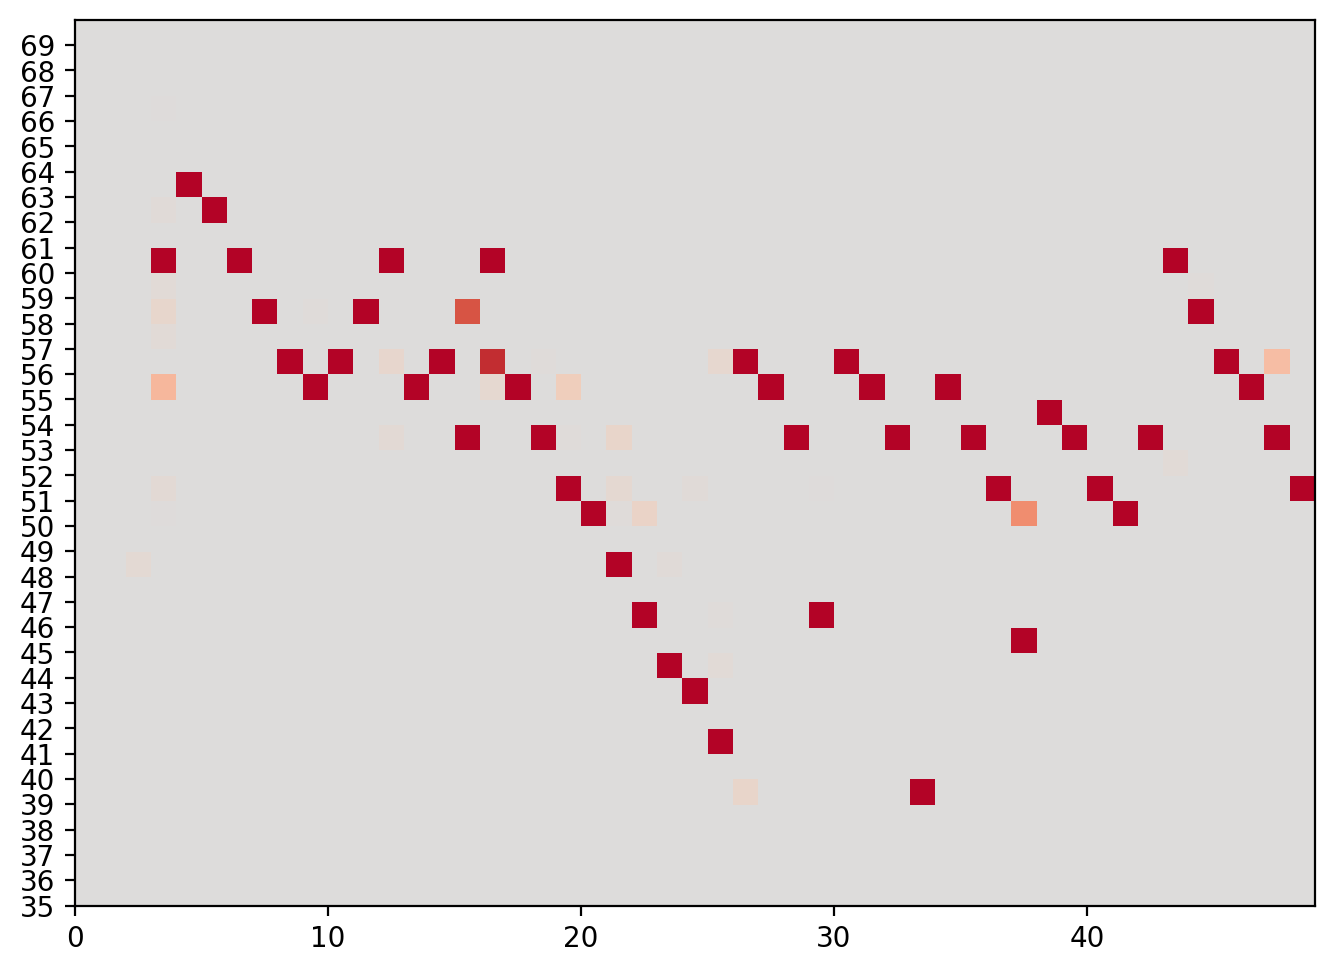

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [62]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [63]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

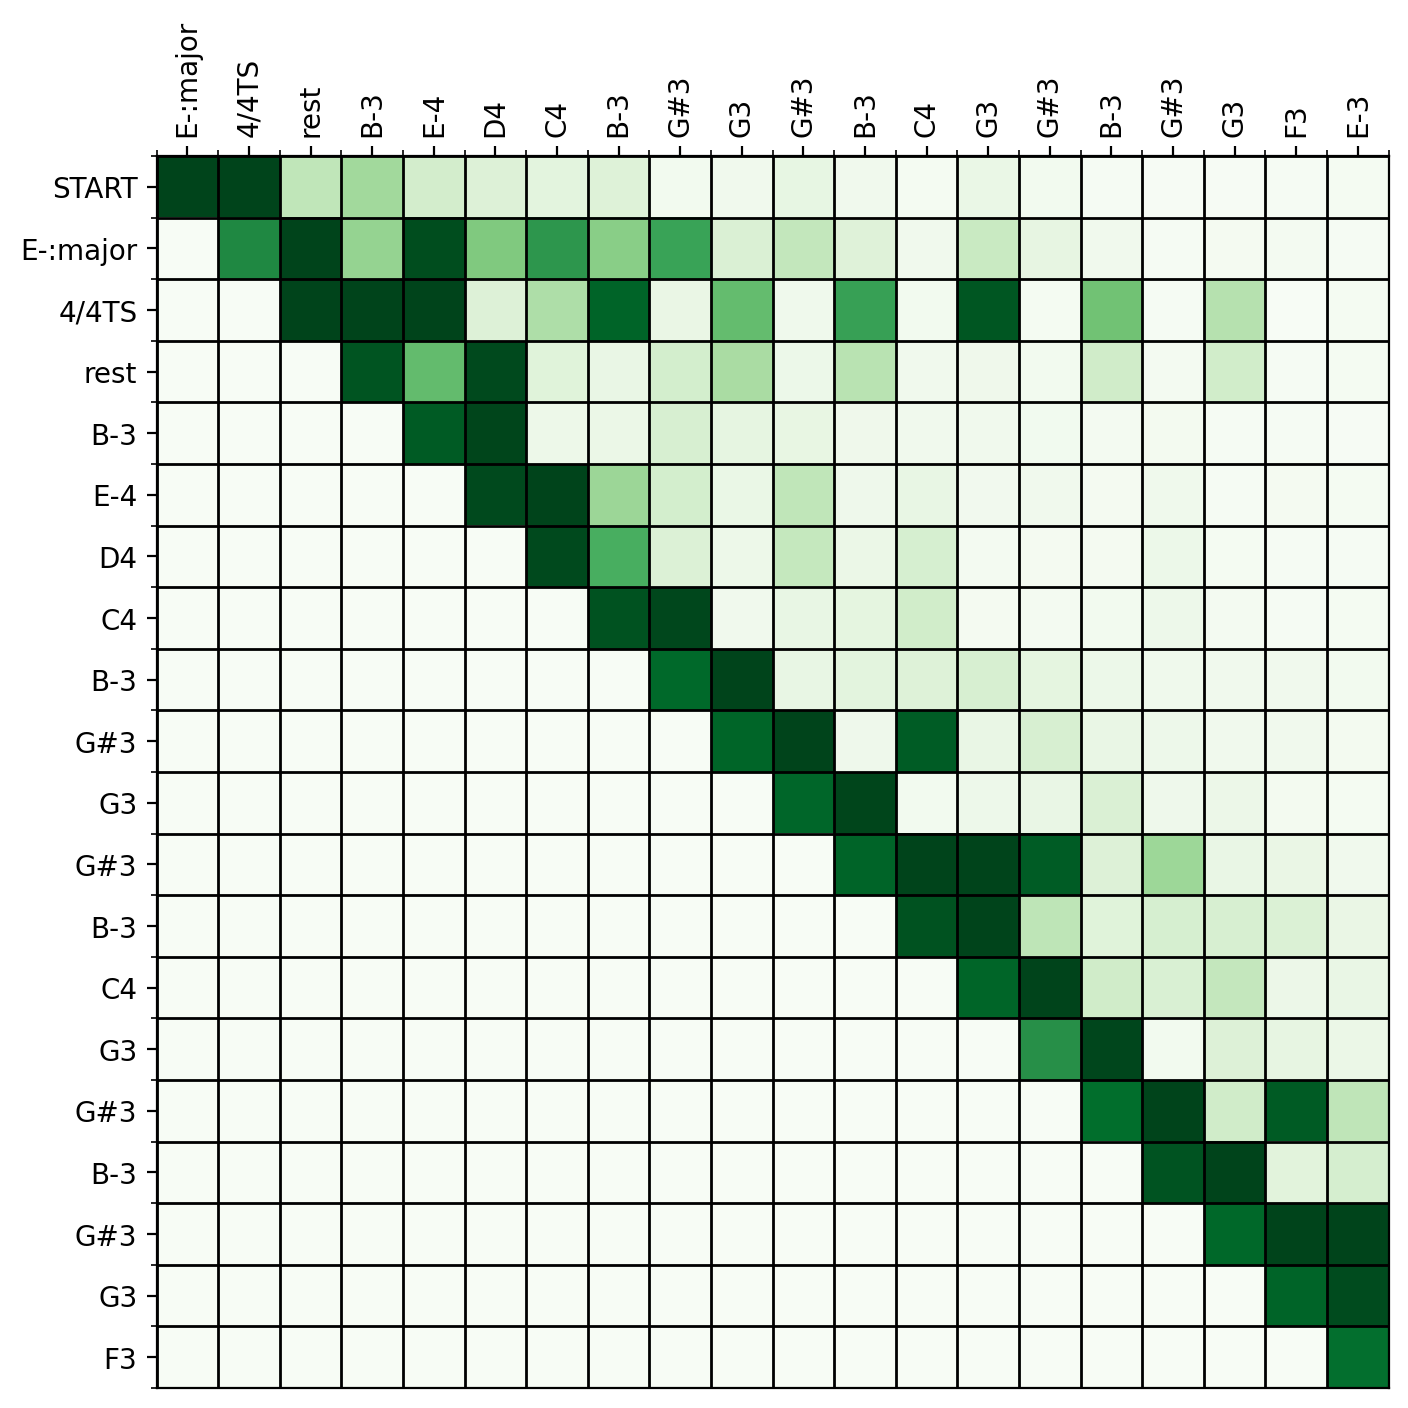

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()